In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import math
from dateutil import parser

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#from transformers import pipeline
#from transformers import DistilBertConfig, DistilBertModel
from torch.utils.data import Dataset, DataLoader
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

import torch
from torch import nn
import torch.nn.functional as F

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% ! important; }<style>"))

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import pandas.tseries 
from scipy import stats
from pylab import rcParams

import bert
import bert_tokenizer as tokenization
import tensorflow_hub as hub 

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import seaborn as sns
mpl.style.use('seaborn') # так красивее
%pylab inline

## Обработка данных

In [2]:
data = pd.read_excel("D:\грузи сюда учебу\Диплом\Портфель страхования жизни 2016.xlsx", skiprows=3)
data = data.drop_duplicates()
data = data.reset_index(drop=True)
data.shape

(59121, 59)

import plotly.figure_factory as ff
fig = ff.create_table(data.describe())
fig.update_layout(
autosize=False,
width=3000,
height=500,
)

In [3]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data.select_dtypes(include=numerics).describe()
#data.select_dtypes(include=numerics).describe().to_excel("D:\\грузи сюда учебу\\Диплом\\data_description.xlsx") 

Номер договора   Старый номер договора   \
count        59120.000                3797.000   
mean    1061375588.724           171185885.080   
std      320076667.835             4399180.665   
min     1000237917.000           170000003.000   
25%     1014717714.000           170002463.000   
50%     1048438719.000           170006390.000   
75%     1069354619.000           170011393.000   
max     8472203740.000           190000642.000   

       Задолженность на дату убытка, руб.  Доп. доход  Агент по договору  \
count                           49803.000   49094.000          59121.000   
mean                               70.255    1082.075        1042940.453   
std                               850.011    5366.242          37188.977   
min                                 0.000       0.000        1000008.000   
25%                                 0.000       0.000        1012216.000   
50%                                 0.000       0.000        1030731.000   
75%                                 0.000       0.000        1068300.000   
max                             62977.000  425286.000        1145020.000   

       ID Застрахованного       ИД ЭСС   \
count           59121.000     59121.000   
mean         64473567.383 169396959.009   
std          62268078.278  76480003.818   
min                 6.000  15050771.000   
25%           2639864.000 115185262.000   
50%          32845231.000 175214820.000   
75%         116514933.000 240235620.000   
max         224005055.000 275250958.000   

       Страховая сумма по риску, в валюте ответственности  \
count                                          59070.000    
mean                                          283221.819    
std                                           284104.059    
min                                               10.000    
25%                                           100000.000    
50%                                           204000.000    
75%                                           400000.000    
max                                         12486628.000    

       Кол-во дней нетрудоспособности  Оплаченные дни нетрудоспособности  \
count                       17926.000                          42157.000   
mean                           28.643                              9.291   
std                            24.341                             15.368   
min                             1.000                              0.000   
25%                            14.000                              0.000   
50%                            22.000                              0.000   
75%                            37.000                             13.000   
max                          1147.000                             90.000   

       ЗУ, % от страховой суммы   РЗУ, в валюте ответственности  \
count                  58654.000                      59093.000   
mean                     103.618                       2349.114   
std                      353.152                      38116.771   
min                        0.000                          0.000   
25%                        1.000                          0.000   
50%                        5.000                          0.000   
75%                      100.000                          0.000   
max                     9000.000                    5459000.000   

       Размер страховой выплаты в валюте ответственности  \
count                                          54357.000   
mean                                           34520.293   
std                                            95764.478   
min                                                0.000   
25%                                             3300.000   
50%                                            10131.000   
75%                                            25800.000   
max                                         12486628.000   

       Размер страховой выплаты, рубли  Доля выгодоприобретателя    № акта  \
count                    

In [4]:
data.loc[data['Разница между датой выплаты и датой подачи заявления'] <= 0, 'Разница между датой выплаты и датой подачи заявления'] = int(
    np.mean(data[(data['Разница между датой выплаты и датой подачи заявления'] > 0) & (data['Разница между датой выплаты и датой подачи заявления'] < 3000)
                     ]['Разница между датой выплаты и датой подачи заявления']))

data.loc[data['Разница между датой выплаты и датой подачи заявления'] > 4000, 'Разница между датой выплаты и датой подачи заявления'] = int(
    np.mean(data[(data['Разница между датой выплаты и датой подачи заявления'] > 0) & (data['Разница между датой выплаты и датой подачи заявления'] < 3000)
                     ]['Разница между датой выплаты и датой подачи заявления']))

##########################################################################################################################

data.loc[data['Разница между датой отказа в выплате и заявления о страховом случае'] <= 0, 'Разница между датой отказа в выплате и заявления о страховом случае'] = int(
    np.mean(data[(data['Разница между датой отказа в выплате и заявления о страховом случае'] > 0) & (data['Разница между датой отказа в выплате и заявления о страховом случае'] < 3000)
                     ]['Разница между датой отказа в выплате и заявления о страховом случае']))

data.loc[data['Разница между датой отказа в выплате и заявления о страховом случае'] > 4000, 'Разница между датой отказа в выплате и заявления о страховом случае'] = int(
    np.mean(data[(data['Разница между датой отказа в выплате и заявления о страховом случае'] > 0) & (data['Разница между датой отказа в выплате и заявления о страховом случае'] < 3000)
                     ]['Разница между датой отказа в выплате и заявления о страховом случае']))

##########################################################################################################################

data.loc[data['Разница между датой вступления договора в силу и наступлением страхового случая'] <= 0, 'Разница между датой вступления договора в силу и наступлением страхового случая'] = int(
    np.mean(data[(data['Разница между датой вступления договора в силу и наступлением страхового случая'] > 0) & (data['Разница между датой вступления договора в силу и наступлением страхового случая'] < 3000)
                     ]['Разница между датой вступления договора в силу и наступлением страхового случая']))

data.loc[data['Разница между датой вступления договора в силу и наступлением страхового случая'] > 5000, 'Разница между датой вступления договора в силу и наступлением страхового случая'] = int(
    np.mean(data[(data['Разница между датой вступления договора в силу и наступлением страхового случая'] > 0) & (data['Разница между датой вступления договора в силу и наступлением страхового случая'] < 3000)
                     ]['Разница между датой вступления договора в силу и наступлением страхового случая']))

##########################################################################################################################

data.loc[data['НДФЛ'] <= 0, 'НДФЛ'] = 0







data['Мошенничество'] = 0
data['Мошенничество'][[True if (str(n) != "nan") else False for n in data['Дата отклонения ЭСС']]] = 1
data['Мошенничество'][[True if (str(n) == "nan") | (n == 0) else False for n in data['Размер страховой выплаты в валюте ответственности']]] = 1
data['Мошенничество'][[True if (str(n) == "nan") | (n == 0) else False for n in data['Размер страховой выплаты, рубли']]] = 1
data['Мошенничество'][[True if (str(n) == "Отклоненный") else False for n in data['Статус ЭСС ']]] = 1

In [5]:
#data.select_dtypes(include=numerics).describe().reset_index().iloc[7]

data.select_dtypes(include=numerics).describe()
#data.select_dtypes(include=numerics).describe().to_excel("D:\\грузи сюда учебу\\Диплом\\data_description.xlsx") 

Номер договора   Старый номер договора   \
count        59120.000                3797.000   
mean    1061375588.724           171185885.080   
std      320076667.835             4399180.665   
min     1000237917.000           170000003.000   
25%     1014717714.000           170002463.000   
50%     1048438719.000           170006390.000   
75%     1069354619.000           170011393.000   
max     8472203740.000           190000642.000   

       Задолженность на дату убытка, руб.  Доп. доход  Агент по договору  \
count                           49803.000   49094.000          59121.000   
mean                               70.255    1082.075        1042940.453   
std                               850.011    5366.242          37188.977   
min                                 0.000       0.000        1000008.000   
25%                                 0.000       0.000        1012216.000   
50%                                 0.000       0.000        1030731.000   
75%                                 0.000       0.000        1068300.000   
max                             62977.000  425286.000        1145020.000   

       ID Застрахованного       ИД ЭСС   \
count           59121.000     59121.000   
mean         64473567.383 169396959.009   
std          62268078.278  76480003.818   
min                 6.000  15050771.000   
25%           2639864.000 115185262.000   
50%          32845231.000 175214820.000   
75%         116514933.000 240235620.000   
max         224005055.000 275250958.000   

       Страховая сумма по риску, в валюте ответственности  \
count                                          59070.000    
mean                                          283221.819    
std                                           284104.059    
min                                               10.000    
25%                                           100000.000    
50%                                           204000.000    
75%                                           400000.000    
max                                         12486628.000    

       Кол-во дней нетрудоспособности  Оплаченные дни нетрудоспособности  \
count                       17926.000                          42157.000   
mean                           28.643                              9.291   
std                            24.341                             15.368   
min                             1.000                              0.000   
25%                            14.000                              0.000   
50%                            22.000                              0.000   
75%                            37.000                             13.000   
max                          1147.000                             90.000   

       ЗУ, % от страховой суммы   РЗУ, в валюте ответственности  \
count                  58654.000                      59093.000   
mean                     103.618                       2349.114   
std                      353.152                      38116.771   
min                        0.000                          0.000   
25%                        1.000                          0.000   
50%                        5.000                          0.000   
75%                      100.000                          0.000   
max                     9000.000                    5459000.000   

       Размер страховой выплаты в валюте ответственности  \
count                                          54357.000   
mean                                           34520.293   
std                                            95764.478   
min                                                0.000   
25%                                             3300.000   
50%                                            10131.000   
75%                                            25800.000   
max                                         12486628.000   

       Размер страховой выплаты, рубли  Доля выгодоприобретателя    № акта  \
count                    

In [ ]:
fig = px.histogram(data[
    (data['Мошенничество'] == 0) & # ТУТ РАЗЛИЧИЕ С ГРАФИКОМ СНИЗУ
    (data['Разница между датой вступления договора в силу и наступлением страхового случая'] >= 1) &
    (data['Разница между датой вступления договора в силу и наступлением страхового случая'] < 2000)], x='Разница между датой вступления договора в силу и наступлением страхового случая',
                  nbins=50, text_auto=True)

fig.update_xaxes(title_text="Количество дней")
fig.update_yaxes(title_text="Количество договоров")
fig.update_layout(xaxis=dict(ticklen=5, tickwidth=2, tickfont=dict(size=20), title_font=dict(size=25)))
fig.update_layout(yaxis=dict(ticklen=5, tickwidth=2, tickfont=dict(size=20), title_font=dict(size=25)))
fig.update_layout(width=1400, height=900)
fig.update_traces(textfont_size=20)
fig.show()

In [ ]:
fig = px.histogram(data[
    (data['Мошенничество'] == 1) & # ТУТ РАЗЛИЧИЕ С ГРАФИКОМ СВЕРХУ
    (data['Разница между датой вступления договора в силу и наступлением страхового случая'] >= 1) &
    (data['Разница между датой вступления договора в силу и наступлением страхового случая'] < 2000)], x='Разница между датой вступления договора в силу и наступлением страхового случая',
                  nbins=50, text_auto=True)

fig.update_xaxes(title_text="Количество дней")
fig.update_yaxes(title_text="Количество договоров")
fig.update_layout(xaxis=dict(ticklen=5, tickwidth=2, tickfont=dict(size=20), title_font=dict(size=25)))
fig.update_layout(yaxis=dict(ticklen=5, tickwidth=2, tickfont=dict(size=20), title_font=dict(size=25)))
fig.update_layout(width=1400, height=900)
fig.update_traces(textfont_size=20)
fig.show()

In [10]:
main_cols = ['Задолженность на дату убытка, руб.', 'Доп. доход', 'Страховая сумма по риску, в валюте ответственности', 'Кол-во дней нетрудоспособности', 'Оплаченные дни нетрудоспособности',
       'ЗУ, % от страховой суммы ', 'РЗУ, в валюте ответственности', 'Размер страховой выплаты в валюте ответственности', 'Размер страховой выплаты, рубли', 'Доля выгодоприобретателя',
       'Сумма к выплате, рубли', 'СС main programm', 'Разница между датой вступления договора в силу и наступлением страхового случая']

first = ['Задолженность на дату убытка, руб.', #'Доп. доход',
       #'Страховая сумма по риску, в валюте ответственности',
       'Кол-во дней нетрудоспособности', 'Оплаченные дни нетрудоспособности',
       'ЗУ, % от страховой суммы ', #'РЗУ, в валюте ответственности',
       #'Размер страховой выплаты в валюте ответственности',
       #'Размер страховой выплаты, рубли', 
       'Доля выгодоприобретателя',
       #'Сумма к выплате, рубли', 
       #'НДФЛ', 
       #'СС main programm',
       #'Разница между датой вступления договора в силу и наступлением страхового случая'
        ]

second = ['РЗУ, в валюте ответственности', 'НДФЛ']

In [101]:
#df_for_boxplot_2 = data.apply(pd.to_numeric, errors='coerce').fillna(0)

#for col in main_cols:
    #quantiled = df_for_boxplot_2[col][df_for_boxplot_2[col] < df_for_boxplot_2[col].quantile([0, 0.99])[0.99]]
    #plt.figure(figsize=(15, 7))
    #plt.title('Корреляционная матрица', fontsize = 40)
    #res = sns.boxplot(data=quantiled)
    #res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 30)

    #y_ticks = res.get_yticks()
    #res.set_yticks(y_ticks)
    #res.set_yticklabels(y_ticks, fontsize=30)
    #plt.show()

In [130]:
#normal_test_df.to_excel("D:\\грузи сюда учебу\\Диплом\\normal_test.xlsx") 

In [11]:
import scipy
normal_test_df = pd.DataFrame(columns=['stat', 'p', 'name', 'test'])
for col in range(len(main_cols)):
    stat, p = scipy.stats.shapiro(data[main_cols[col]].dropna()) # тест Шапиро-Уилк
    print('Statistics=%.5f, p-value=%.5f' % (stat, p))
    normal_test_df.loc[col] = stat, p, main_cols[col], 'shapiro'
    alpha = 0.05
    if p > alpha:
        print(f'Принять гипотезу о нормальности {main_cols[col]}')
    else:
        print(f'Отклонить гипотезу о нормальности {main_cols[col]}')

Statistics=0.05594, p-value=0.00000
Отклонить гипотезу о нормальности Задолженность на дату убытка, руб.
Statistics=0.18355, p-value=0.00000
Отклонить гипотезу о нормальности Доп. доход
Statistics=0.80315, p-value=0.00000
Отклонить гипотезу о нормальности Страховая сумма по риску, в валюте ответственности
Statistics=0.70979, p-value=0.00000
Отклонить гипотезу о нормальности Кол-во дней нетрудоспособности
Statistics=0.66638, p-value=0.00000
Отклонить гипотезу о нормальности Оплаченные дни нетрудоспособности
Statistics=0.29363, p-value=0.00000
Отклонить гипотезу о нормальности ЗУ, % от страховой суммы 
Statistics=0.03236, p-value=0.00000
Отклонить гипотезу о нормальности РЗУ, в валюте ответственности
Statistics=0.29279, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты в валюте ответственности
Statistics=0.29644, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты, рубли
Statistics=0.05678, p-value=0.00000
Отклонить гипотезу о нормальности 

In [12]:
for col in range(len(main_cols)):
    stat, p = scipy.stats.normaltest(data[main_cols[col]].dropna()) # Критерий согласия Пирсона
    print('Statistics=%.5f, p-value=%.5f' % (stat, p))
    normal_test_df.loc[col+14] = stat, p, main_cols[col], 'pirson'
    alpha = 0.05
    if p > alpha:
        print(f'Принять гипотезу о нормальности {main_cols[col]}')
    else:
        print(f'Отклонить гипотезу о нормальности {main_cols[col]}')

Statistics=119547.25023, p-value=0.00000
Отклонить гипотезу о нормальности Задолженность на дату убытка, руб.
Statistics=112746.71623, p-value=0.00000
Отклонить гипотезу о нормальности Доп. доход
Statistics=51168.10140, p-value=0.00000
Отклонить гипотезу о нормальности Страховая сумма по риску, в валюте ответственности
Statistics=25189.42199, p-value=0.00000
Отклонить гипотезу о нормальности Кол-во дней нетрудоспособности
Statistics=14534.27098, p-value=0.00000
Отклонить гипотезу о нормальности Оплаченные дни нетрудоспособности
Statistics=80073.72622, p-value=0.00000
Отклонить гипотезу о нормальности ЗУ, % от страховой суммы 
Statistics=207901.68469, p-value=0.00000
Отклонить гипотезу о нормальности РЗУ, в валюте ответственности
Statistics=164989.66894, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты в валюте ответственности
Statistics=142427.15968, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты, рубли
Statistics=101552.04222, p-va

In [13]:
for col in range(len(main_cols)):
    stat, p = scipy.stats.kstest(data[main_cols[col]].dropna(), 'norm') # колмогорова-смирнова критерий
    print('Statistics=%.5f, p-value=%.5f' % (stat, p))
    normal_test_df.loc[col+28] = stat, p, main_cols[col], 'kolmagorov'
    alpha = 0.05
    if p > alpha:
        print(f'Принять гипотезу о нормальности {main_cols[col]}')
    else:
        print(f'Отклонить гипотезу о нормальности {main_cols[col]}')

Statistics=0.50000, p-value=0.00000
Отклонить гипотезу о нормальности Задолженность на дату убытка, руб.
Statistics=0.50000, p-value=0.00000
Отклонить гипотезу о нормальности Доп. доход
Statistics=1.00000, p-value=0.00000
Отклонить гипотезу о нормальности Страховая сумма по риску, в валюте ответственности
Statistics=0.99820, p-value=0.00000
Отклонить гипотезу о нормальности Кол-во дней нетрудоспособности
Statistics=0.50000, p-value=0.00000
Отклонить гипотезу о нормальности Оплаченные дни нетрудоспособности
Statistics=0.71094, p-value=0.00000
Отклонить гипотезу о нормальности ЗУ, % от страховой суммы 
Statistics=0.50000, p-value=0.00000
Отклонить гипотезу о нормальности РЗУ, в валюте ответственности
Statistics=0.91548, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты в валюте ответственности
Statistics=0.91548, p-value=0.00000
Отклонить гипотезу о нормальности Размер страховой выплаты, рубли
Statistics=0.99981, p-value=0.00000
Отклонить гипотезу о нормальности 

### Начинаем моделирование

In [6]:
data_1 = data[['Вид страхования', 'Канал продаж', 'Серия договора',  'Дата вступления договора в силу', 'Дата начала договора', 'Дата окончания договора', 'Дата конца', 'Валюта ответственности', 'Задолженность на дату убытка, руб.', 'Доп. доход', 'Тип заявителя', 
 'Дата составления', 'Дата подписания', 'Дата принятия', 'Тип случая', 'Причина случая', 'Дата и время случая', 'Место случая', 'Дата рождения', 'Регион', 'Тип страх. случая', 'Дата страх. случая', 'Группа инвалидности',
       'Страховой риск, по которому произошло событие',
       'Страховая сумма по риску, в валюте ответственности',
       'Кол-во дней нетрудоспособности', 'Оплаченные дни нетрудоспособности',
       'Дата подачи полного пакета', 'ЗУ, % от страховой суммы ',
       'РЗУ, в валюте ответственности', 'Описание ЭСС', 'Дата отклонения ЭСС',
       'Размер страховой выплаты в валюте ответственности',
       'Размер страховой выплаты, рубли', 'Тип выплаты',
       'Доля выгодоприобретателя', 'Дата составления акта',
       'Сумма к выплате, рубли', 'НДФЛ', 'Состояние выплаты',
       'Дата осуществления', 'Способ выплаты', 'CC main program',
       'Risk code', 'СС main programm',
       'Разница между датой вступления договора в силу и наступлением страхового случая',
       'Мошенничество']]

cols_list = []

for col in data_1.columns[:-1]:
    share = sum(data_1[data_1[col].isna()]["Мошенничество"])/ data_1[data_1[col].isna()].shape[0]
    nan_qty = data_1[data_1[col].isna()].shape[0]
    if share >=0.2:
        print(f'Доля мошенничества в NAN {share}, количество NAN {data_1[data_1[col].isna()].shape[0]}, количество НЕ NAN {data_1.dropna(subset=[col]).shape[0]}, столбец {col}.')
        cols_list.append(col)

Доля мошенничества в NAN 0.9259259259259259, количество NAN 54, количество НЕ NAN 59067, столбец Дата вступления договора в силу.
Доля мошенничества в NAN 0.998390212491951, количество NAN 9318, количество НЕ NAN 49803, столбец Задолженность на дату убытка, руб..
Доля мошенничества в NAN 0.5294117647058824, количество NAN 51, количество НЕ NAN 59070, столбец Тип заявителя.
Доля мошенничества в NAN 0.5365853658536586, количество NAN 41, количество НЕ NAN 59080, столбец Дата составления.
Доля мошенничества в NAN 0.9740596627756161, количество NAN 771, количество НЕ NAN 58350, столбец Дата подписания.
Доля мошенничества в NAN 0.9747675962815405, количество NAN 753, количество НЕ NAN 58368, столбец Дата принятия.
Доля мошенничества в NAN 0.8431372549019608, количество NAN 51, количество НЕ NAN 59070, столбец Страховая сумма по риску, в валюте ответственности.
Доля мошенничества в NAN 0.201407937856536, количество NAN 41195, количество НЕ NAN 17926, столбец Кол-во дней нетрудоспособности.
Д

In [7]:
for column in data_1.select_dtypes(include='number').columns:
    num = data_1[data_1[column].isna()].shape[0]
    data_1[column].fillna(value=np.random.uniform(low=data_1[column].min(), high=data_1[column].max()//10**30), inplace=True)
    #data_1[column].fillna(value=data_1[column].mean(), inplace=True)
    #data_1[column].fillna(value=0, inplace=True)
    print(f'{num} значений заменены на рандомные в столбце {column}.')

9318 значений заменены на рандомные в столбце Задолженность на дату убытка, руб..
10027 значений заменены на рандомные в столбце Доп. доход.
51 значений заменены на рандомные в столбце Страховая сумма по риску, в валюте ответственности.
41195 значений заменены на рандомные в столбце Кол-во дней нетрудоспособности.
16964 значений заменены на рандомные в столбце Оплаченные дни нетрудоспособности.
467 значений заменены на рандомные в столбце ЗУ, % от страховой суммы .
28 значений заменены на рандомные в столбце РЗУ, в валюте ответственности.
4764 значений заменены на рандомные в столбце Размер страховой выплаты в валюте ответственности.
4764 значений заменены на рандомные в столбце Размер страховой выплаты, рубли.
178 значений заменены на рандомные в столбце Доля выгодоприобретателя.
9327 значений заменены на рандомные в столбце Сумма к выплате, рубли.
9328 значений заменены на рандомные в столбце НДФЛ.
0 значений заменены на рандомные в столбце СС main programm.
0 значений заменены на ра

In [8]:
result_list = [x for x in cols_list if x not in ['Дата вступления договора в силу', 'Дата составления', 'Дата подписания', 'Дата принятия', 'Кол-во дней нетрудоспособности',
                                            'Дата подачи полного пакета', 'Тип выплаты', 'Дата составления акта', 'Сумма к выплате, рубли', 'НДФЛ', 'Состояние выплаты', 'Дата осуществления', 'Способ выплаты', 
                                                 'Задолженность на дату убытка, руб.', 'Размер страховой выплаты, рубли', 'Размер страховой выплаты в валюте ответственности',
                                                #'Доля выгодоприобретателя', 'Тип заявителя', 'Страховая сумма по риску, в валюте ответственности', 'ЗУ, % от страховой суммы '
                                                ]]
result_list

['Тип заявителя',
 'Страховая сумма по риску, в валюте ответственности',
 'ЗУ, % от страховой суммы ',
 'Описание ЭСС',
 'Доля выгодоприобретателя']

In [9]:
dropped_for_clustering = ['Дата составления', 'Дата подписания', 'Дата принятия', 'Дата и время случая', 'НДФЛ', 'Состояние выплаты', 'Дата отклонения ЭСС', 'Тип выплаты', 'Способ выплаты', 'Дата вступления договора в силу',
                         'Дата начала договора', 'Дата окончания договора', 'Дата конца', 'Дата страх. случая', 'Дата рождения', 'Дата подачи полного пакета', 'Дата составления акта', 'Дата осуществления', 'Вид страхования', 
                          'Сумма к выплате, рубли', 'Кол-во дней нетрудоспособности', 'Задолженность на дату убытка, руб.', 'Размер страховой выплаты, рубли', 'Размер страховой выплаты в валюте ответственности']
#data_for_cluster = data_1.drop(dropped_for_clustering, axis=1).dropna(subset=result_list).fillna(0)
data_for_cluster = data_1.drop(dropped_for_clustering, axis=1).fillna(0)
data_for_cluster.shape

(59121, 23)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок в страховании жизни, свёрточная нейронная сеть (CNN)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 35)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 25)
    plt.yticks(tick_marks, classes, fontsize = 25)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=25)

    plt.tight_layout()
    plt.ylabel('Реальное значение целевой переменной', fontsize = 25)
    plt.xlabel('Предсказанное значение целевой переменной', fontsize = 25)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data_for_cluster.drop(['Мошенничество'], axis=1), data_for_cluster['Мошенничество'], test_size=0.25, random_state=911)
x_train.select_dtypes(include='object').head()

Канал продаж Серия договора Валюта ответственности  \
11892   Агентская сеть            LR1                    RUR   
53954   Агентская сеть            LC1                    RUR   
23106  Брокерская сеть            LC1                    RUR   
36776   Агентская сеть            LA0                    RUR   
29530   Агентская сеть            LR1                    RUR   

                Тип заявителя            Тип случая  Причина случая  \
11892          Застрахованный     Несчастный случай  Бытовая травма   
53954  Законный представитель     Несчастный случай  Бытовая травма   
23106  Законный представитель     Несчастный случай  Бытовая травма   
36776          Застрахованный  Не несчастный случай         Дожитие   
29530          Застрахованный  Не несчастный случай         Дожитие   

        Место случая                Регион Тип страх. случая  \
11892         Казань  Татарстан Республика            Травмы   
53954        Барнаул        Алтайский край            Травмы   
23106          Черни    Московская область            Травмы   
36776  Сергиев-Посад   Воронежская область           Дожитие   
29530              0        Омская область           Дожитие   

      Группа инвалидности      Страховой риск, по которому произошло событие  \
11892                   0                     Госпитализация в результате НС   
53954                   0                    П3 Телесные повреждения Ребенка   
23106                   0             П3 Тяжкие телесные повреждения Ребенка   
36776                   0  В5-Смерть/Дожитие до очередной выплаты пенсии-...   
29530                   0                                   Смерть / Дожитие   

                                            Описание ЭСС CC main program  \
11892  Посттравматическая сгибательная контрактура 2 ...            1-ФЛ   
53954                            Ушиб н/3 пр. предплечья            1-ФЛ   
23106                                                  0            1-ФЛ   
36776                                            Дожитие            1-ФЛ   
29530                                            Дожитие            1-ФЛ   

                      Risk code  
11892  Accidental Hospital cash  
53954          Child's accident  
23106          Child's accident  
36776                  Maturity  
29530                  Maturity

In [13]:
te = TargetEncoder()
X_train_target_encoded = te.fit_transform(x_train.select_dtypes(include='object').drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая'], axis=1), y_train)
X_test_target_encoded = te.transform(x_test.select_dtypes(include='object').drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая'], axis=1))
X_train_target_encoded.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
11892         0.146           0.120                   0.159          0.111   
53954         0.146           0.298                   0.159          0.314   
23106         0.202           0.298                   0.159          0.314   
36776         0.146           0.057                   0.159          0.111   
29530         0.146           0.120                   0.159          0.111   

       Тип случая  Место случая  Регион  Группа инвалидности  \
11892       0.178         0.125   0.122                0.156   
53954       0.178         0.205   0.207                0.156   
23106       0.178         0.500   0.154                0.156   
36776       0.087         0.058   0.127                0.156   
29530       0.087         0.078   0.166                0.156   

       Страховой риск, по которому произошло событие  CC main program  \
11892                                          0.132            0.158   
53954                                          0.059            0.158   
23106                                          1.000            0.158   
36776                                          0.057            0.158   
29530                                          0.082            0.158   

       Risk code  
11892      0.101  
53954      0.317  
23106      0.317  
36776      0.042  
29530      0.042

In [14]:
lst_idx_for_delete = []
before_len = X_train_target_encoded.shape[0]
for col in X_train_target_encoded.columns:
    while max(X_train_target_encoded[col]) == 1:
        lst_idx_for_delete.extend(X_train_target_encoded[X_train_target_encoded[col] == max(X_train_target_encoded[col])].index) 
        X_train_target_encoded = X_train_target_encoded.loc[~X_train_target_encoded.index.isin(list(set(lst_idx_for_delete)))]
    print(f'{col}, {max(X_train_target_encoded[col])}')
    
print(f'Всего было удалено {before_len - X_train_target_encoded.shape[0]} наблюдений.')

lst_idx_for_delete_train = list(set(lst_idx_for_delete))
x_train = x_train.loc[~x_train.index.isin(lst_idx_for_delete_train)]
y_train = y_train.loc[~y_train.index.isin(lst_idx_for_delete_train)]

Канал продаж, 0.6
Серия договора, 0.2979432092597219
Валюта ответственности, 0.1594031922276197
Тип заявителя, 0.3939393939393939
Тип случая, 0.17820229938450818
Место случая, 0.8
Регион, 0.4536082474226804
Группа инвалидности, 0.63125
Страховой риск, по которому произошло событие, 0.999622783855149
CC main program, 0.16535433070866143
Risk code, 0.5735294117647058
Всего было удалено 385 наблюдений.


In [15]:
lst_idx_for_delete = []
before_len = X_test_target_encoded.shape[0]
for col in X_test_target_encoded.columns:
    while max(X_test_target_encoded[col]) == 1:
        lst_idx_for_delete.extend(X_test_target_encoded[X_test_target_encoded[col] == max(X_test_target_encoded[col])].index) 
        X_test_target_encoded = X_test_target_encoded.loc[~X_test_target_encoded.index.isin(list(set(lst_idx_for_delete)))]
    print(f'{col}, {max(X_test_target_encoded[col])}')
    
print(f'Всего было удалено {before_len - X_test_target_encoded.shape[0]} наблюдений.')

lst_idx_for_delete_test = list(set(lst_idx_for_delete))
x_test = x_test.loc[~x_test.index.isin(lst_idx_for_delete_test)]
y_test = y_test.loc[~y_test.index.isin(lst_idx_for_delete_test)]

Канал продаж, 0.6
Серия договора, 0.2979432092597219
Валюта ответственности, 0.1594031922276197
Тип заявителя, 0.3939393939393939
Тип случая, 0.17820229938450818
Место случая, 0.8
Регион, 0.4536082474226804
Группа инвалидности, 0.63125
Страховой риск, по которому произошло событие, 0.999622783855149
CC main program, 0.16535433070866143
Risk code, 0.5735294117647058
Всего было удалено 124 наблюдений.


In [24]:
x_train_new = pd.concat([X_train_target_encoded, x_train.drop(X_train_target_encoded.columns, axis=1)], axis=1)
x_test_new = pd.concat([X_test_target_encoded, x_test.drop(X_test_target_encoded.columns, axis=1)], axis=1)

indexes_for_train = x_train.index
indexes_for_test = x_test.index

X_new = pd.concat([x_train_new, x_test_new], axis=0).fillna(0)
y_new = pd.concat([y_train, y_test], axis=0)
y_new = pd.DataFrame(y_new, columns=['Мошенничество'])
sum(y_new['Мошенничество'])/y_new.shape[0], y_new.shape[0]

(0.15188016105916877, 58612)

In [25]:
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая'], axis=1))

In [2045]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


# https://habr.com/ru/companies/citymobil/articles/649063/

kmeans_kwargs = {
        "init": "k-means++",   #Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
        "n_init": 50,          #Number of times the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
        "max_iter": 500,       #Maximum number of iterations of the k-means algorithm for a single run.
        "random_state": 911,    #Provided to control the random number generator used
                }



# Calinski Harabasz, a list holds for different values of k
calinski_harabasz = []
sse = []
silhouette_coefficients = []
davies_bouldin = []

#A list holds the different coefficients for each k
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_new_scaled)
    calinski_harabasz.append(metrics.calinski_harabasz_score(X_new_scaled, kmeans.labels_))
    sse.append(kmeans.inertia_)
    silhouette_coefficients.append(silhouette_score(X_new_scaled, kmeans.labels_))
    davies_bouldin.append(davies_bouldin_score(X_new_scaled, kmeans.labels_))

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(17, 9))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), calinski_harabasz)
plt.yticks(fontsize=25)
plt.xticks(range(2, 15), fontsize=25)
plt.xlabel("Количество кластеров", fontsize=30)
plt.ylabel("Calinski-Harabasz index", fontsize=30)
plt.show()

In [ ]:
plt.figure(figsize=(17, 9))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), sse)
plt.yticks(fontsize=25)
plt.xticks(range(2, 15), fontsize=25)
plt.xlabel("Количество кластеров", fontsize=30)
plt.ylabel("SSE", fontsize=30)
plt.show()

In [ ]:
plt.figure(figsize=(17, 9))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.yticks(fontsize=25)
plt.xticks(range(2, 15), fontsize=25)
plt.xlabel("Количество кластеров", fontsize=30)
plt.ylabel("Silhouette Coefficient", fontsize=30)
plt.show()

In [ ]:
plt.figure(figsize=(17, 9))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), davies_bouldin)
plt.yticks(fontsize=25)
plt.xticks(range(2, 15), fontsize=25)
plt.xlabel("Количество кластеров", fontsize=30)
plt.ylabel("Davies-Bouldin index", fontsize=30)
plt.show()

In [28]:
kmeans_kwargs = {
        "init": "k-means++",   #Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
        "n_init": 50,          #Number of times the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
        "max_iter": 500,       #Maximum number of iterations of the k-means algorithm for a single run.
        "random_state": 911,    #Provided to control the random number generator used
                }


kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(X_new_scaled)

KMeans(max_iter=500, n_clusters=2, n_init=50, random_state=911)

In [29]:
centroids_norm = kmeans.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_norm)
#pd.DataFrame(centroids_orig, columns=X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Кластер'], axis=1).columns).to_excel("D:\грузи сюда учебу\Диплом\\центроиды.xlsx", index = True)
pd.DataFrame(centroids_orig, columns=X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая'], axis=1).columns)

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
0         0.154           0.294                   0.159          0.276   
1         0.159           0.108                   0.157          0.115   

   Тип случая  Место случая  Регион  Группа инвалидности  \
0       0.177         0.188   0.160                0.156   
1       0.151         0.137   0.157                0.157   

   Страховой риск, по которому произошло событие  CC main program  Risk code  \
0                                          0.295            0.158      0.304   
1                                          0.104            0.158      0.102   

   Доп. доход  Страховая сумма по риску, в валюте ответственности  \
0      29.730                                         330416.644    
1    1224.346                                         265701.587    

   Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
0                              0.815                     84.247   
1                              8.789                    110.050   

   РЗУ, в валюте ответственности  Доля выгодоприобретателя  СС main programm  \
0                        852.312                    99.242         17233.763   
1                       2789.617                    99.353         44209.405   

   Разница между датой вступления договора в силу и наступлением страхового случая  
0                                            653.498                                
1                                            925.415

In [2166]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_new_scaled, kmeans.labels_)
lda.score(X_new_scaled, kmeans.labels_)

0.9819490889237699

In [2167]:
from scipy.stats import chi2
from scipy.linalg import det

def wilks_lambda(X, y):
    """Вычисление статистики Уилкса
    
    Args:
    X (numpy.ndarray): матрица признаков размерности (n_samples, n_features)
    y (numpy.ndarray): вектор меток классов размерности (n_samples,)
    
    Returns:
    float: значение статистики Уилкса
    """
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    n_within = n_samples - n_classes
    # Вычисляем общую матрицу рассеяния и ее определитель
    S = np.cov(X, rowvar=False)
    detS = det(S)
    # Вычисляем матрицы рассеяния внутри и между классами
    S_w = np.zeros_like(S)
    S_b = np.zeros_like(S)
    for i in range(n_classes):
        Xi = X[y == i, :]
        pi = Xi.shape[0] / n_samples
        mi = np.mean(Xi, axis=0)
        S_w += np.cov(Xi, rowvar=False) * (Xi.shape[0] - 1)
        S_b += np.outer(mi, mi) * pi
    S_b -= np.outer(np.mean(X, axis=0), np.mean(X, axis=0)) * n_samples
    # Вычисляем статистику Уилкса
    invS_w = np.linalg.inv(S_w)
    invS_wS_b = np.dot(invS_w, S_b)
    _, logdet = np.linalg.slogdet(invS_wS_b)
    return 1. / (1. + detS ** (1. / n_within) * np.exp(-logdet))

wilks_lambda(X_new_scaled, kmeans.labels_) # Статистика Уилкса (Wilks' lambda)

0.0

In [2168]:
fisher_funcs = lda.decision_function(X_new_scaled)
print(fisher_funcs)

[ 26.02209566 -28.60483534 -28.73188377 ...  27.79537657 -26.33150056
 -25.59501589]


In [2169]:
min(fisher_funcs), max(fisher_funcs)

(-41.91520765018683, 76.30129696312449)

In [2170]:
lda.coef_

array([[  0.98818263, -16.0739802 ,   0.31820834,  -5.74529962,
          1.85952116,  -0.90021047,   0.18094988,   0.16967314,
          0.08649104,   0.1800767 ,  -2.41228665,   0.30617182,
          0.30212023,   0.30382622,   0.1823451 ,  -0.2135472 ,
         -0.18102353,   0.50305625,   1.17554995]])

In [2171]:
lda.means_

array([[-0.15035623,  1.53899035,  0.15923534,  1.42433666,  0.49431618,
         0.41150287,  0.07011706, -0.03186381,  0.63797341, -0.08291536,
         1.35655066, -0.17779702,  0.16736777, -0.42770414, -0.05355113,
        -0.03761548, -0.01065145, -0.18532145, -0.24708351],
       [ 0.05467563, -0.55963937, -0.05790443, -0.51794663, -0.17975343,
        -0.14963915, -0.02549741,  0.01158697, -0.23199303,  0.03015139,
        -0.49329689,  0.06465421, -0.06086172,  0.15553059,  0.01947336,
         0.01367852,  0.0038733 ,  0.0673904 ,  0.08984959]])

In [2172]:
print(classification_report(kmeans.labels_, lda.predict(X_new_scaled)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     15630
           1       0.99      0.98      0.99     42982

    accuracy                           0.98     58612
   macro avg       0.97      0.98      0.98     58612
weighted avg       0.98      0.98      0.98     58612



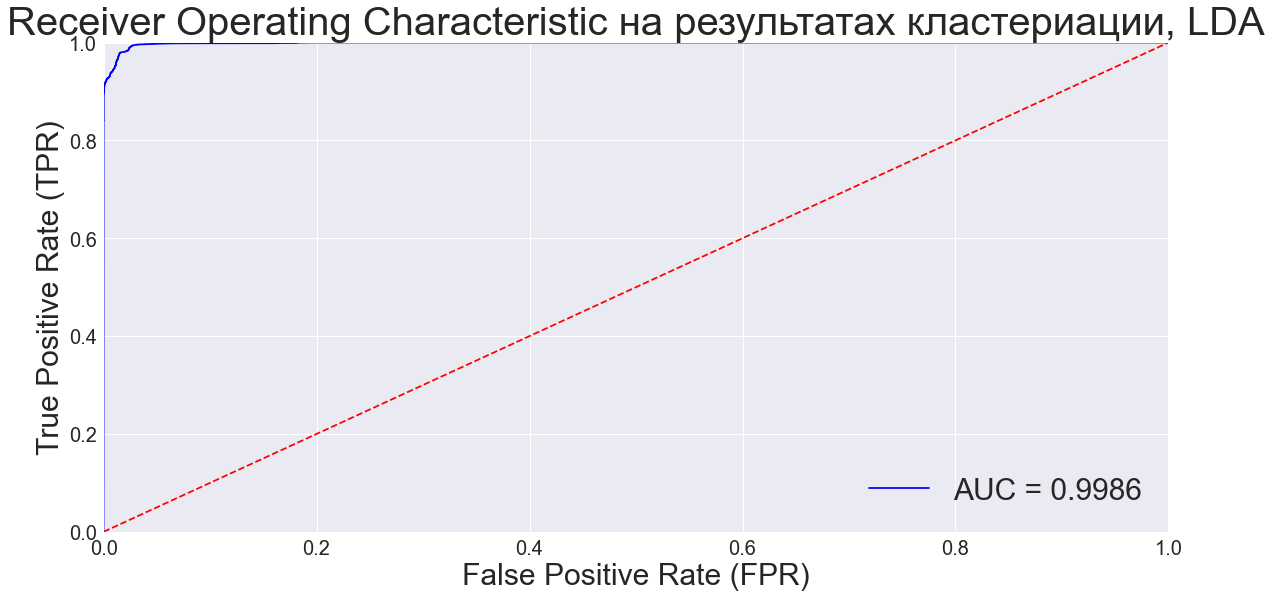

In [2173]:
fpr, tpr, threshold = roc_curve(kmeans.labels_, lda.predict_proba(X_new_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic на результатах кластериации, LDA', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

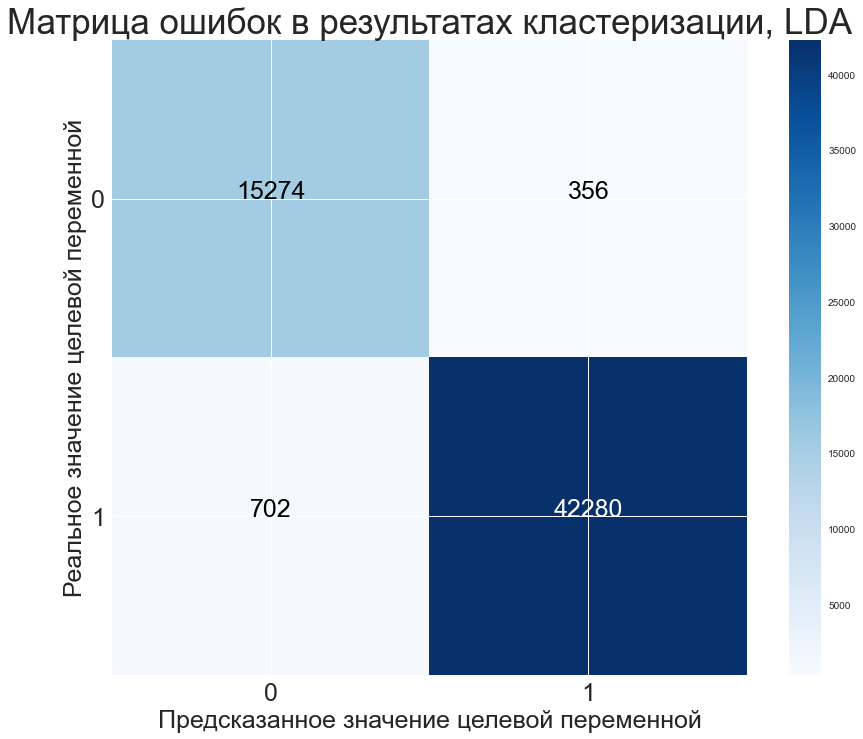

In [2174]:
plot_confusion_matrix(confusion_matrix(kmeans.labels_, lda.predict(X_new_scaled)), classes=set(kmeans.labels_),
                      title='Матрица ошибок в результатах кластеризации, LDA')

In [2175]:
clf = RandomForestClassifier(max_depth=4, random_state=911, n_estimators=1000, oob_score=True, bootstrap=True, criterion='entropy', verbose=1, n_jobs=-1)
clf.fit(X_new_scaled, kmeans.labels_)

accuracy_score(kmeans.labels_, clf.predict(X_new_scaled))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.9909233604040129

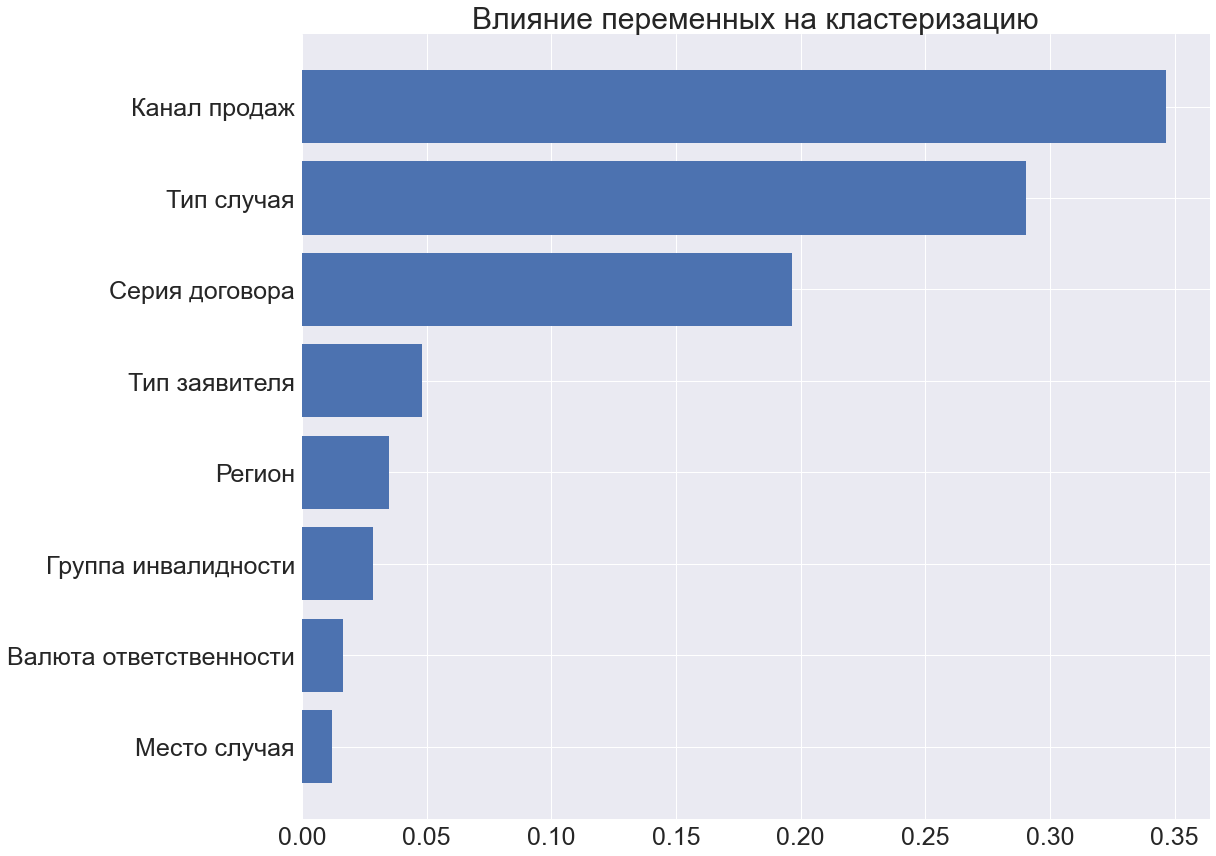

In [2176]:
feature_importance = clf.feature_importances_[clf.feature_importances_ >= 0.01]
sorted_idx = np.argsort(feature_importance[feature_importance >= 0.01])
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(17, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая'], axis=1).columns)[sorted_idx], fontsize=25)
plt.xticks(fontsize=25)
plt.title('Влияние переменных на кластеризацию', fontsize=30)
#result = permutation_importance(clf, X_train, target_train['Slopeprecioalc'], n_repeats=10,
                                #random_state=911, n_jobs=2)
#sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

In [30]:
X_new['Кластер'] = kmeans.labels_
X_new[X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Кластер'], axis=1).columns] = pd.DataFrame(X_new_scaled, columns=X_new.drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Кластер'], axis=1).columns).set_index(X_new.index)
X_new.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
11892        -0.493          -0.431                   0.160         -0.564   
53954        -0.493           1.586                   0.160          1.879   
23106         1.822           1.586                   0.160          1.879   
36776        -0.493          -1.139                   0.160         -0.564   
29530        -0.493          -0.431                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  \
11892       0.537        -0.282  -0.953               -0.054   
53954       0.537         0.600   1.324               -0.054   
23106       0.537         3.840  -0.085               -0.054   
36776      -1.862        -1.025  -0.809               -0.054   
29530      -1.862        -0.796   0.219               -0.054   

       Страховой риск, по которому произошло событие  CC main program  \
11892                                         -0.106           -0.093   
53954                                         -0.436           -0.093   
23106                                          3.848           -0.093   
36776                                         -0.448           -0.093   
29530                                         -0.334           -0.093   

       Risk code  Доп. доход  Причина случая Тип страх. случая  \
11892     -0.505      -0.184  Бытовая травма            Травмы   
53954      1.477      -0.184  Бытовая травма            Травмы   
23106      1.477      -0.184  Бытовая травма            Травмы   
36776     -1.044       1.589         Дожитие           Дожитие   
29530     -1.044       1.074         Дожитие           Дожитие   

       Страховая сумма по риску, в валюте ответственности  \
11892                                             -0.997    
53954                                              0.342    
23106                                             -0.116    
36776                                             -0.645    
29530                                             -0.306    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
11892                              0.171                      2.259   
53954                             -0.487                     -0.290   
23106                             -0.487                     -0.292   
36776                             -0.487                      0.019   
29530                             -0.487                     -0.000   

       РЗУ, в валюте ответственности  \
11892                         -0.060   
53954                         -0.060   
23106                         -0.060   
36776                         -0.060   
29530                         -0.060   

                                            Описание ЭСС  \
11892  Посттравматическая сгибательная контрактура 2 ...   
53954                            Ушиб н/3 пр. предплечья   
23106                                                  0   
36776                                            Дожитие   
29530                                            Дожитие   

       Доля выгодоприобретателя  СС main programm  \
11892                     0.096            -0.333   
53954                     0.096            -0.310   
23106                     0.096            -0.347   
36776                     0.096             0.714   
29530                     0.096             1.607   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
11892                                              1.327                                 
53954                                             -0.996                                 
23106                                             -0.533                                 
36776                                             -0.159                                 
29530                                              1.206                                 

       Кластер  
11892        1  
53954        0  
23106     

In [2178]:
def fletcher(df1, df2):
    lst1 = df1.values.tolist()
    lst2 = df2.values.tolist()
    numerator = 0
    denominator = 0
    n = len(lst1)
    
    for i in range(n):
        for j in range(i+1, n):
            numerator += (lst1[i] == lst1[j]) and (lst2[i] == lst2[j])
            denominator += (lst1[i] == lst1[j]) or (lst2[i] == lst2[j])
    
    if denominator == 0:
        return 0
    
    return 2 * numerator / denominator

In [2179]:
from scipy.stats import spearmanr, pearsonr, kendalltau

stats_spearman, p_spearman = spearmanr(X_new.loc[indexes_for_train]['Кластер'], y_new.loc[indexes_for_train]['Мошенничество'])
stats_person, p_person = pearsonr(X_new.loc[indexes_for_train]['Кластер'], y_new.loc[indexes_for_train]['Мошенничество'])
stats_kendalltau, p_kendalltau = kendalltau(X_new.loc[indexes_for_train]['Кластер'], y_new.loc[indexes_for_train]['Мошенничество'])

print(f'Корреляция Спирмена равна {stats_spearman}, p-value равен {p_spearman}, корреляция Пирсона равна {stats_person}, p-value равен {p_person}, корреляция Тау равна {stats_kendalltau}, p-value равен {p_kendalltau}.')

Корреляция Спирмена равна -0.2556735492377522, p-value равен 0.0, корреляция Пирсона равна -0.255673549237754, p-value равен 0.0, корреляция Тау равна -0.2556735492377522, p-value равен 0.0.


In [2180]:
from scipy.stats import f_oneway

for col in X_new.loc[indexes_for_train].drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Тип случая', 'Кластер'], axis=1).columns:
    f_stat, p_value = f_oneway(X_new.loc[indexes_for_train].drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Тип случая', 'Кластер'], axis=1)[X_new.loc[indexes_for_train]['Кластер'] == 0][col], 
                               X_new.loc[indexes_for_train].drop(['Описание ЭСС', 'Тип страх. случая', 'Причина случая', 'Тип случая', 'Кластер'], axis=1)[X_new.loc[indexes_for_train]['Кластер'] == 1][col])
    print(f"Признак {col}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

Признак Канал продаж: F-statistic = 388.549, p-value = 0.000
Признак Серия договора: F-statistic = 270673.716, p-value = 0.000
Признак Валюта ответственности: F-statistic = 407.880, p-value = 0.000
Признак Тип заявителя: F-statistic = 126067.224, p-value = 0.000
Признак Место случая: F-statistic = 2995.406, p-value = 0.000
Признак Регион: F-statistic = 83.442, p-value = 0.000
Признак Группа инвалидности: F-statistic = 16.161, p-value = 0.000
Признак Страховой риск, по которому произошло событие: F-statistic = 7692.117, p-value = 0.000
Признак CC main program: F-statistic = 105.873, p-value = 0.000
Признак Risk code: F-statistic = 90208.456, p-value = 0.000
Признак Доп. доход: F-statistic = 506.766, p-value = 0.000
Признак Страховая сумма по риску, в валюте ответственности: F-statistic = 501.008, p-value = 0.000
Признак Оплаченные дни нетрудоспособности: F-statistic = 3163.744, p-value = 0.000
Признак ЗУ, % от страховой суммы : F-statistic = 52.232, p-value = 0.000
Признак РЗУ, в валюте

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import seaborn as sns
mpl.style.use('seaborn') # так красивее
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 


model = LinearDiscriminantAnalysis()
model.fit(X1, y)


#create LDA plot
plt.figure()
colors = ['red', 'green']

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(data_plot[y == i], data_plot[y == i], alpha=.8, color=color, label=target_name)

#add legend to plot
plt.legend(loc='best', shadow= False , scatterpoints=1)

#display LDA plot
plt.show()

### Сначала кластерный, потом по кластерам дисперсионный, ищем различия, 2 кластера, паттерны, наиболее влияющие переменные, смерть дожитие и несчастн случай рассмотреть (разбить может быть на 2 датасета и сделать предсказания 2 раза) life non-life разбить на 2

## Life and non-life insuarance

### Life

In [2183]:
fig = px.histogram(data[(data['Мошенничество'] == 0) & (data['Разница между датой выплаты и датой подачи заявления'] >= 0) &
                        (data['Разница между датой выплаты и датой подачи заявления'] < 35000)], x='Разница между датой выплаты и датой подачи заявления',
                  nbins=100)
fig.show()

In [32]:
X_new['Страховой риск, по которому произошло событие'] = pd.DataFrame(pd.concat([x_train['Страховой риск, по которому произошло событие'], 
                                                                                 x_test['Страховой риск, по которому произошло событие']], axis=0), columns=['Страховой риск, по которому произошло событие']).set_index(X_new.index)

df_total = pd.concat([X_new, y_new['Мошенничество']], axis=1)
df_total.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
11892        -0.493          -0.431                   0.160         -0.564   
53954        -0.493           1.586                   0.160          1.879   
23106         1.822           1.586                   0.160          1.879   
36776        -0.493          -1.139                   0.160         -0.564   
29530        -0.493          -0.431                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  \
11892       0.537        -0.282  -0.953               -0.054   
53954       0.537         0.600   1.324               -0.054   
23106       0.537         3.840  -0.085               -0.054   
36776      -1.862        -1.025  -0.809               -0.054   
29530      -1.862        -0.796   0.219               -0.054   

           Страховой риск, по которому произошло событие  CC main program  \
11892                     Госпитализация в результате НС           -0.093   
53954                    П3 Телесные повреждения Ребенка           -0.093   
23106             П3 Тяжкие телесные повреждения Ребенка           -0.093   
36776  В5-Смерть/Дожитие до очередной выплаты пенсии-...           -0.093   
29530                                   Смерть / Дожитие           -0.093   

       Risk code  Доп. доход  Причина случая Тип страх. случая  \
11892     -0.505      -0.184  Бытовая травма            Травмы   
53954      1.477      -0.184  Бытовая травма            Травмы   
23106      1.477      -0.184  Бытовая травма            Травмы   
36776     -1.044       1.589         Дожитие           Дожитие   
29530     -1.044       1.074         Дожитие           Дожитие   

       Страховая сумма по риску, в валюте ответственности  \
11892                                             -0.997    
53954                                              0.342    
23106                                             -0.116    
36776                                             -0.645    
29530                                             -0.306    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
11892                              0.171                      2.259   
53954                             -0.487                     -0.290   
23106                             -0.487                     -0.292   
36776                             -0.487                      0.019   
29530                             -0.487                     -0.000   

       РЗУ, в валюте ответственности  \
11892                         -0.060   
53954                         -0.060   
23106                         -0.060   
36776                         -0.060   
29530                         -0.060   

                                            Описание ЭСС  \
11892  Посттравматическая сгибательная контрактура 2 ...   
53954                            Ушиб н/3 пр. предплечья   
23106                                                  0   
36776                                            Дожитие   
29530                                            Дожитие   

       Доля выгодоприобретателя  СС main programm  \
11892                     0.096            -0.333   
53954                     0.096            -0.310   
23106                     0.096            -0.347   
36776                     0.096             0.714   
29530                     0.096             1.607   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
11892                                              1.327                                 
53954                                             -0.996                                 
23106                                             -0.533                                 
36776                                             -0.159                                 
29530                                              1.206                                 

       Кластер  Мошенничество  
11892

In [33]:
life_data_train = df_total.loc[indexes_for_train][
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть / Дожитие') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть в результате НС') | 
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'П1 Смерть O3') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'ОП Смерть/Дожитие О3') | 
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Дожитие') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'ОП Смерть ребенка по любой причине') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть по любой причине') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть/Дожитие Застрахованного до окончания срока дей') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'ОП - Смерть Застрахованного в течение срока страховани') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'ОП - Дожитие Застрахованного до конца срока страховани') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть НС') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'В1-Дожитие до очередной выплаты пенсии-Срочная пенсия') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть застрахованного в течении периода накопления') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Дожития до выплат пенсии') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Дожитие') |  
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'П2- Смерть Застрахованного в результате НС') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть в результате НС и болезни') |   
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Смерть/Дожитие') | (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'Дожитие до потери работы') |   
     (df_total.loc[indexes_for_train]['Страховой риск, по которому произошло событие'] == 'В5-Смерть/Дожитие до очередной выплаты пенсии-Срочная')
                ]

life_data_test = df_total.loc[indexes_for_test][
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть / Дожитие') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть в результате НС') | 
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'П1 Смерть O3') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'ОП Смерть/Дожитие О3') | 
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Дожитие') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'ОП Смерть ребенка по любой причине') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть по любой причине') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть/Дожитие Застрахованного до окончания срока дей') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'ОП - Смерть Застрахованного в течение срока страховани') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'ОП - Дожитие Застрахованного до конца срока страховани') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть НС') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'В1-Дожитие до очередной выплаты пенсии-Срочная пенсия') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть застрахованного в течении периода накопления') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Дожития до выплат пенсии') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Дожитие') |  
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'П2- Смерть Застрахованного в результате НС') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть в результате НС и болезни') |   
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Смерть/Дожитие') | (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'Дожитие до потери работы') |   
     (df_total.loc[indexes_for_test]['Страховой риск, по которому произошло событие'] == 'В5-Смерть/Дожитие до очередной выплаты пенсии-Срочная')
                ]

life_data = pd.concat([life_data_train, life_data_test], axis=0)

In [34]:
life_data_test.shape[0] / (life_data_test.shape[0] + life_data_train.shape[0])

0.25065099322967044

In [35]:
sum(life_data['Мошенничество']) / len(life_data)

0.08942786995015252

In [36]:
len(life_data)

13441

### Non-life

In [37]:
life_indexes_train = life_data_train.index
life_indexes_test = life_data_test.index

non_life_data_train = df_total.loc[indexes_for_train][~df_total.loc[indexes_for_train].index.isin(life_indexes_train)]
non_life_data_test = df_total.loc[indexes_for_test][~df_total.loc[indexes_for_test].index.isin(life_indexes_test)]

non_life_indexes_train = non_life_data_train.index
non_life_indexes_test = non_life_data_test.index

non_life_data = pd.concat([non_life_data_train, non_life_data_test], axis=0)

In [38]:
non_life_data_test.shape[0] / (non_life_data_test.shape[0] + non_life_data_train.shape[0])

0.24989484403710346

In [39]:
sum(non_life_data['Мошенничество']) / len(non_life_data)

0.17046335037966837

In [40]:
len(non_life_data)

45171

In [72]:
import sys, os
os.chdir(sys.path[0])

In [73]:
from PIL import ImageFont
font = ImageFont.truetype("C:\\Windows\\Fonts\\Arial.ttf", 16)

In [76]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('russian'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [82]:
txt_life_data_for_cloud = non_life_data['Описание ЭСС'].astype(str).apply(clean_text)

In [85]:
text

'посттравматическая сгибательная контрактура 2 пальца правой стопы ушиб н 3 пр предплечья 0 з перелом ногтевой фаланги 1 пальца правой кисти ожог ii ст правой нижней конечности 2% перелом ф v пальца левой стопы ушиб копчика ушиб гематома левого бедра разрыв связок 2-3 ст г сустава слева зчмт сотрясение головного мозга ушиб мягких тканей затылочной области головы ушибленная рана 4 п лев кисти s93 4 - растяжение перенапряжение связок голеностопного сустава перелом 5 п пр стопы зчмт сгм з перелом 8 ребра слева ушиб пяточной области левой стопы перелом суставной впвдины лопатки слева ушиб правого лучезапястного сустава ушиб м тк правого кс з перелом 5 плюсневой кости правой стопы обширная эрозия роговицы левого глаза зчмт сгм ушибы перелом основной фаланги пятого пальца правой стопы частичное повреждение вн боковой связки справа зчмт сгм з оскольч перелом пр ключицы з травма груди переломы 5-12 ребер справа ушиб пр легкого ушиб м тк крыла носа справа верхней губы перелом н ф 3 п правой кис

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# объединяем все строки из колонки 'text' в одну строку
text = ' '.join(txt_life_data_for_cloud.tolist())

# создаем объект wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='C:\\Windows\\Fonts\\cambriai.ttf', prefer_horizontal=1).generate(text)

# отображаем облако слов
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: Only supported for TrueType fonts

In [44]:
import matplotlib.font_manager as font_manager
font_manager.fontManager.ttflist

[FontEntry(fname='D:\\ANACONDA\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable'),
 FontEntry(fname='D:\\ANACONDA\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable'),
 FontEntry(fname='D:\\ANACONDA\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable'),
 FontEntry(fname='D:\\ANACONDA\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable'),
 FontEntry(fname='D:\\ANACONDA\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal'

### Преобразование текста

In [2193]:
txt_life_data = life_data[['Причина случая', 'Тип страх. случая', 'Описание ЭСС', 'Мошенничество']].dropna()
txt_life_data['text'] = (txt_life_data['Причина случая'].astype(str) + ' ' + txt_life_data['Тип страх. случая'].astype(str) + ' ' +
                    txt_life_data['Описание ЭСС'].astype(str)).astype(str)
txt_life_data = txt_life_data[['text', 'Мошенничество']].reset_index(drop=True)
txt_life_data.head()

text  Мошенничество
0  Дожитие Дожитие Дожитие              0
1  Дожитие Дожитие Дожитие              0
2  Дожитие Дожитие Дожитие              0
3  Дожитие Дожитие Дожитие              0
4  Дожитие Дожитие Дожитие              0

In [2194]:
txt_non_life_data = non_life_data[['Причина случая', 'Тип страх. случая', 'Описание ЭСС', 'Мошенничество']].dropna()
txt_non_life_data['text'] = (txt_non_life_data['Причина случая'].astype(str) + ' ' + txt_non_life_data['Тип страх. случая'].astype(str) + ' ' +
                    txt_non_life_data['Описание ЭСС'].astype(str)).astype(str)
txt_non_life_data = txt_non_life_data[['text', 'Мошенничество']].reset_index(drop=True)
txt_non_life_data.head()

text  Мошенничество
0  Бытовая травма Травмы Посттравматическая сгиба...              0
1      Бытовая травма Травмы Ушиб н/3 пр. предплечья              0
2                            Бытовая травма Травмы 0              1
3  Бытовая травма Травмы З/перелом ногтевой фалан...              0
4  Бытовая травма Травмы ожог II ст. правой нижне...              1

FullTokenizer = tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1",trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

BertTokenizer = tokenization.tokenizer.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", 
    trainable=False) 
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy() 
tokenizer = BertTokenizer(vocabulary_file, to_lower_case) 

tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

In [2196]:
#stemmer.stem(txt_data['text'].apply(lambda x:x.lower())[6])
txt_life_data['text'] = txt_life_data['text'].apply(clean_text)

stemmer = SnowballStemmer("russian")
txt_life_data['text'] = txt_life_data['text'].apply(lambda x : filter(None,x.split(" "))).apply(lambda x : [stemmer.stem(y) for y in x]).apply(lambda x : " ".join(x))
txt_life_data['text']

0        дожит дожит дожит
1        дожит дожит дожит
2        дожит дожит дожит
3        дожит дожит дожит
4        дожит дожит дожит
               ...        
13436    дожит дожит дожит
13437    дожит дожит дожит
13438    дожит дожит дожит
13439    дожит дожит дожит
13440    дожит дожит дожит
Name: text, Length: 13441, dtype: object

In [2197]:
#stemmer.stem(txt_data['text'].apply(lambda x:x.lower())[6])
txt_non_life_data['text'] = txt_non_life_data['text'].apply(clean_text)

stemmer = SnowballStemmer("russian")
txt_non_life_data['text'] = txt_non_life_data['text'].apply(lambda x : filter(None,x.split(" "))).apply(lambda x : [stemmer.stem(y) for y in x]).apply(lambda x : " ".join(x))
txt_non_life_data['text']

0        бытов травм травм посттравматическ сгибательн ...
1                   бытов травм травм ушиб н 3 пр предплеч
2                                      бытов травм травм 0
3        бытов травм травм з перел ногтев фаланг 1 паль...
4         бытов травм травм ожог ii ст прав нижн конечн 2%
                               ...                        
45166       бытов травм травм ушибленно-резан ран лев кист
45167                       заболеван соз рак пр мол желез
45168           бытов травм травм ушиб м ткан пр локт суст
45169    бытов травм травм з перел 5 плюснев кост лев стоп
45170    бытов травм травм перел дистальн метафиз лучев...
Name: text, Length: 45171, dtype: object

In [2198]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(txt_life_data['text'])
tokenizer.word_index

{'дожит': 1,
 'смерт': 2,
 'заболеван': 3,
 '0': 4,
 'травм': 5,
 'бытов': 6,
 'остр': 7,
 'мозг': 8,
 'рак': 9,
 'дтп': 10,
 'зно': 11,
 'неуточнен': 12,
 'автомобильн': 13,
 'авар': 14,
 'недостаточн': 15,
 'инфаркт': 16,
 'болезн': 17,
 'друг': 18,
 'сердц': 19,
 '8': 20,
 'головн': 21,
 'миокард': 22,
 'желез': 23,
 'ишемическ': 24,
 'отек': 25,
 '9': 26,
 '2': 27,
 'кровоизлиян': 28,
 'злокачествен': 29,
 'отравлен': 30,
 'тел': 31,
 'туп': 32,
 'новообразован': 33,
 'печен': 34,
 'легк': 35,
 'локализац': 36,
 'желудк': 37,
 'атеросклеротическ': 38,
 'сердечн': 39,
 'уточнен': 40,
 '1': 41,
 'утоплен': 42,
 'коронарн': 43,
 'кишк': 44,
 'сочета': 45,
 'перел': 46,
 'кост': 47,
 'хроническ': 48,
 'грудн': 49,
 'i25': 50,
 'молочн': 51,
 'цирроз': 52,
 'голов': 53,
 'матк': 54,
 'ст': 55,
 'множествен': 56,
 'потер': 57,
 'i21': 58,
 'интоксикац': 59,
 'закрыт': 60,
 'череп': 61,
 'работ': 62,
 'автомобил': 63,
 'форм': 64,
 'п': 65,
 '81': 66,
 'гол': 67,
 'несчастн': 68,
 'внутри

In [2199]:
sequences_life_data = tokenizer.texts_to_sequences(txt_life_data['text'])
index = 3
print(txt_life_data['text'][index])
print(sequences_life_data[index])

дожит дожит дожит
[1, 1, 1]


In [2200]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(txt_non_life_data['text'])
tokenizer.word_index

{'травм': 1,
 'бытов': 2,
 'перел': 3,
 'лев': 4,
 'кост': 5,
 'з': 6,
 'прав': 7,
 'ушиб': 8,
 'кист': 9,
 'сустав': 10,
 'стоп': 11,
 '3': 12,
 'ран': 13,
 'пр': 14,
 'сгм': 15,
 'слев': 16,
 'пальц': 17,
 'справ': 18,
 '5': 19,
 '0': 20,
 'связок': 21,
 '2': 22,
 'зчмт': 23,
 'п': 24,
 'б': 25,
 '1': 26,
 'голен': 27,
 'н': 28,
 'поврежден': 29,
 'мозг': 30,
 'лучев': 31,
 'закрыт': 32,
 'разр': 33,
 'головн': 34,
 'фаланг': 35,
 'колен': 36,
 'растяжен': 37,
 '4': 38,
 'сотрясен': 39,
 'ожог': 40,
 'м': 41,
 'ст': 42,
 'смещен': 43,
 'лодыжк': 44,
 'ушиблен': 45,
 'луч': 46,
 'ф': 47,
 'мениск': 48,
 'област': 49,
 'предплеч': 50,
 'пястн': 51,
 'плеч': 52,
 'ткан': 53,
 'т': 54,
 'локтев': 55,
 'нос': 56,
 'наружн': 57,
 'плечев': 58,
 'голов': 59,
 'отростк': 60,
 'суст': 61,
 'г': 62,
 'гематом': 63,
 'тел': 64,
 'грудн': 65,
 'плюснев': 66,
 'голеностопн': 67,
 'ребр': 68,
 'клетк': 69,
 'отдел': 70,
 'головк': 71,
 'резан': 72,
 'поврежд': 73,
 'позвонк': 74,
 'обе': 75,
 'бед

In [2201]:
sequences_non_life_data = tokenizer.texts_to_sequences(txt_non_life_data['text'])
index = 6
print(txt_non_life_data['text'][index])
print(sequences_non_life_data[index])

бытов травм травм ушиб копчик
[2, 1, 1, 8, 98]


In [2202]:
# Максимальная длина строки
maxim_life_data = []
for i in range(txt_life_data['text'].shape[0]):
    maxim_life_data.append(len(txt_life_data['text'][i]))
max(maxim_life_data)

133

In [2203]:
# Максимальная длина строки
maxim_non_life_data = []
for i in range(txt_non_life_data['text'].shape[0]):
    maxim_non_life_data.append(len(txt_non_life_data['text'][i]))
max(maxim_non_life_data)

163

In [2204]:
max_news_len_life_data = max(maxim_life_data)
max_news_len_non_life_data = max(maxim_non_life_data)

## Пишем нейронную сеть и оцениваем предсказания

### Life

In [2205]:
nb_classes = 2

y = utils.to_categorical(txt_life_data['Мошенничество'] - 1, nb_classes)

In [2206]:
reviews_with_len = [[review, y[i,0], len(review)] 
for i, review in enumerate(pad_sequences(sequences_life_data, maxlen=max_news_len_life_data))]

#random.shuffle(reviews_with_len)
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

processed_dataset_train = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels[0:10105], output_types=(tf.int32, tf.int32))
processed_dataset_test = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels[10105:], output_types=(tf.int32, tf.int32))
BATCH_SIZE = 32 
batched_dataset_train = processed_dataset_train.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
batched_dataset_test = processed_dataset_test.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset_train))

(<tf.Tensor: shape=(32, 133), dtype=int32, numpy=
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 4],
        [0, 0, 0, ..., 1, 1, 1]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0])>)

In [2207]:
l = 0
for i in range(len(sorted_reviews_labels)):
    if len(sorted_reviews_labels[i][0]) > l:
        l = len(sorted_reviews_labels[i][0])
l

133

In [2208]:
train_data = batched_dataset_train
test_data = batched_dataset_test

In [2209]:
class TEXT_MODEL(tf.keras.Model): 

    def __init__(self, 
        vocabulary_size, embedding_dimensions=128, cnn_filters=50, dnn_units=512, model_output_classes=2, dropout_rate=0.1, training=False, name="text_model"): 
        super(TEXT_MODEL, self).__init__(name=name) 

        self.embedding = layers.Embedding(vocabulary_size, embedding_dimensions) 
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters, kernel_size=2, padding="valid", activation="relu", name='cnn_layer1') 
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding="valid", activation="relu", name='cnn_layer2') 
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters, kernel_size=4, padding="valid", activation="relu", name='cnn_layer3') 
        self.pool = layers.GlobalMaxPool1D(name='pooling') 

        self.dense_1 = layers.Dense(units=dnn_units, activation="relu", name='dense_layer1') 
        self.dropout = layers.Dropout(rate=dropout_rate, name='dropout') 
        if model_output_classes == 2: 
            self.last_dense = layers.Dense(units=1, activation="sigmoid", name='dense_layer2') 
        else: 
            self.last_dense = layers.Dense(units=model_output_classes, activation="softmax", name='dense_layer2') 

    def call(self, inputs, training): 
        emb = self.embedding(inputs) 
        cnn_1 = self.cnn_layer1(emb) 
        pool_1 = self.pool(cnn_1) 
        cnn_2 = self.cnn_layer2(emb) 
        pool_2 = self.pool(cnn_2) 
        cnn_3 = self.cnn_layer3(emb) 
        pool_3 = self.pool(cnn_3) 

        concatenated_1 = tf.concat([pool_1, pool_2, pool_3], axis=-1) # (batch_size, 3 * cnn_filters) 
        densed_1 = self.dense_1(concatenated_1) 
        drop = self.dropout(densed_1, training) 
        model_output = self.last_dense(drop) 

        return model_output 

import tensorflow.keras.backend as K

def f1_score_nn(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

In [2210]:
VOCAB_LENGTH = 1024 
EMB_DIM = max_news_len_life_data 
CNN_FILTERS = 100 
DNN_UNITS = 256 
OUTPUT_CLASSES = 2 
DROPOUT_RATE = 0.2
NB_EPOCHS = 15

text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH, embedding_dimensions=EMB_DIM, cnn_filters=CNN_FILTERS, dnn_units=DNN_UNITS, model_output_classes=OUTPUT_CLASSES, dropout_rate=DROPOUT_RATE)

if OUTPUT_CLASSES == 2: 
    text_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00003), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=tf.keras.metrics.AUC()) 
else: 
    text_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"]) 

In [2211]:
text_model.build(input_shape=(None, 10))
text_model.summary()

Model: "text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    multiple                  136192    
                                                                 
 cnn_layer1 (Conv1D)         multiple                  26700     
                                                                 
 cnn_layer2 (Conv1D)         multiple                  40000     
                                                                 
 cnn_layer3 (Conv1D)         multiple                  53300     
                                                                 
 pooling (GlobalMaxPooling1D  multiple                 0         
 )                                                               
                                                                 
 dense_layer1 (Dense)        multiple                  77056     
                                                        

import tensorflow as tf

tf.summary.trace_on(graph=True, profiler=False)

tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=log_dir)

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")

writer.add_graph(text_model, train_data)
writer.close()

#text_model.fit(train_data, epochs=NB_EPOCHS) 
%load_ext tensorboard

from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

history = text_model.fit(
    train_data,
    epochs=15,
    validation_data=test_data,
    callbacks=[tensorboard_callback]
)

%tensorboard --logdir logs/fit

In [2212]:
text_model.fit(train_data, epochs=NB_EPOCHS, validation_data=test_data) 

Epoch 1/15
316/316 [==============================] - 8s 24ms/step - loss: 0.4230 - auc_7: 0.5700 - val_loss: 0.2849 - val_auc_7: 0.8832
Epoch 2/15
316/316 [==============================] - 7s 23ms/step - loss: 0.2338 - auc_7: 0.9004 - val_loss: 0.2078 - val_auc_7: 0.9611
Epoch 3/15
316/316 [==============================] - 7s 23ms/step - loss: 0.1493 - auc_7: 0.9522 - val_loss: 0.1235 - val_auc_7: 0.9625
Epoch 4/15
316/316 [==============================] - 7s 23ms/step - loss: 0.1052 - auc_7: 0.9522 - val_loss: 0.1038 - val_auc_7: 0.9633
Epoch 5/15
316/316 [==============================] - 7s 23ms/step - loss: 0.0950 - auc_7: 0.9587 - val_loss: 0.0985 - val_auc_7: 0.9639
Epoch 6/15
316/316 [==============================] - 7s 23ms/step - loss: 0.0907 - auc_7: 0.9606 - val_loss: 0.0953 - val_auc_7: 0.9643
Epoch 7/15
316/316 [==============================] - 7s 23ms/step - loss: 0.0882 - auc_7: 0.9595 - val_loss: 0.0930 - val_auc_7: 0.9646
Epoch 8/15
316/316 [=====================

In [2213]:
results = text_model.evaluate(test_data)
print(results)

105/105 [==============================] - 1s 7ms/step - loss: 0.0836 - auc_7: 0.9664
[0.08362828940153122, 0.9664457440376282]


In [2214]:
X_TEST = np.array(list(test_data.as_numpy_iterator())[0][0])
Y_TEST = np.array(list(test_data.as_numpy_iterator())[0][1])
for i in range(len(list(test_data.as_numpy_iterator()))-1):
    X_TEST = np.append(X_TEST, np.array(list(test_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TEST = np.append(Y_TEST, np.array(list(test_data.as_numpy_iterator())[i+1][1]), axis=0)
      
X_TRAIN = np.array(list(train_data.as_numpy_iterator())[0][0])
Y_TRAIN = np.array(list(train_data.as_numpy_iterator())[0][1])
for i in range(len(list(train_data.as_numpy_iterator()))-1):
    X_TRAIN = np.append(X_TRAIN, np.array(list(train_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TRAIN = np.append(Y_TRAIN, np.array(list(train_data.as_numpy_iterator())[i+1][1]), axis=0)
    #print(i)

In [2215]:
probs_predicted = text_model.predict(X_TEST)
Pred_Real_table = pd.DataFrame(np.append(probs_predicted, Y_TEST.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table['Real'] = Pred_Real_table['Real'].astype('int32')
Pred_Real_table['Num_Pred'] = 0
Pred_Real_table

105/105 [==============================] - 1s 5ms/step


Pred  Real  Num_Pred
0    0.982     1         0
1    0.007     0         0
2    0.007     0         0
3    0.306     0         0
4    0.007     0         0
...    ...   ...       ...
3331 0.007     0         0
3332 0.007     0         0
3333 0.007     0         0
3334 0.007     0         0
3335 0.007     0         0

[3336 rows x 3 columns]

In [2216]:
from sklearn.metrics import f1_score

f1_list = []
i_list = []
def find_best(i, ):
    Pred_Real_table['Num_Pred'] = 0
    Pred_Real_table.loc[Pred_Real_table['Pred'] >= i, 'Num_Pred'] = 1
    global f1_list
    global i_list
    f1_list.append(f1_score(Pred_Real_table['Real'], Pred_Real_table['Num_Pred'], average='binary'))
    i_list.append(i)
    
for i in np.arange(0, 1, 0.001):
    find_best(i=i)
    

Pred_Real_table['Num_Pred'] = 0
Pred_Real_table.loc[Pred_Real_table['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
accuracy_score(Pred_Real_table['Real'], Pred_Real_table['Num_Pred'])

0.9781175059952039

In [2217]:
print(classification_report(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3009
           1       0.98      0.80      0.88       327

    accuracy                           0.98      3336
   macro avg       0.98      0.90      0.93      3336
weighted avg       0.98      0.98      0.98      3336



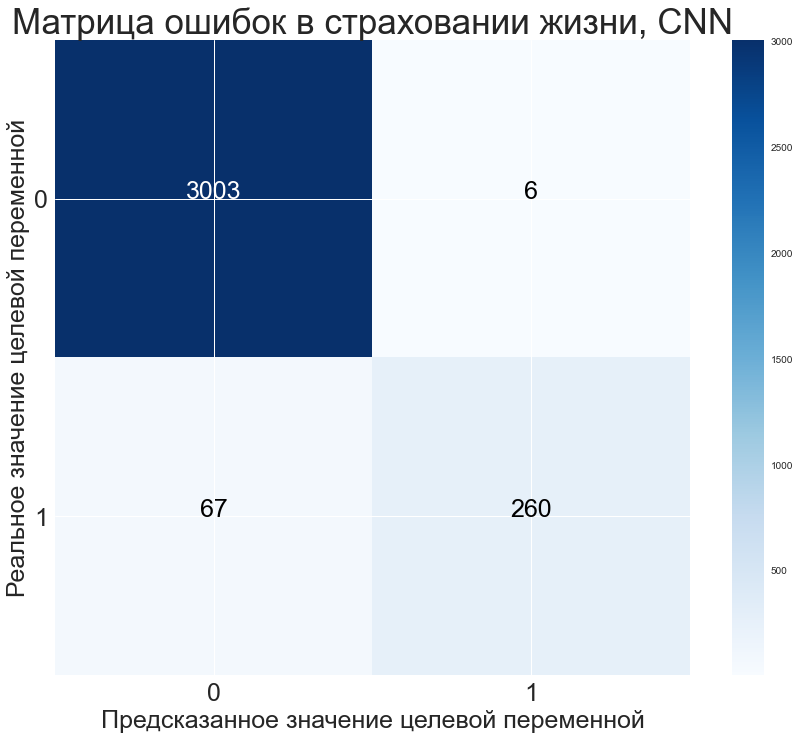

In [2218]:
plot_confusion_matrix(confusion_matrix(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']), classes=set(Pred_Real_table['Real']),
                      title='Матрица ошибок в страховании жизни, CNN')

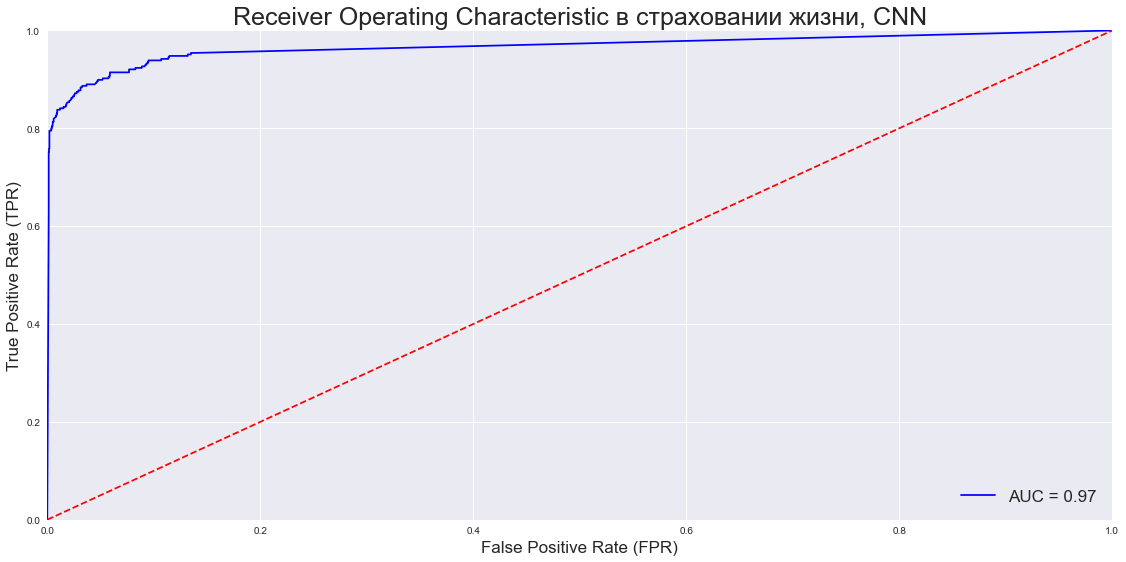

In [2219]:
fpr, tpr, threshold = roc_curve(Pred_Real_table['Real'], Pred_Real_table['Pred'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, CNN', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 17)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 17)
plt.xlabel('False Positive Rate (FPR)', fontsize = 17)
plt.show()

In [2220]:
probs_predicted = text_model.predict(X_TRAIN)
Pred_Real_table_1 = pd.DataFrame(np.append(probs_predicted, Y_TRAIN.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table_1['Real'] = Pred_Real_table_1['Real'].astype('int32')
Pred_Real_table_1['Num_Pred'] = 0
Pred_Real_table_1.loc[Pred_Real_table_1['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
Pred_Real_table_1

316/316 [==============================] - 2s 5ms/step


Pred  Real  Num_Pred
0     0.007     0         0
1     0.007     0         0
2     0.007     0         0
3     0.007     0         0
4     0.007     0         0
...     ...   ...       ...
10100 0.007     0         0
10101 0.007     0         0
10102 0.007     0         0
10103 0.007     0         0
10104 0.007     0         0

[10105 rows x 3 columns]

In [2221]:
X_TRAIN

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [2222]:
accuracy_score(Pred_Real_table_1['Real'], Pred_Real_table_1['Num_Pred'])

0.980801583374567

## Делаем предсказания нейронной сети новой переменной

In [2223]:
pad_sequences(sequences_life_data, maxlen=max_news_len_life_data)

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [2224]:
reviews_with_len = [[review, y[i,0], len(review)] 
for i, review in enumerate(pad_sequences(sequences_life_data, maxlen=max_news_len_life_data))]

#random.shuffle(reviews_with_len)
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
BATCH_SIZE = 32 
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 133), dtype=int32, numpy=
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 4],
        [0, 0, 0, ..., 1, 1, 1]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0])>)

In [2225]:
total_data = batched_dataset
results = text_model.evaluate(total_data)
print(results)

421/421 [==============================] - 3s 7ms/step - loss: 0.0742 - auc_7: 0.9642
[0.0741579681634903, 0.9641684889793396]


In [2226]:
X_TOTAL = np.array(list(total_data.as_numpy_iterator())[0][0])
Y_TOTAL = np.array(list(total_data.as_numpy_iterator())[0][1])
for i in range(len(list(total_data.as_numpy_iterator()))-1):
    X_TOTAL = np.append(X_TOTAL, np.array(list(total_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TOTAL = np.append(Y_TOTAL, np.array(list(total_data.as_numpy_iterator())[i+1][1]), axis=0)

In [2227]:
probs_predicted = text_model.predict(X_TOTAL)
Pred_Real_table = pd.DataFrame(np.append(probs_predicted, Y_TOTAL.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table['Real'] = Pred_Real_table['Real'].astype('int32')

Pred_Real_table['Num_Pred'] = 0
Pred_Real_table.loc[Pred_Real_table['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
accuracy_score(Pred_Real_table['Real'], Pred_Real_table['Num_Pred'])

421/421 [==============================] - 2s 5ms/step


0.9801354065917715

In [2228]:
sum(Pred_Real_table['Num_Pred'])

1003

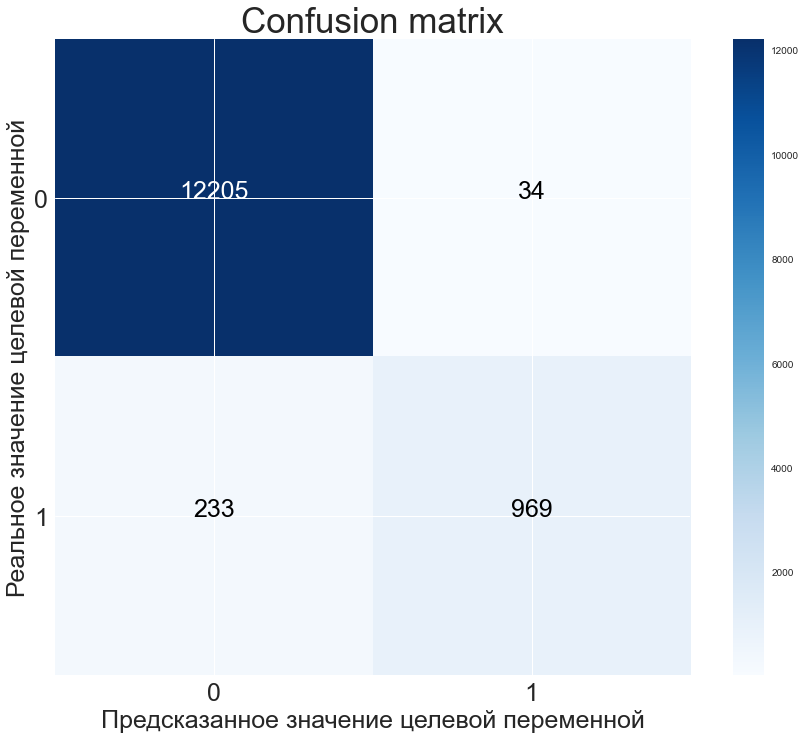

In [2229]:
plot_confusion_matrix(confusion_matrix(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']), classes=set(Pred_Real_table['Real']),
                      title='Confusion matrix')

In [2230]:
df_new = life_data
df_new.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
36776        -0.493          -1.139                   0.160         -0.564   
29530        -0.493          -0.431                   0.160         -0.564   
12596        -0.493          -0.431                   0.160         -0.564   
39802        -0.493          -1.139                   0.160         -0.564   
1142         -0.493          -0.431                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  \
36776      -1.862        -1.025  -0.809               -0.054   
29530      -1.862        -0.796   0.219               -0.054   
12596      -1.862         0.398   0.909               -0.054   
39802      -1.862        -0.796  -0.023               -0.054   
1142       -1.862        -0.796  -0.689               -0.054   

           Страховой риск, по которому произошло событие  CC main program  \
36776  В5-Смерть/Дожитие до очередной выплаты пенсии-...           -0.093   
29530                                   Смерть / Дожитие           -0.093   
12596                                   Смерть / Дожитие           -0.093   
39802  В5-Смерть/Дожитие до очередной выплаты пенсии-...           -0.093   
1142                                    Смерть / Дожитие           -0.093   

       Risk code  Доп. доход Причина случая Тип страх. случая  \
36776     -1.044       1.589        Дожитие           Дожитие   
29530     -1.044       1.074        Дожитие           Дожитие   
12596     -1.044       0.997        Дожитие           Дожитие   
39802     -1.044       0.026        Дожитие           Дожитие   
1142      -1.044       2.241        Дожитие           Дожитие   

       Страховая сумма по риску, в валюте ответственности  \
36776                                             -0.645    
29530                                             -0.306    
12596                                             -0.626    
39802                                             -0.891    
1142                                              -0.627    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
36776                             -0.487                      0.019   
29530                             -0.487                     -0.000   
12596                             -0.487                      0.007   
39802                             -0.487                      0.001   
1142                              -0.487                      0.023   

       РЗУ, в валюте ответственности Описание ЭСС  Доля выгодоприобретателя  \
36776                         -0.060      Дожитие                     0.096   
29530                         -0.060      Дожитие                     0.096   
12596                         -0.060      Дожитие                     0.096   
39802                         -0.060      Дожитие                     0.096   
1142                          -0.060      Дожитие                     0.096   

       СС main programm  \
36776             0.714   
29530             1.607   
12596             0.724   
39802            -0.047   
1142              0.782   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
36776                                             -0.159                                 
29530                                              1.206                                 
12596                                              1.206                                 
39802                                             -0.152                                 
1142                                               3.472                                 

       Кластер  Мошенничество  
36776        1              0  
29530        1              0  
12596        1              0  
39802        1              0  
1142         1              0

In [2231]:
sum(pd.concat([df_new, Pred_Real_table.set_index(df_new.index)], axis=1)['Мошенничество']-pd.concat([df_new, Pred_Real_table.set_index(df_new.index)], axis=1)['Real'])

0

In [2232]:
df_with_txt_pred = pd.concat([df_new, Pred_Real_table[['Pred', 'Num_Pred']].set_index(df_new.index)], axis=1).rename(columns={"Pred": "txt_pred_prob", "Num_Pred": "txt_pred_num"})
df_numeric_life = df_with_txt_pred

text_features = ['Страховой риск, по которому произошло событие', 'Причина случая', 'Тип страх. случая', 'Описание ЭСС']

df_numeric_life.drop(columns=text_features, inplace=True)

df_numeric_life.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
36776        -0.493          -1.139                   0.160         -0.564   
29530        -0.493          -0.431                   0.160         -0.564   
12596        -0.493          -0.431                   0.160         -0.564   
39802        -0.493          -1.139                   0.160         -0.564   
1142         -0.493          -0.431                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  CC main program  \
36776      -1.862        -1.025  -0.809               -0.054           -0.093   
29530      -1.862        -0.796   0.219               -0.054           -0.093   
12596      -1.862         0.398   0.909               -0.054           -0.093   
39802      -1.862        -0.796  -0.023               -0.054           -0.093   
1142       -1.862        -0.796  -0.689               -0.054           -0.093   

       Risk code  Доп. доход  \
36776     -1.044       1.589   
29530     -1.044       1.074   
12596     -1.044       0.997   
39802     -1.044       0.026   
1142      -1.044       2.241   

       Страховая сумма по риску, в валюте ответственности  \
36776                                             -0.645    
29530                                             -0.306    
12596                                             -0.626    
39802                                             -0.891    
1142                                              -0.627    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
36776                             -0.487                      0.019   
29530                             -0.487                     -0.000   
12596                             -0.487                      0.007   
39802                             -0.487                      0.001   
1142                              -0.487                      0.023   

       РЗУ, в валюте ответственности  Доля выгодоприобретателя  \
36776                         -0.060                     0.096   
29530                         -0.060                     0.096   
12596                         -0.060                     0.096   
39802                         -0.060                     0.096   
1142                          -0.060                     0.096   

       СС main programm  \
36776             0.714   
29530             1.607   
12596             0.724   
39802            -0.047   
1142              0.782   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
36776                                             -0.159                                 
29530                                              1.206                                 
12596                                              1.206                                 
39802                                             -0.152                                 
1142                                               3.472                                 

       Кластер  Мошенничество  txt_pred_prob  txt_pred_num  
36776        1              0          0.007             0  
29530        1              0          0.007             0  
12596        1              0          0.007             0  
39802        1              0          0.007             0  
1142         1              0          0.007             0

<AxesSubplot:>

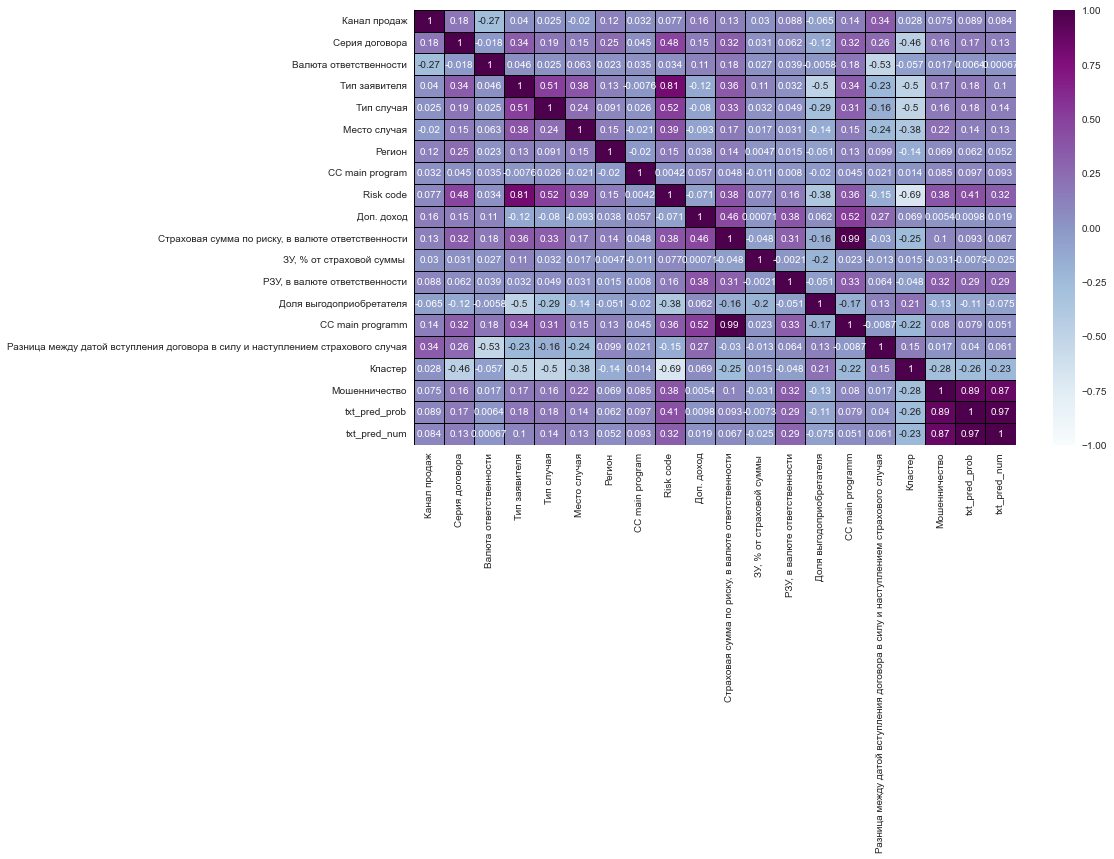

In [2233]:
plt.figure(figsize = (12,8))

sns.heatmap(df_numeric_life.loc[life_indexes_train].corr().dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1, linecolor='black', cmap='BuPu')

In [2234]:
X_train_life = df_numeric_life.loc[life_indexes_train].drop(columns=['Мошенничество'])
X_test_life = df_numeric_life.loc[life_indexes_test].drop(columns=['Мошенничество'])
y_train_life = df_numeric_life.loc[life_indexes_train]['Мошенничество']
y_test_life = df_numeric_life.loc[life_indexes_test]['Мошенничество']

In [2235]:
logistic = LogisticRegression(C=0.5, penalty = 'l2', max_iter=10000, n_jobs=-1)
logistic.fit(X_train_life, y_train_life)
logistic.score(X_test_life, y_test_life)

0.9804096170970614

In [2236]:
print(classification_report(y_test_life, logistic.predict(X_test_life)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3041
           1       0.96      0.83      0.89       328

    accuracy                           0.98      3369
   macro avg       0.97      0.91      0.94      3369
weighted avg       0.98      0.98      0.98      3369



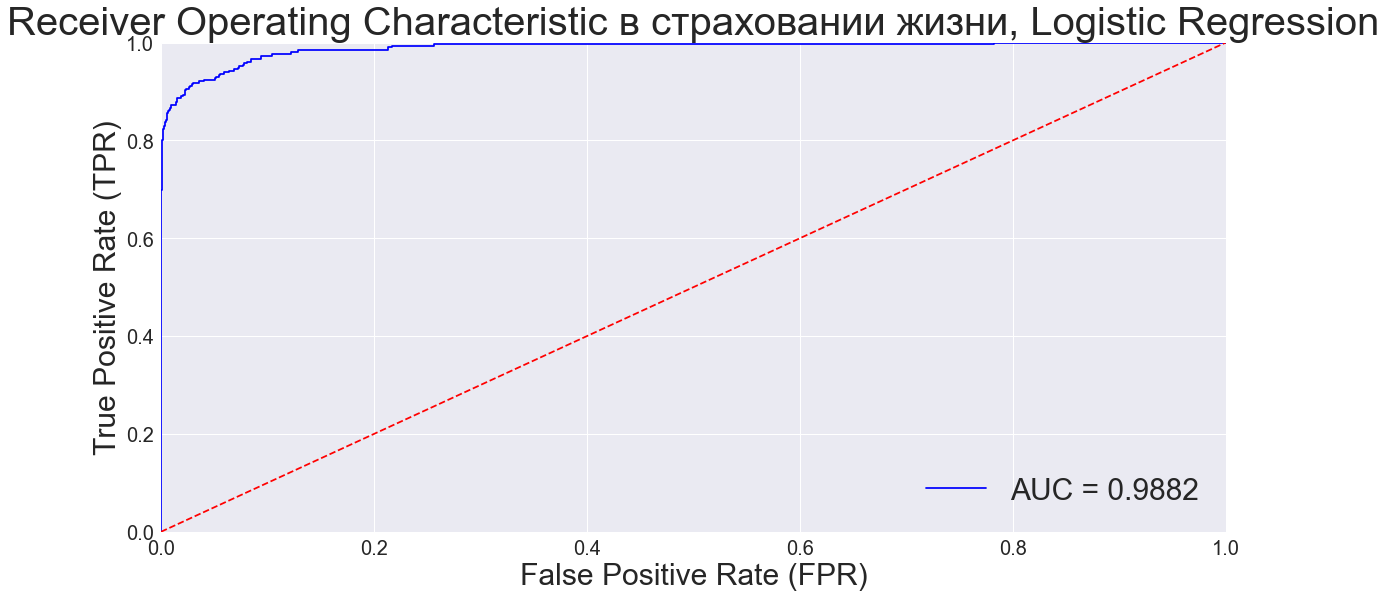

In [2237]:
fpr, tpr, threshold = roc_curve(y_test_life, logistic.predict_proba(X_test_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, Logistic Regression', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

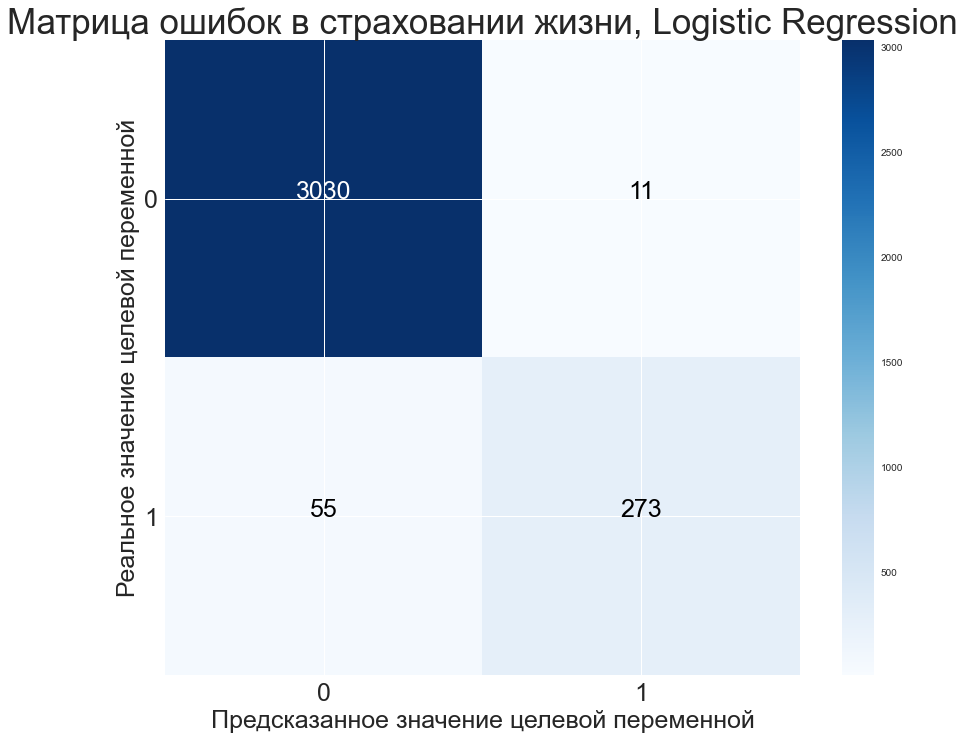

In [2238]:
plot_confusion_matrix(confusion_matrix(y_test_life, logistic.predict(X_test_life)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, Logistic Regression')

In [2239]:
svm = SVC(kernel='rbf', gamma='scale', C=100, probability=True)
svm.fit(X_train_life, y_train_life)

svm.score(X_test_life, y_test_life)

0.9801127931136836

In [2240]:
print(classification_report(y_test_life, svm.predict(X_test_life)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3041
           1       0.95      0.84      0.89       328

    accuracy                           0.98      3369
   macro avg       0.96      0.92      0.94      3369
weighted avg       0.98      0.98      0.98      3369



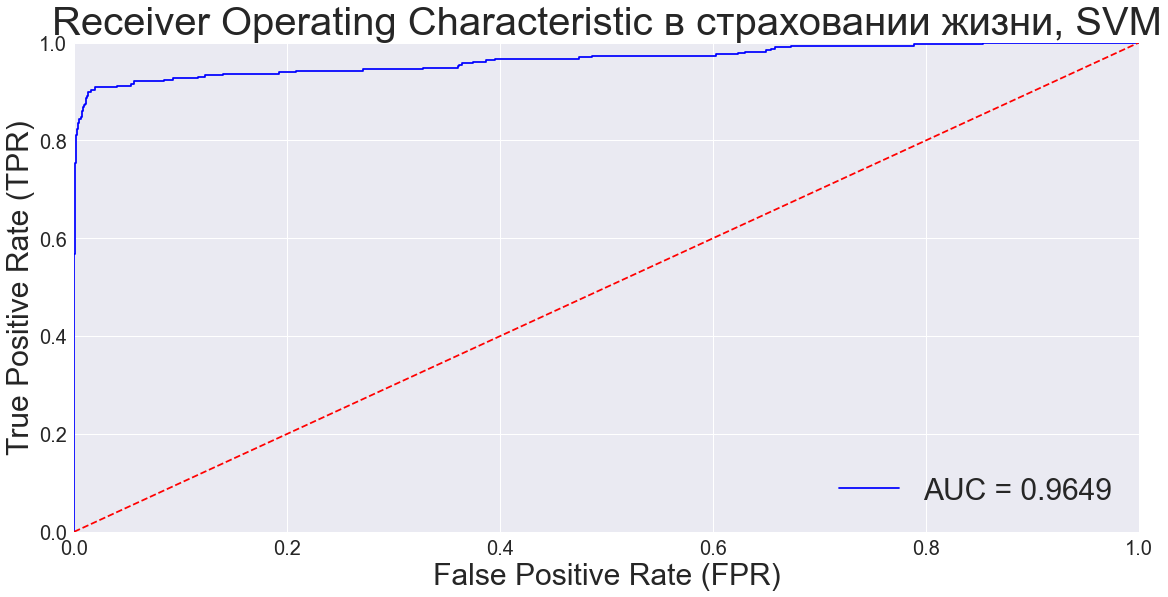

In [2241]:
fpr, tpr, threshold = roc_curve(y_test_life, svm.predict_proba(X_test_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, SVM', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

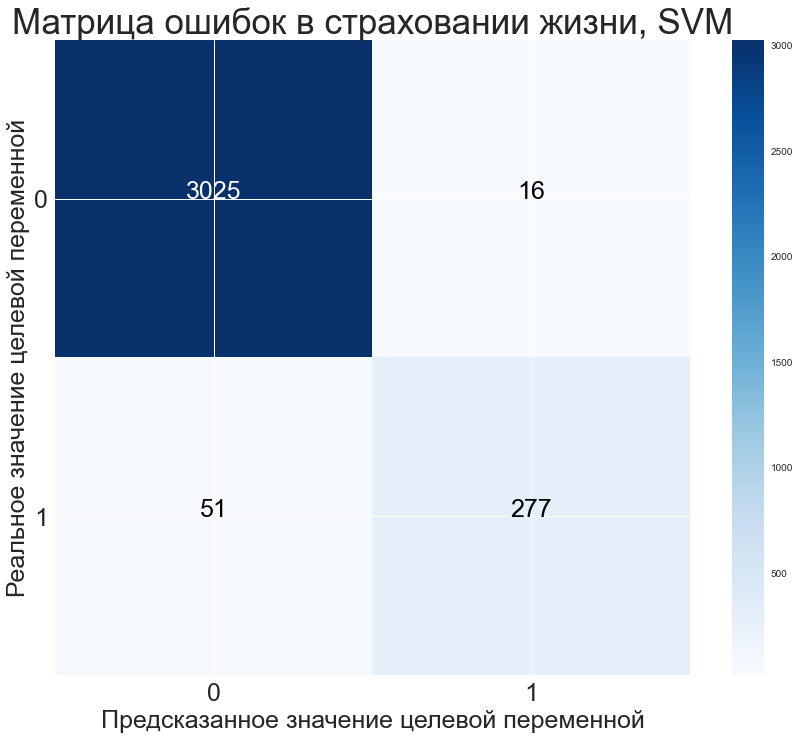

In [2242]:
plot_confusion_matrix(confusion_matrix(y_test_life, svm.predict(X_test_life)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, SVM')

In [2243]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train_life, y_train_life)
lda.score(X_test_life, y_test_life)

0.9783318492134164

In [2244]:
lda.coef_

array([[ 1.26545085e-02,  2.39633782e-01,  1.81072256e-01,
        -1.89335568e+00, -1.05367624e+00,  2.83954847e+00,
        -7.52815487e-02, -1.74082970e-13,  2.67427625e-02,
        -9.82412884e-01, -1.29538837e-01,  1.32109719e+01,
         1.08246745e-15, -4.09621902e-01,  1.27514929e+00,
        -5.85308769e-01, -4.87933063e+00,  2.80323931e-01,
        -5.53722371e+00,  7.50582692e+01, -4.78327876e+00]])

In [2245]:
lda.means_

array([[-0.03952567, -0.70469446, -0.33109138, -0.43410596, -1.7694    ,
        -0.57648535, -0.12095049, -0.05377088,  0.06116847, -0.73605652,
         0.61163247, -0.68398784, -0.48727257,  0.02616906, -0.00214453,
        -0.18487404,  0.55743897,  0.80849685,  0.97445097,  0.01914426,
         0.00304414],
       [ 0.23953297, -0.35212115, -0.22852425, -0.20863631, -1.47472252,
         0.00952391,  0.09323961, -0.05377088,  0.49264559,  0.64608307,
         0.64918612, -0.51014867, -0.48727257, -0.00501638,  1.61124835,
        -1.05082708,  0.94663473,  0.88012559,  0.76887872,  0.79501544,
         0.81121281]])

In [2246]:
print(classification_report(y_test_life, lda.predict(X_test_life)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3041
           1       0.96      0.81      0.88       328

    accuracy                           0.98      3369
   macro avg       0.97      0.90      0.93      3369
weighted avg       0.98      0.98      0.98      3369



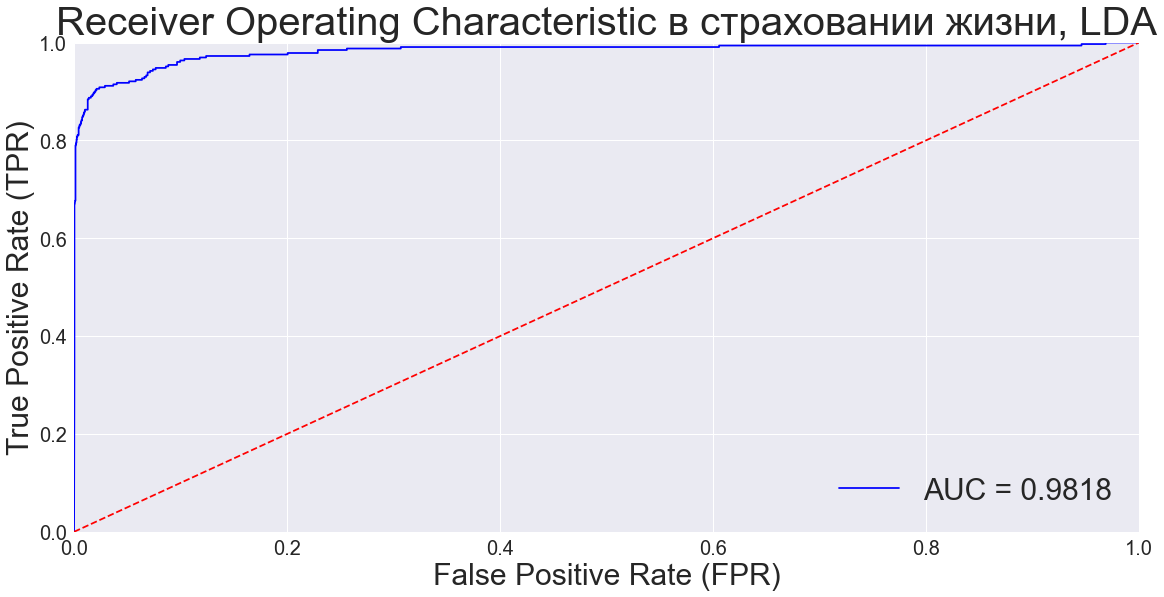

In [2247]:
fpr, tpr, threshold = roc_curve(y_test_life, lda.predict_proba(X_test_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, LDA', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

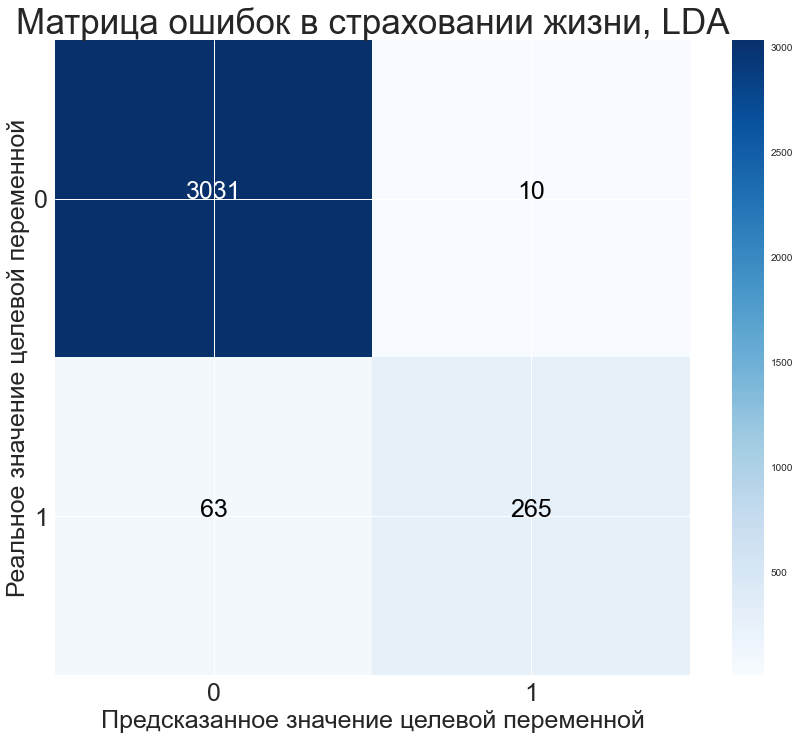

In [2248]:
plot_confusion_matrix(confusion_matrix(y_test_life, lda.predict(X_test_life)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, LDA')

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

GBC_class_pipe = Pipeline([('GBC_class', GradientBoostingClassifier(n_estimators=3000, tol=1e-5, n_iter_no_change=100, random_state=911))]) #сюда можно ещё скелер добавить

params_GBC_class = {'GBC_class__max_depth': [2],
                   'GBC_class__loss': ['deviance'],
                   'GBC_class__subsample': [0.5],
                   'GBC_class__learning_rate': [0.01],
                   'GBC_class__min_samples_split': [2],
                   'GBC_class__min_samples_leaf': [9]
                   }

grid_GBC_class = GridSearchCV(GBC_class_pipe, params_GBC_class, cv=4, scoring='roc_auc')
grid_GBC_class.fit(x_train, y_train)

print('Используемые гиперпараметры GBC_class:', grid_GBC_class.best_params_)

In [2380]:
params = {
    "n_estimators": 1500,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.5,
    'verbose': 1,
    'min_samples_leaf': 9,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'deviance'
}
GBC = GradientBoostingClassifier(**params)
GBC.fit(X_train_life, y_train_life)

accuracy_score(y_test_life, GBC.predict(X_test_life))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5725           0.0162           11.99s
         2           0.5634           0.0147           11.99s
         3           0.5625           0.0132           11.98s
         4           0.5352           0.0119           11.97s
         5           0.5240           0.0116           10.77s
         6           0.5000           0.0110           10.96s
         7           0.5004           0.0097           11.14s
         8           0.4907           0.0094           11.24s
         9           0.4692           0.0089           10.64s
        10           0.4655           0.0087           10.73s
        20           0.3973           0.0060            9.77s
        30           0.3502           0.0040            9.41s
        40           0.3214           0.0033            9.35s
        50           0.2841           0.0028            9.28s
        60           0.2553           0.0023            9.06s
       

0.9824873849807064

In [2454]:
print(X_train_life.columns)

Index(['Канал продаж', 'Серия договора', 'Валюта ответственности',
       'Тип заявителя', 'Тип случая', 'Место случая', 'Регион',
       'Группа инвалидности', 'CC main program', 'Risk code', 'Доп. доход',
       'Страховая сумма по риску, в валюте ответственности',
       'Оплаченные дни нетрудоспособности', 'ЗУ, % от страховой суммы ',
       'РЗУ, в валюте ответственности', 'Доля выгодоприобретателя',
       'СС main programm',
       'Разница между датой вступления договора в силу и наступлением страхового случая',
       'Кластер', 'txt_pred_prob', 'txt_pred_num'],
      dtype='object')


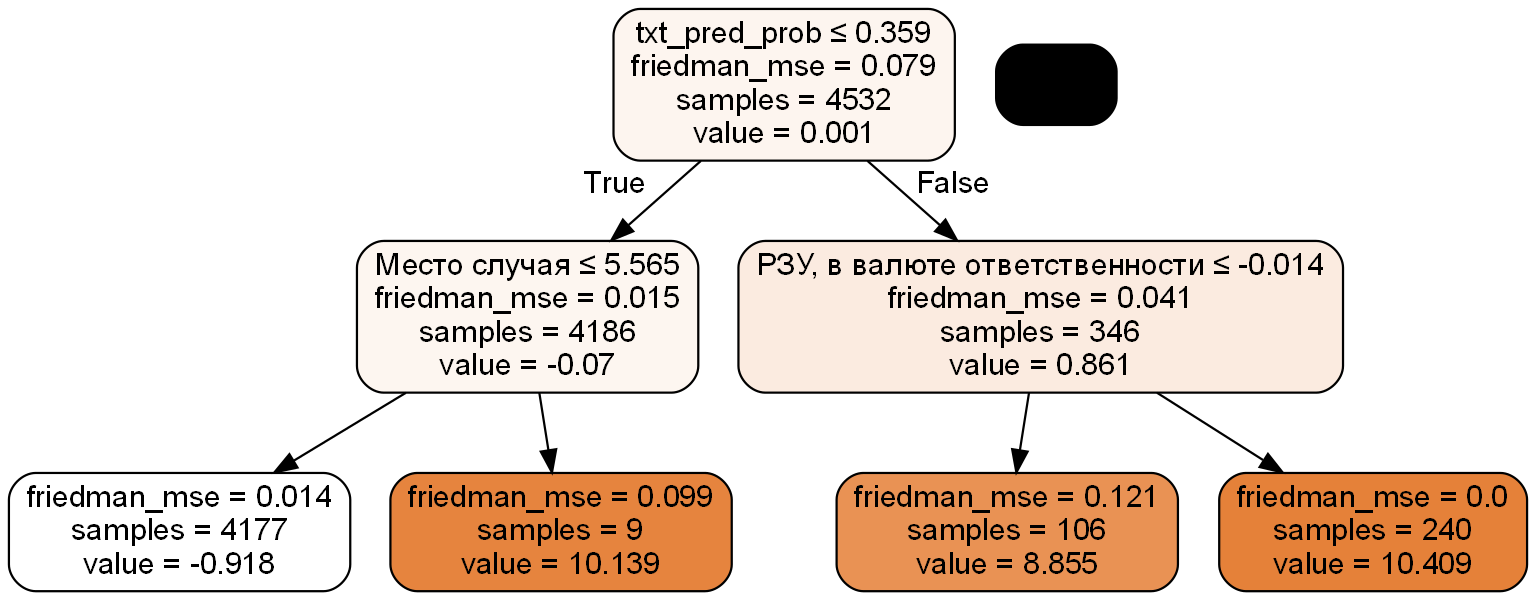

In [2441]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn import tree

estimator = GBC.estimators_[1][0]

# Строим график дерева
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train_life.columns, class_names=list(map(str, GBC.classes_)), filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"16,30!"')
#graph.set('node', fontname='Arial')
#graph.set('node', size='50')
Image(graph.create_png())

In [2381]:
print(classification_report(y_test_life, GBC.predict(X_test_life)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3041
           1       0.93      0.88      0.91       328

    accuracy                           0.98      3369
   macro avg       0.96      0.94      0.95      3369
weighted avg       0.98      0.98      0.98      3369



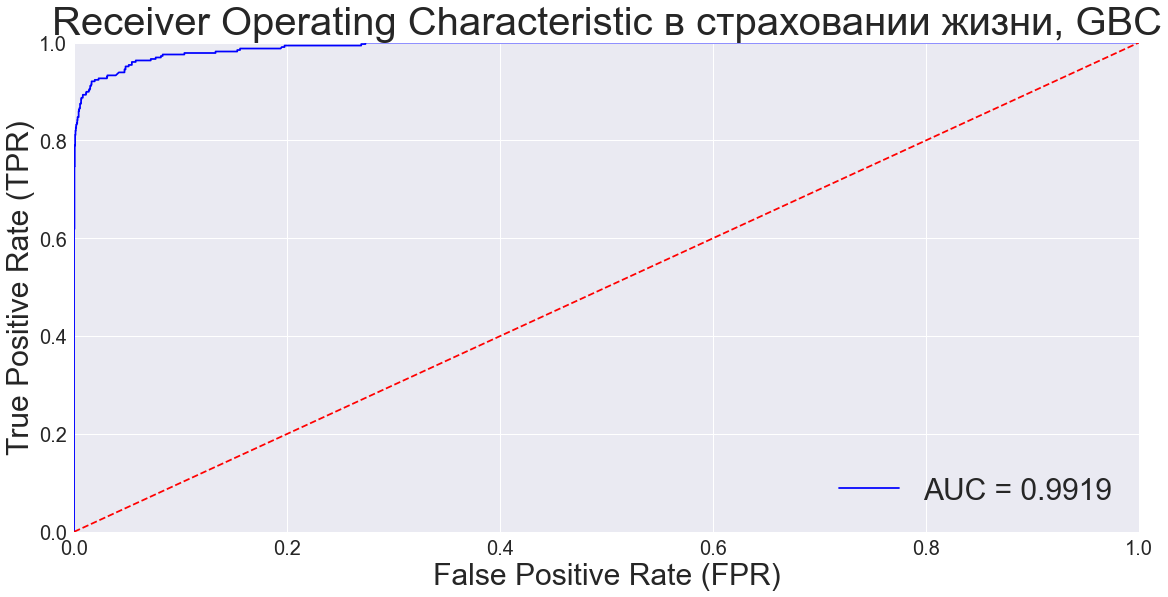

In [2251]:
fpr, tpr, threshold = roc_curve(y_test_life, GBC.predict_proba(X_test_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, GBC', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

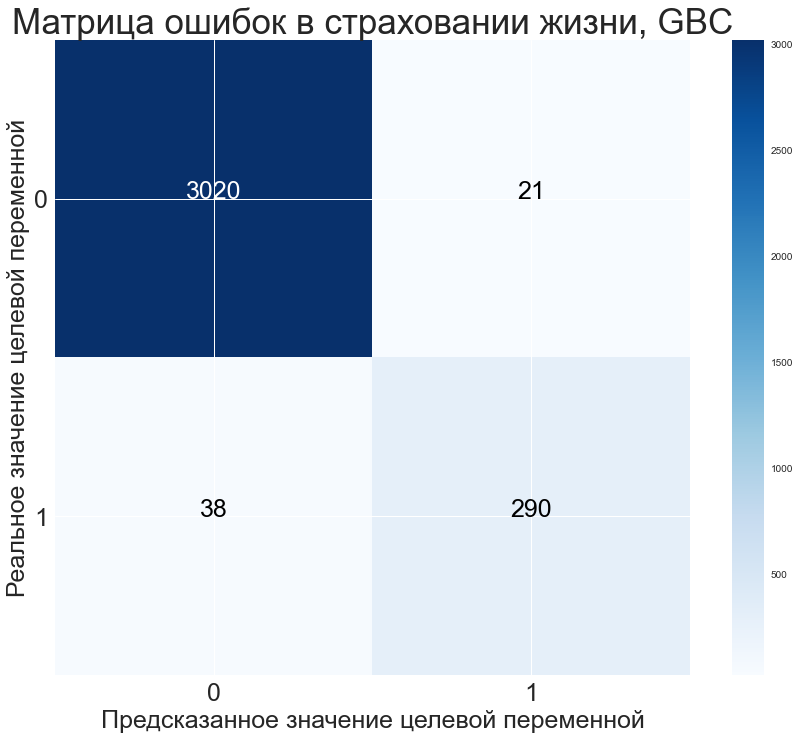

In [2252]:
plot_confusion_matrix(confusion_matrix(y_test_life, GBC.predict(X_test_life)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, GBC')

In [2455]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=911, n_estimators=2000, oob_score=True, bootstrap=True, criterion='entropy', verbose=1, n_jobs=-1)
clf.fit(X_train_life, y_train_life)

accuracy_score(y_test_life, clf.predict(X_test_life))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_job

0.9780350252300386

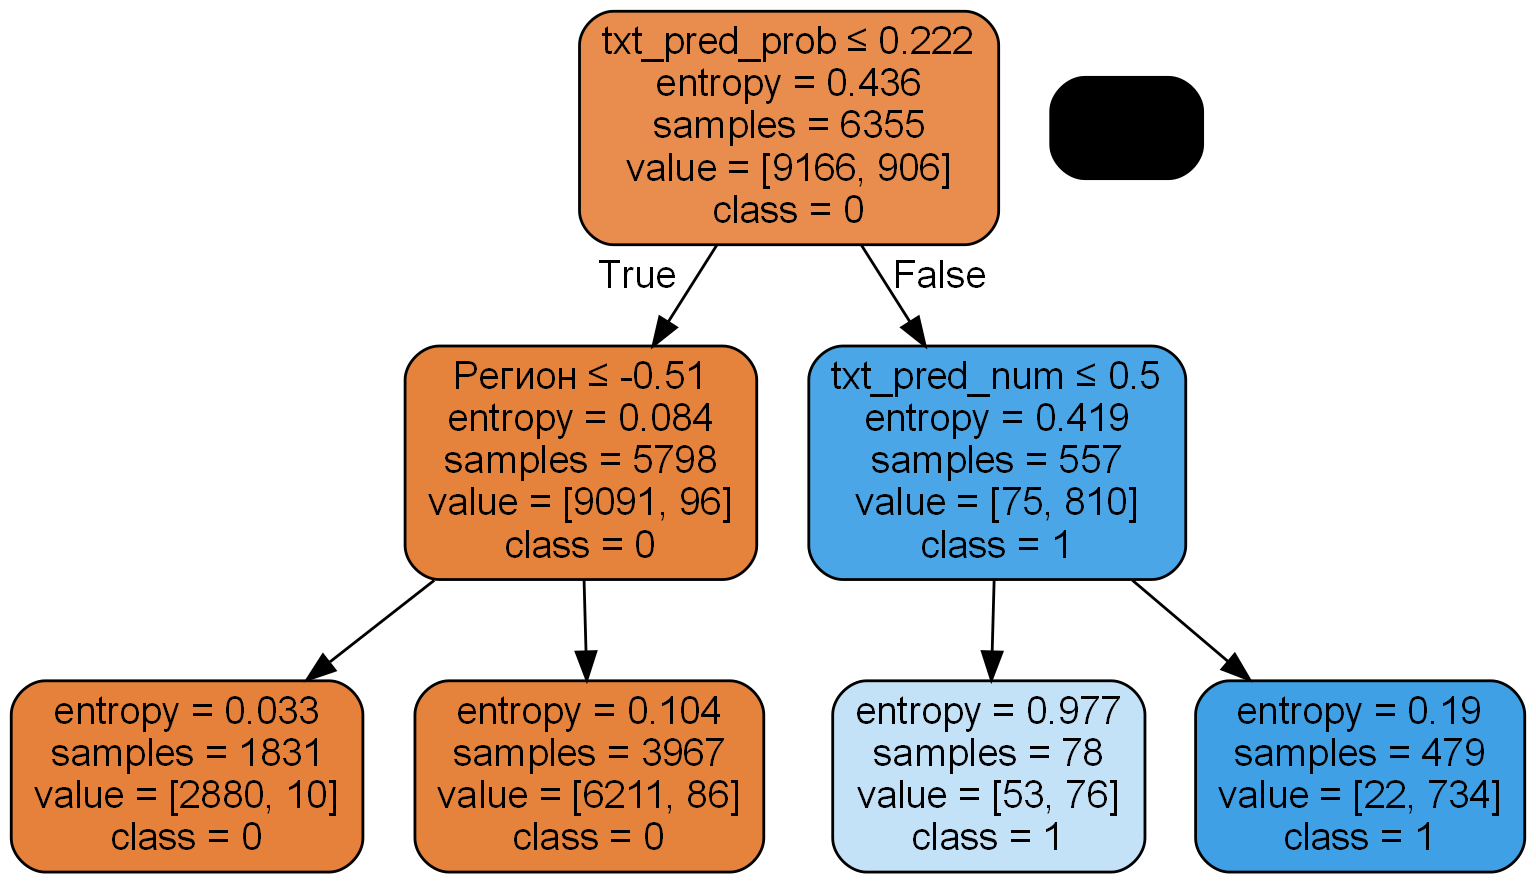

In [2457]:
estimator = clf.estimators_[2]

# Строим график дерева
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train_life.columns, class_names=list(map(str, clf.classes_)), filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"16,30!"')
#graph.set('node', fontname='Arial')
#graph.set('node', size='50')
Image(graph.create_png())

In [2254]:
print(classification_report(y_test_life, clf.predict(X_test_life)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3041
           1       0.98      0.81      0.88       328

    accuracy                           0.98      3369
   macro avg       0.98      0.90      0.94      3369
weighted avg       0.98      0.98      0.98      3369



[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.2s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.2s finished


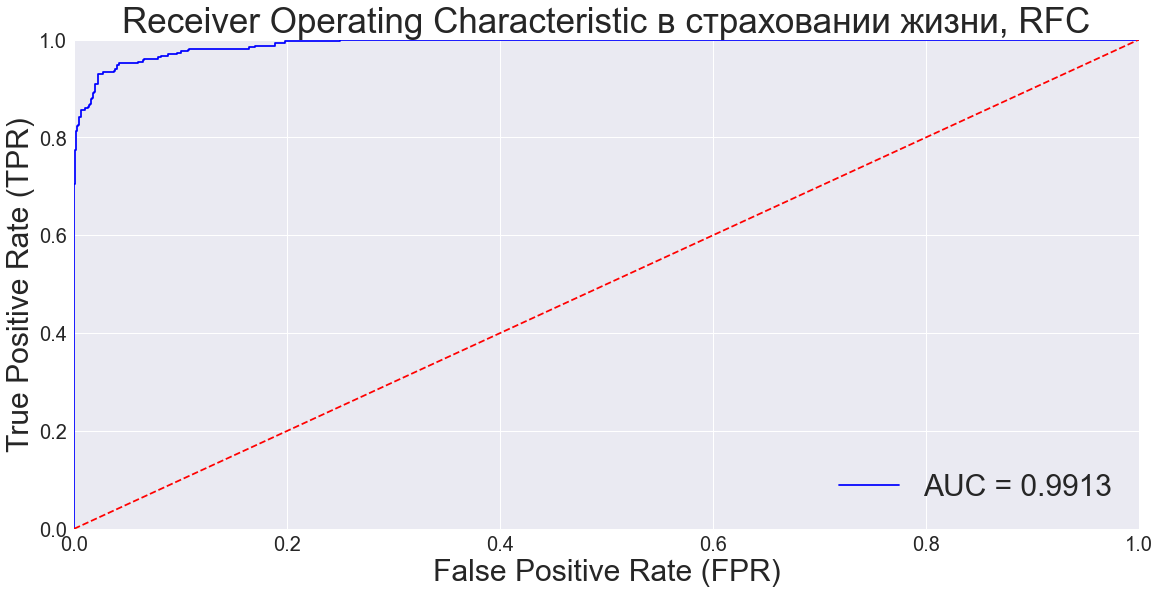

In [2255]:
fpr, tpr, threshold = roc_curve(y_test_life, clf.predict_proba(X_test_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, RFC', fontsize = 35)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.3s finished


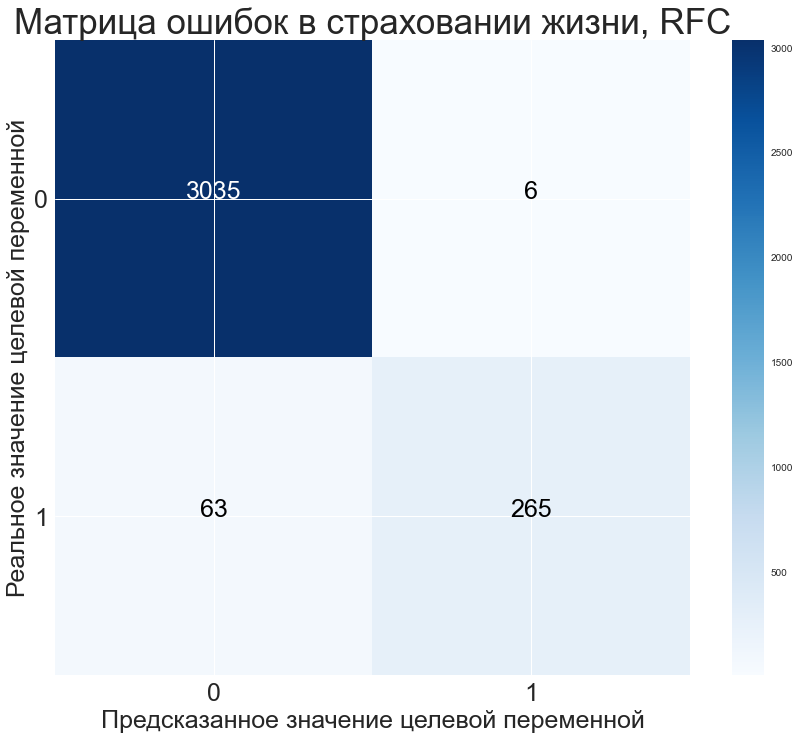

In [2256]:
plot_confusion_matrix(confusion_matrix(y_test_life, clf.predict(X_test_life)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, RFC')

X1.rename({'Разница между датой вступления договора в силу и наступлением страхового случая': 'Кол-во дн. меж. заключ. дог. и страх. случ.', 
                   'Страховой риск, по которому произошло событие': 'Страх. риск, по кот. произ. соб.', 
                   'Размер страховой выплаты в валюте ответственности': 'Разм. страх. выплаты в вал. отв.', 
                   'Страховая сумма по риску, в валюте ответственности': 'Страх. сум. по риску, в вал. отв.'}, inplace=True, axis=1)

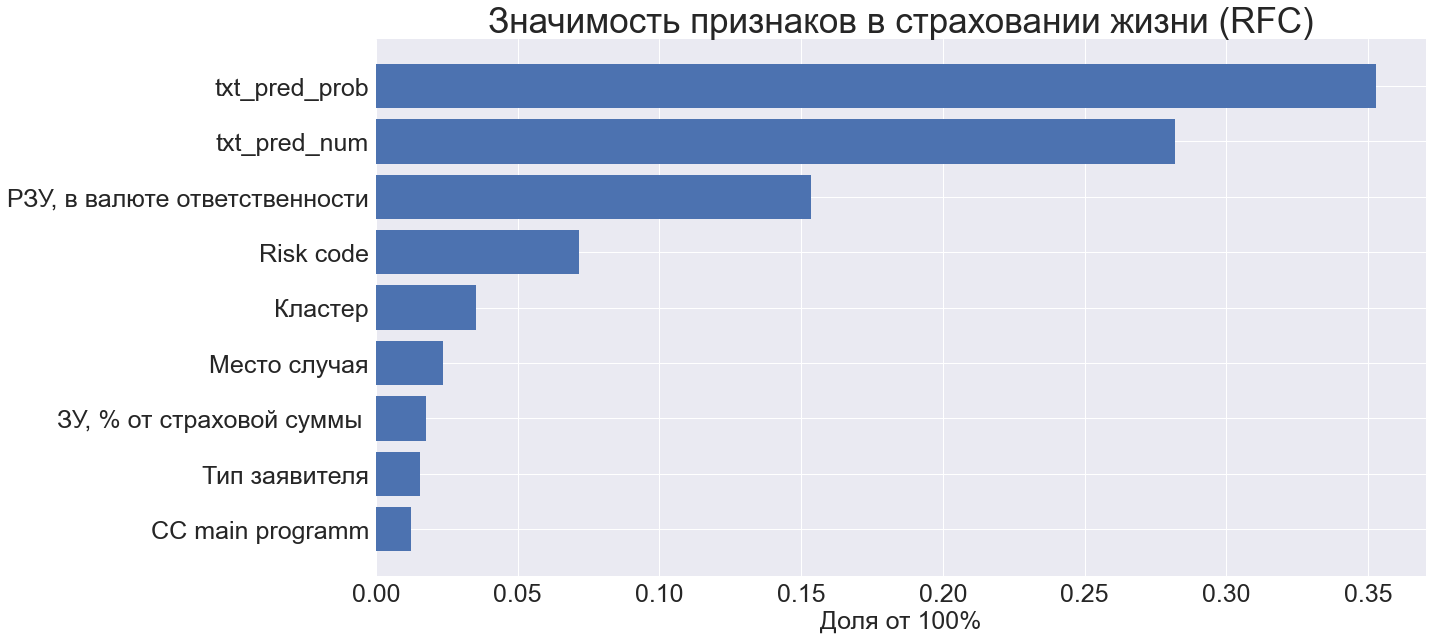

In [2257]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
a = feature_importance[sorted_idx]
b = np.array(X_test_life.rename({'Разница между датой вступления договора в силу и наступлением страхового случая': 'Кол-во дн. меж. заключ. дог. и страх. случ.', 
                   'Страховой риск, по которому произошло событие': 'Страх. риск, по кот. произ. соб.', 
                   'Размер страховой выплаты в валюте ответственности': 'Разм. страх. выплаты в вал. отв.', 
                   'Страховая сумма по риску, в валюте ответственности': 'Страх. сум. по риску, в вал. отв.'}, inplace=False, axis=1).columns)[sorted_idx]
lenth = len(np.vstack((a,b))[0][np.vstack((a,b))[0] >= 0.01])
pos = np.arange(lenth) + .5
fig = plt.figure(figsize=(20, 9))

plt.barh(pos, np.vstack((a,b))[0][np.vstack((a,b))[0] >= 0.01], align='center')
plt.yticks(pos, np.vstack((a,b))[1][np.vstack((a,b))[0] >= 0.01], fontsize = 25)
plt.title('Значимость признаков в страховании жизни (RFC)', fontsize = 35)
#result = permutation_importance(clf, X_train, target_train['Slopeprecioalc'], n_repeats=10,
                                #random_state=911, n_jobs=2)
#sorted_idx = result.importances_mean.argsort()
plt.xlabel('Доля от 100%', fontsize = 25)
plt.xticks(fontsize = 25)
fig.tight_layout()
plt.show()

### Прогон без результатов нейронной сети

In [2444]:
X_train_life_dropped = X_train_life.drop(axis=1, columns=['txt_pred_prob', 'txt_pred_num'])
X_test_life_dropped = X_test_life.drop(axis=1, columns=['txt_pred_prob', 'txt_pred_num'])


params = {
    "n_estimators": 100,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.5,
    'verbose': 1,
    'min_samples_leaf': 9,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'deviance'
}
GBC = GradientBoostingClassifier(**params)
GBC.fit(X_train_life_dropped, y_train_life)

GBC.predict(X_test_life_dropped)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5796           0.0095            0.79s
         2           0.5759           0.0085            0.79s
         3           0.5812           0.0077            0.78s
         4           0.5591           0.0076            0.67s
         5           0.5516           0.0071            0.68s
         6           0.5309           0.0068            0.69s
         7           0.5387           0.0065            0.64s
         8           0.5295           0.0060            0.64s
         9           0.5086           0.0058            0.65s
        10           0.5109           0.0058            0.61s
        20           0.4585           0.0039            0.53s
        30           0.4319           0.0029            0.44s
        40           0.4093           0.0022            0.37s
        50           0.3804           0.0023            0.31s
        60           0.3584           0.0014            0.24s
       

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [2373]:
print(classification_report(y_test_life, GBC.predict(X_test_life_dropped)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      3041
           1       0.98      0.35      0.51       328

    accuracy                           0.94      3369
   macro avg       0.96      0.67      0.74      3369
weighted avg       0.94      0.94      0.92      3369



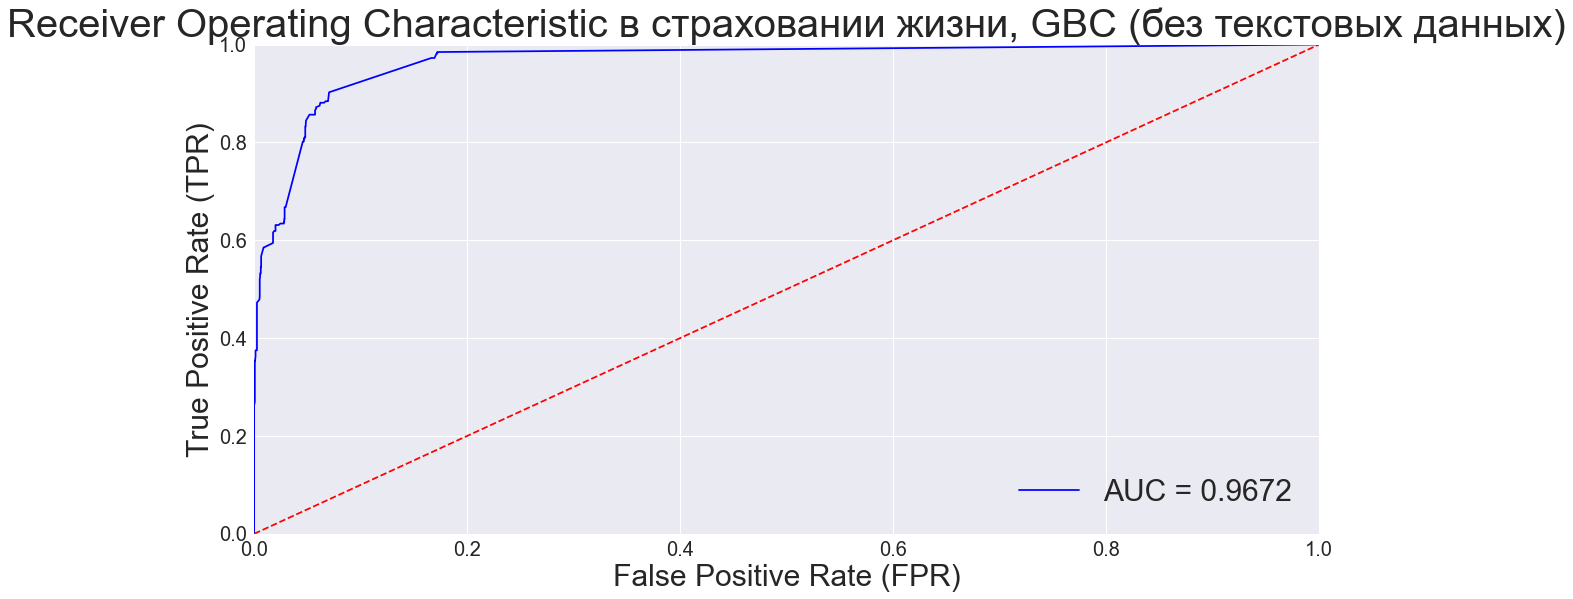

In [2374]:
fpr, tpr, threshold = roc_curve(y_test_life, GBC.predict_proba(X_test_life_dropped)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, GBC (без текстовых данных)', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

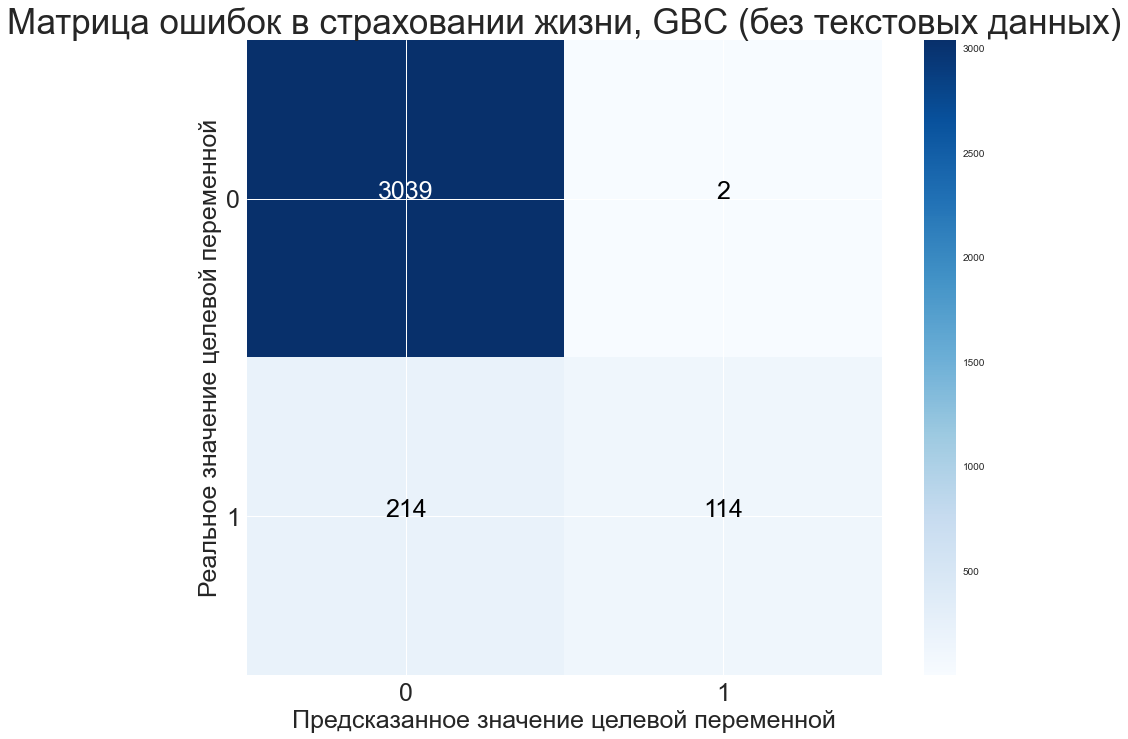

In [2375]:
plot_confusion_matrix(confusion_matrix(y_test_life, GBC.predict(X_test_life_dropped)), classes=set(y_test_life),
                      title='Матрица ошибок в страховании жизни, GBC (без текстовых данных)')

### Non-life

In [2262]:
nb_classes = 2

y = utils.to_categorical(txt_non_life_data['Мошенничество'] - 1, nb_classes)

In [2263]:
reviews_with_len = [[review, y[i,0], len(review)] 
for i, review in enumerate(pad_sequences(sequences_non_life_data, maxlen=max_news_len_non_life_data))]

#random.shuffle(reviews_with_len)
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

processed_dataset_train = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels[0:30657], output_types=(tf.int32, tf.int32)) # тут специально ошибка
processed_dataset_test = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels[30657:], output_types=(tf.int32, tf.int32))
BATCH_SIZE = 32 
batched_dataset_train = processed_dataset_train.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
batched_dataset_test = processed_dataset_test.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset_train))

(<tf.Tensor: shape=(32, 163), dtype=int32, numpy=
 array([[  0,   0,   0, ...,  17,   7,  11],
        [  0,   0,   0, ...,  12,  14,  50],
        [  0,   0,   0, ...,   1,   1,  20],
        ...,
        [  0,   0,   0, ...,  16, 260, 130],
        [  0,   0,   0, ...,  13,   4,   9],
        [  0,   0,   0, ..., 251,  73,  89]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0])>)

In [2264]:
l = 0
for i in range(len(sorted_reviews_labels)):
    if len(sorted_reviews_labels[i][0]) > l:
        l = len(sorted_reviews_labels[i][0])
l

163

In [2265]:
train_data = batched_dataset_train 
test_data = batched_dataset_test

In [2266]:
class TEXT_MODEL(tf.keras.Model): 

    def __init__(self, 
        vocabulary_size, embedding_dimensions=128, cnn_filters=50, dnn_units=512, model_output_classes=2, dropout_rate=0.1, training=False, name="text_model"): 
        super(TEXT_MODEL, self).__init__(name=name) 

        self.embedding = layers.Embedding(vocabulary_size, embedding_dimensions) 
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters, kernel_size=2, padding="valid", activation="relu") 
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters, kernel_size=3, padding="valid", activation="relu") 
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters, kernel_size=4, padding="valid", activation="relu") 
        self.pool = layers.GlobalMaxPool1D() 

        self.dense_1 = layers.Dense(units=dnn_units, activation="relu") 
        self.dropout = layers.Dropout(rate=dropout_rate) 
        if model_output_classes == 2: 
            self.last_dense = layers.Dense(units=1, activation="sigmoid") 
        else: 
            self.last_dense = layers.Dense(units=model_output_classes, activation="softmax") 

    def call(self, inputs, training): 
        l = self.embedding(inputs) 
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2) 
        l_3 = self.cnn_layer3(l) 
        l_3 = self.pool(l_3) 

        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters) 
        concatenated = self.dense_1(concatenated) 
        concatenated = self.dropout(concatenated, training) 
        model_output = self.last_dense(concatenated) 

        return model_output 

In [2267]:
VOCAB_LENGTH = 1024 
EMB_DIM = max_news_len_non_life_data 
CNN_FILTERS = 100 
DNN_UNITS = 256 
OUTPUT_CLASSES = 2 
DROPOUT_RATE = 0.2
NB_EPOCHS = 15

text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH, embedding_dimensions=EMB_DIM, cnn_filters=CNN_FILTERS, dnn_units=DNN_UNITS, model_output_classes=OUTPUT_CLASSES, dropout_rate=DROPOUT_RATE)

if OUTPUT_CLASSES == 2: 
    text_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00003), 
              loss='binary_crossentropy', 
              metrics=['AUC']) 
else: 
    text_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"]) 

In [2268]:
text_model.build(input_shape=(None, 10))
text_model.summary()

Model: "text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    multiple                  166912    
                                                                 
 conv1d_15 (Conv1D)          multiple                  32700     
                                                                 
 conv1d_16 (Conv1D)          multiple                  49000     
                                                                 
 conv1d_17 (Conv1D)          multiple                  65300     
                                                                 
 global_max_pooling1d_5 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            multiple                  77056     
                                                        

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = text_model.fit(
    train_data,
    epochs=7,
    validation_data=test_data,
    callbacks=[tensorboard_callback]
)

%tensorboard --logdir logs/fit

In [2269]:
text_model.fit(train_data, epochs=NB_EPOCHS, validation_data=test_data) 

Epoch 1/15
959/959 [==============================] - 31s 32ms/step - loss: 0.4201 - auc: 0.6909 - val_loss: 0.3727 - val_auc: 0.7386
Epoch 2/15
959/959 [==============================] - 31s 32ms/step - loss: 0.3457 - auc: 0.7588 - val_loss: 0.3583 - val_auc: 0.7492
Epoch 3/15
959/959 [==============================] - 30s 32ms/step - loss: 0.3359 - auc: 0.7720 - val_loss: 0.3545 - val_auc: 0.7570
Epoch 4/15
959/959 [==============================] - 31s 32ms/step - loss: 0.3306 - auc: 0.7829 - val_loss: 0.3525 - val_auc: 0.7614
Epoch 5/15
959/959 [==============================] - 30s 32ms/step - loss: 0.3269 - auc: 0.7915 - val_loss: 0.3509 - val_auc: 0.7645
Epoch 6/15
959/959 [==============================] - 30s 31ms/step - loss: 0.3232 - auc: 0.7991 - val_loss: 0.3498 - val_auc: 0.7662
Epoch 7/15
959/959 [==============================] - 30s 32ms/step - loss: 0.3199 - auc: 0.8057 - val_loss: 0.3500 - val_auc: 0.7673
Epoch 8/15
959/959 [==============================] - 30s 31ms

In [2270]:
results = text_model.evaluate(test_data)
print(results)

454/454 [==============================] - 4s 8ms/step - loss: 0.3525 - auc: 0.7660
[0.35251912474632263, 0.7660155892372131]


In [2271]:
X_TEST = np.array(list(test_data.as_numpy_iterator())[0][0])
Y_TEST = np.array(list(test_data.as_numpy_iterator())[0][1])
for i in range(len(list(test_data.as_numpy_iterator()))-1):
    X_TEST = np.append(X_TEST, np.array(list(test_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TEST = np.append(Y_TEST, np.array(list(test_data.as_numpy_iterator())[i+1][1]), axis=0)
      
X_TRAIN = np.array(list(train_data.as_numpy_iterator())[0][0])
Y_TRAIN = np.array(list(train_data.as_numpy_iterator())[0][1])
for i in range(len(list(train_data.as_numpy_iterator()))-1):
    X_TRAIN = np.append(X_TRAIN, np.array(list(train_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TRAIN = np.append(Y_TRAIN, np.array(list(train_data.as_numpy_iterator())[i+1][1]), axis=0)
    #print(i)

In [2272]:
probs_predicted = text_model.predict(X_TEST)
Pred_Real_table = pd.DataFrame(np.append(probs_predicted, Y_TEST.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table['Real'] = Pred_Real_table['Real'].astype('int32')
Pred_Real_table['Num_Pred'] = 0
Pred_Real_table

454/454 [==============================] - 3s 6ms/step


Pred  Real  Num_Pred
0     0.993     1         0
1     0.074     0         0
2     0.136     0         0
3     0.063     0         0
4     0.074     0         0
...     ...   ...       ...
14509 0.097     0         0
14510 0.114     0         0
14511 0.048     0         0
14512 0.058     0         0
14513 0.027     1         0

[14514 rows x 3 columns]

In [2273]:
f1_list = []
i_list = []
def find_best(i, ):
    Pred_Real_table['Num_Pred'] = 0
    Pred_Real_table.loc[Pred_Real_table['Pred'] >= i, 'Num_Pred'] = 1
    global f1_list
    global i_list
    f1_list.append(f1_score(Pred_Real_table['Real'], Pred_Real_table['Num_Pred'], average='binary'))
    i_list.append(i)
    
for i in np.arange(0, 1, 0.001):
    find_best(i=i)

    
Pred_Real_table['Num_Pred'] = 0
Pred_Real_table.loc[Pred_Real_table['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
accuracy_score(Pred_Real_table['Real'], Pred_Real_table['Num_Pred'])

0.8422213035689678

In [2274]:
print(classification_report(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     11999
           1       0.55      0.46      0.50      2515

    accuracy                           0.84     14514
   macro avg       0.72      0.69      0.70     14514
weighted avg       0.83      0.84      0.84     14514



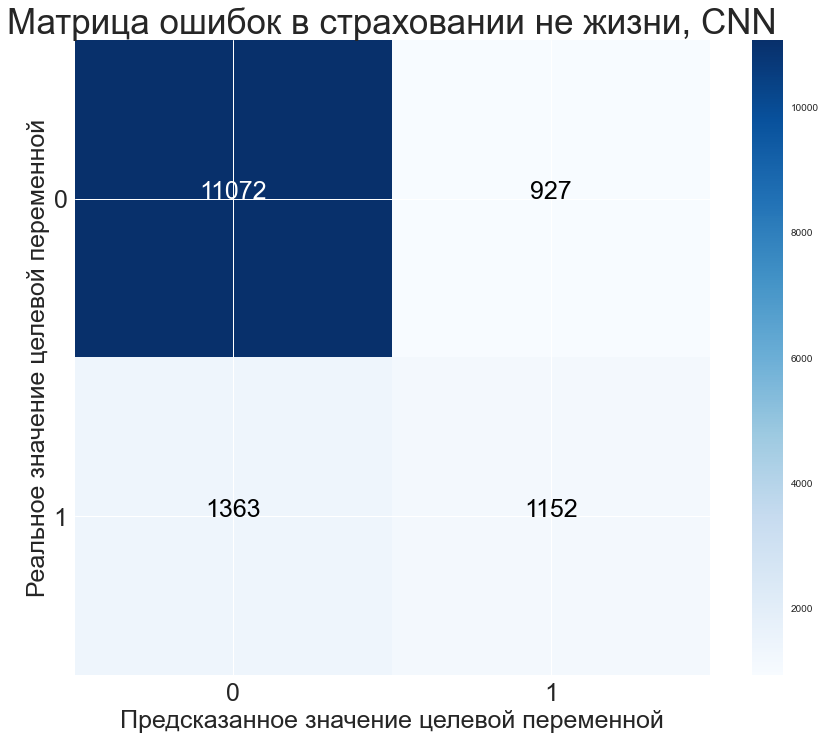

In [2275]:
plot_confusion_matrix(confusion_matrix(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']), classes=set(Pred_Real_table['Real']),
                      title='Матрица ошибок в страховании не жизни, CNN')

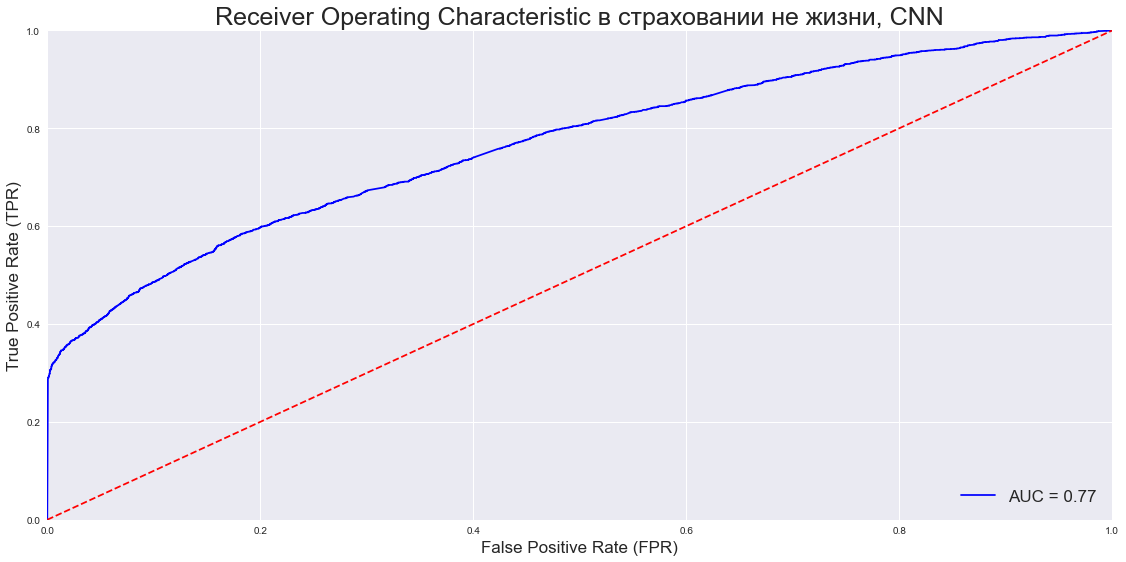

In [2276]:
fpr, tpr, threshold = roc_curve(Pred_Real_table['Real'], Pred_Real_table['Pred'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, CNN', fontsize = 25)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 17)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)', fontsize = 17)
plt.xlabel('False Positive Rate (FPR)', fontsize = 17)
plt.show()

In [2277]:
probs_predicted = text_model.predict(X_TRAIN)
Pred_Real_table_1 = pd.DataFrame(np.append(probs_predicted, Y_TRAIN.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table_1['Real'] = Pred_Real_table_1['Real'].astype('int32')
Pred_Real_table_1['Num_Pred'] = 0
Pred_Real_table_1.loc[Pred_Real_table_1['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
Pred_Real_table_1

959/959 [==============================] - 6s 6ms/step


Pred  Real  Num_Pred
0     0.301     0         1
1     0.076     0         0
2     0.993     1         1
3     0.062     0         0
4     0.260     1         1
...     ...   ...       ...
30652 0.079     1         0
30653 0.993     1         1
30654 0.048     0         0
30655 0.302     1         1
30656 0.163     1         0

[30657 rows x 3 columns]

In [2278]:
accuracy_score(Pred_Real_table_1['Real'], Pred_Real_table_1['Num_Pred'])

0.869230518315556

## Делаем предсказания нейронной сети новой переменной

In [2279]:
pad_sequences(sequences_non_life_data, maxlen=max_news_len_non_life_data)

array([[  0,   0,   0, ...,  17,   7,  11],
       [  0,   0,   0, ...,  12,  14,  50],
       [  0,   0,   0, ...,   1,   1,  20],
       ...,
       [  0,   0,   0, ...,  14, 151,  61],
       [  0,   0,   0, ...,   5,   4,  11],
       [  0,   0,   0, ..., 196, 150,  60]])

In [2280]:
reviews_with_len = [[review, y[i,0], len(review)] 
for i, review in enumerate(pad_sequences(sequences_non_life_data, maxlen=max_news_len_non_life_data))]

#random.shuffle(reviews_with_len)
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
BATCH_SIZE = 32 
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 163), dtype=int32, numpy=
 array([[  0,   0,   0, ...,  17,   7,  11],
        [  0,   0,   0, ...,  12,  14,  50],
        [  0,   0,   0, ...,   1,   1,  20],
        ...,
        [  0,   0,   0, ...,  16, 260, 130],
        [  0,   0,   0, ...,  13,   4,   9],
        [  0,   0,   0, ..., 251,  73,  89]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0])>)

In [2281]:
total_data = batched_dataset
results = text_model.evaluate(total_data)
print(results)

1412/1412 [==============================] - 11s 8ms/step - loss: 0.3144 - auc: 0.8228
[0.3144416809082031, 0.8227971792221069]


In [2282]:
X_TOTAL = np.array(list(total_data.as_numpy_iterator())[0][0])
Y_TOTAL = np.array(list(total_data.as_numpy_iterator())[0][1])
for i in range(len(list(total_data.as_numpy_iterator()))-1):
    X_TOTAL = np.append(X_TOTAL, np.array(list(total_data.as_numpy_iterator())[i+1][0]), axis=0)
    Y_TOTAL = np.append(Y_TOTAL, np.array(list(total_data.as_numpy_iterator())[i+1][1]), axis=0)

In [2283]:
probs_predicted = text_model.predict(X_TOTAL)
Pred_Real_table = pd.DataFrame(np.append(probs_predicted, Y_TOTAL.reshape(-1,1), axis=1), columns=['Pred', 'Real'])
Pred_Real_table['Real'] = Pred_Real_table['Real'].astype('int32')
Pred_Real_table['Num_Pred'] = 0
Pred_Real_table.loc[Pred_Real_table['Pred'] >= i_list[max((v, i) for i, v in enumerate(f1_list))[1]], 'Num_Pred'] = 1
Pred_Real_table

1412/1412 [==============================] - 8s 6ms/step


Pred  Real  Num_Pred
0     0.301     0         1
1     0.076     0         0
2     0.993     1         1
3     0.062     0         0
4     0.260     1         1
...     ...   ...       ...
45166 0.097     0         0
45167 0.114     0         0
45168 0.048     0         0
45169 0.058     0         0
45170 0.027     1         0

[45171 rows x 3 columns]

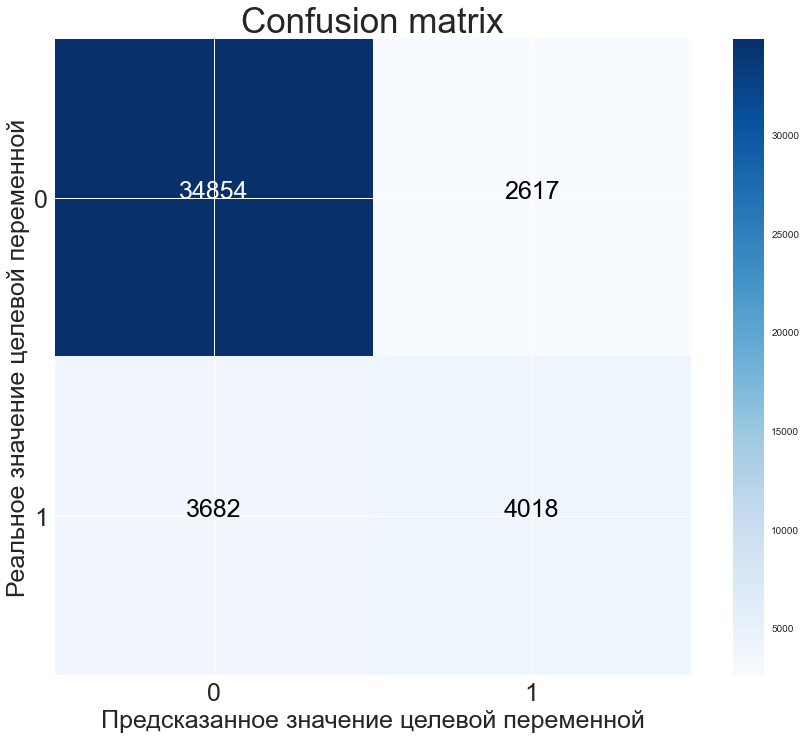

In [2284]:
plot_confusion_matrix(confusion_matrix(Pred_Real_table['Real'], Pred_Real_table['Num_Pred']), classes=set(Pred_Real_table['Real']),
                      title='Confusion matrix')

In [2285]:
df_new = non_life_data
df_new.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
11892        -0.493          -0.431                   0.160         -0.564   
53954        -0.493           1.586                   0.160          1.879   
23106         1.822           1.586                   0.160          1.879   
47297        -0.493          -0.684                   0.160         -0.564   
58509        -0.493          -0.684                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  \
11892       0.537        -0.282  -0.953               -0.054   
53954       0.537         0.600   1.324               -0.054   
23106       0.537         3.840  -0.085               -0.054   
47297       0.537        -0.081  -0.023               -0.054   
58509       0.537         0.519  -0.023               -0.054   

           Страховой риск, по которому произошло событие  CC main program  \
11892                     Госпитализация в результате НС           -0.093   
53954                    П3 Телесные повреждения Ребенка           -0.093   
23106             П3 Тяжкие телесные повреждения Ребенка           -0.093   
47297  П2- Телесные повреждения Застрахованного в рез...           -0.093   
58509  П2- Телесные повреждения Застрахованного в рез...           -0.093   

       Risk code  Доп. доход  Причина случая Тип страх. случая  \
11892     -0.505      -0.184  Бытовая травма            Травмы   
53954      1.477      -0.184  Бытовая травма            Травмы   
23106      1.477      -0.184  Бытовая травма            Травмы   
47297      0.133      -0.184  Бытовая травма            Травмы   
58509      0.133      -0.184  Бытовая травма            Травмы   

       Страховая сумма по риску, в валюте ответственности  \
11892                                             -0.997    
53954                                              0.342    
23106                                             -0.116    
47297                                             -0.469    
58509                                              2.527    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
11892                              0.171                      2.259   
53954                             -0.487                     -0.290   
23106                             -0.487                     -0.292   
47297                             -0.487                     -0.284   
58509                             -0.487                     -0.287   

       РЗУ, в валюте ответственности  \
11892                         -0.060   
53954                         -0.060   
23106                         -0.060   
47297                         -0.060   
58509                          0.485   

                                            Описание ЭСС  \
11892  Посттравматическая сгибательная контрактура 2 ...   
53954                            Ушиб н/3 пр. предплечья   
23106                                                  0   
47297   З/перелом ногтевой фаланги 1 пальца правой кисти   
58509            ожог II ст. правой нижней конечности 2%   

       Доля выгодоприобретателя  СС main programm  \
11892                     0.096            -0.333   
53954                     0.096            -0.310   
23106                     0.096            -0.347   
47297                     0.096            -0.303   
58509                     0.096            -0.154   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
11892                                              1.327                                 
53954                                             -0.996                                 
23106                                             -0.533                                 
47297                                             -0.912                                 
58509                                             -0.098                                 

       Кластер  Мошенничество  
11892

In [2286]:
sum(pd.concat([df_new, Pred_Real_table.set_index(df_new.index)], axis=1)['Мошенничество']-pd.concat([df_new, Pred_Real_table.set_index(df_new.index)], axis=1)['Real'])

0

In [2287]:
df_with_txt_pred = pd.concat([df_new, Pred_Real_table[['Pred', 'Num_Pred']].set_index(df_new.index)], axis=1).rename(columns={"Pred": "txt_pred_prob", "Num_Pred": "txt_pred_num"})
df_numeric_non_life = df_with_txt_pred

text_features = ['Страховой риск, по которому произошло событие', 'Причина случая', 'Тип страх. случая', 'Описание ЭСС']

df_numeric_non_life.drop(columns=text_features, inplace=True)

df_numeric_non_life.head()

Канал продаж  Серия договора  Валюта ответственности  Тип заявителя  \
11892        -0.493          -0.431                   0.160         -0.564   
53954        -0.493           1.586                   0.160          1.879   
23106         1.822           1.586                   0.160          1.879   
47297        -0.493          -0.684                   0.160         -0.564   
58509        -0.493          -0.684                   0.160         -0.564   

       Тип случая  Место случая  Регион  Группа инвалидности  CC main program  \
11892       0.537        -0.282  -0.953               -0.054           -0.093   
53954       0.537         0.600   1.324               -0.054           -0.093   
23106       0.537         3.840  -0.085               -0.054           -0.093   
47297       0.537        -0.081  -0.023               -0.054           -0.093   
58509       0.537         0.519  -0.023               -0.054           -0.093   

       Risk code  Доп. доход  \
11892     -0.505      -0.184   
53954      1.477      -0.184   
23106      1.477      -0.184   
47297      0.133      -0.184   
58509      0.133      -0.184   

       Страховая сумма по риску, в валюте ответственности  \
11892                                             -0.997    
53954                                              0.342    
23106                                             -0.116    
47297                                             -0.469    
58509                                              2.527    

       Оплаченные дни нетрудоспособности  ЗУ, % от страховой суммы   \
11892                              0.171                      2.259   
53954                             -0.487                     -0.290   
23106                             -0.487                     -0.292   
47297                             -0.487                     -0.284   
58509                             -0.487                     -0.287   

       РЗУ, в валюте ответственности  Доля выгодоприобретателя  \
11892                         -0.060                     0.096   
53954                         -0.060                     0.096   
23106                         -0.060                     0.096   
47297                         -0.060                     0.096   
58509                          0.485                     0.096   

       СС main programm  \
11892            -0.333   
53954            -0.310   
23106            -0.347   
47297            -0.303   
58509            -0.154   

       Разница между датой вступления договора в силу и наступлением страхового случая  \
11892                                              1.327                                 
53954                                             -0.996                                 
23106                                             -0.533                                 
47297                                             -0.912                                 
58509                                             -0.098                                 

       Кластер  Мошенничество  txt_pred_prob  txt_pred_num  
11892        1              0          0.301             1  
53954        0              0          0.076             0  
23106        0              1          0.993             1  
47297        1              0          0.062             0  
58509        1              1          0.260             1

<AxesSubplot:>

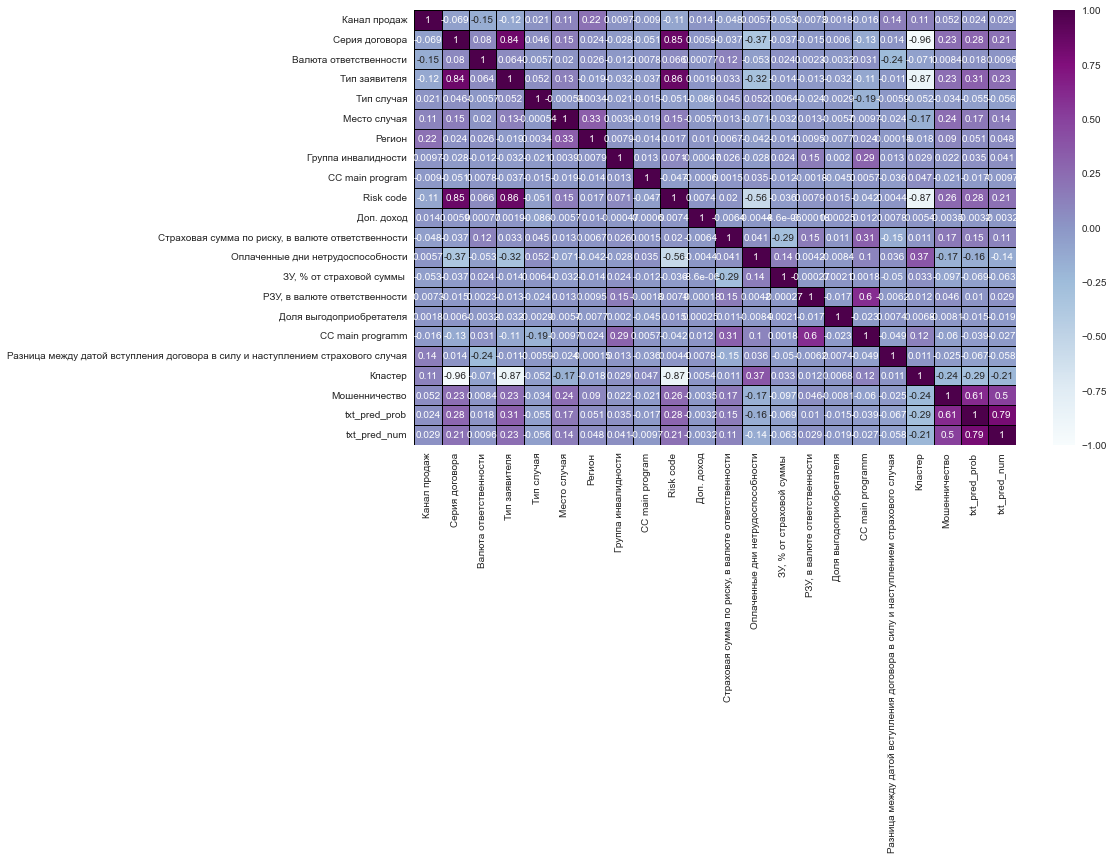

In [2288]:
plt.figure(figsize = (12,8))

sns.heatmap(df_numeric_non_life.loc[non_life_indexes_train].corr().dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1, linecolor='black', cmap='BuPu')

In [2289]:
X_train_non_life = df_numeric_non_life.loc[non_life_indexes_train].drop(columns=['Мошенничество'])
X_test_non_life = df_numeric_non_life.loc[non_life_indexes_test].drop(columns=['Мошенничество'])
y_train_non_life = df_numeric_non_life.loc[non_life_indexes_train]['Мошенничество']
y_test_non_life = df_numeric_non_life.loc[non_life_indexes_test]['Мошенничество']

In [2290]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_with_const = sm.add_constant(df_numeric_non_life.drop(columns=['Мошенничество']))

# расчет VIF для каждого признака
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
vif["features"] = X_with_const.columns
vif

VIF Factor                                           features
0    27882.814                                              const
1        1.141                                       Канал продаж
2       15.109                                     Серия договора
3        1.103                             Валюта ответственности
4        6.053                                      Тип заявителя
5        1.144                                         Тип случая
6        1.176                                       Место случая
7        1.170                                             Регион
8        1.156                                Группа инвалидности
9        1.006                                    CC main program
10       8.891                                          Risk code
11       1.007                                         Доп. доход
12       1.368  Страховая сумма по риску, в валюте ответственн...
13       1.900                  Оплаченные дни нетрудоспособности
14       1.158                          ЗУ, % от страховой суммы 
15       1.581                      РЗУ, в валюте ответственности
16       1.014                           Доля выгодоприобретателя
17       2.022                                   СС main programm
18       1.119  Разница между датой вступления договора в силу...
19      18.013                                            Кластер
20       2.856                                      txt_pred_prob
21       2.676                                       txt_pred_num

In [2291]:
logistic = LogisticRegression(C=0.5, penalty = 'l2', max_iter=10000, n_jobs=-1)
logistic.fit(X_train_non_life, y_train_non_life)
logistic.score(X_test_non_life, y_test_non_life)

0.8838589652728561

In [2292]:
print(classification_report(y_test_non_life, logistic.predict(X_test_non_life)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9332
           1       0.83      0.41      0.55      1956

    accuracy                           0.88     11288
   macro avg       0.86      0.70      0.74     11288
weighted avg       0.88      0.88      0.87     11288



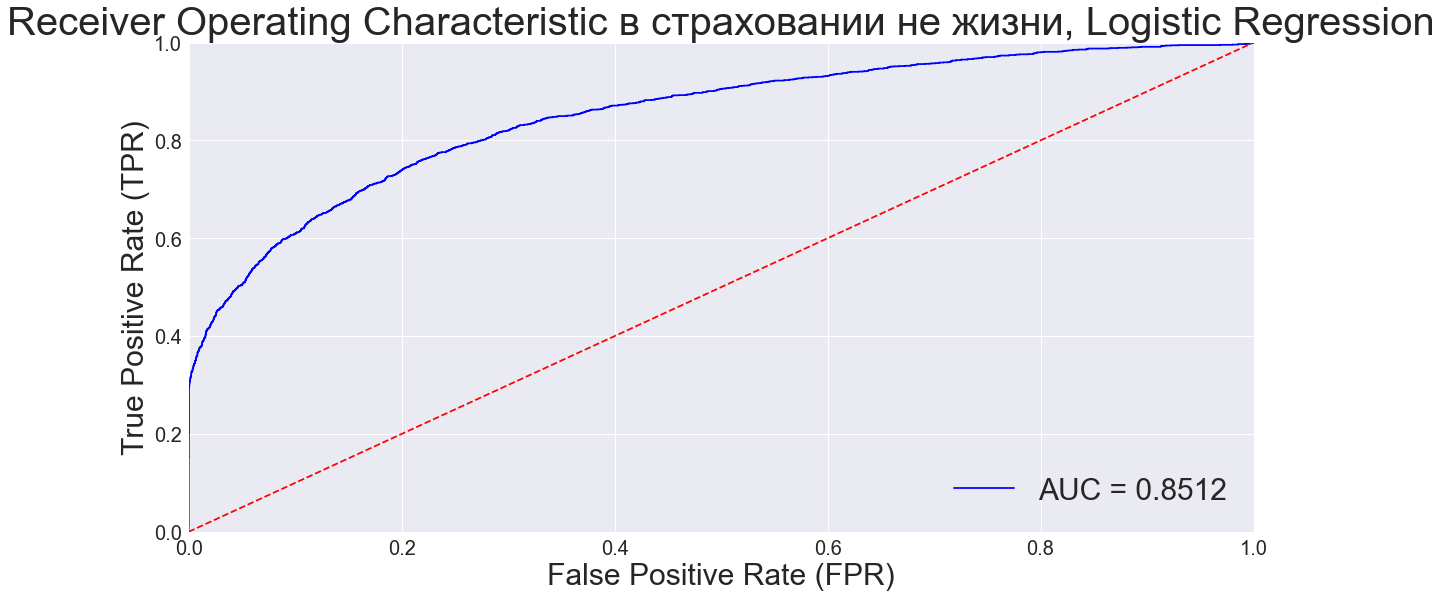

In [2293]:
fpr, tpr, threshold = roc_curve(y_test_non_life, logistic.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, Logistic Regression', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

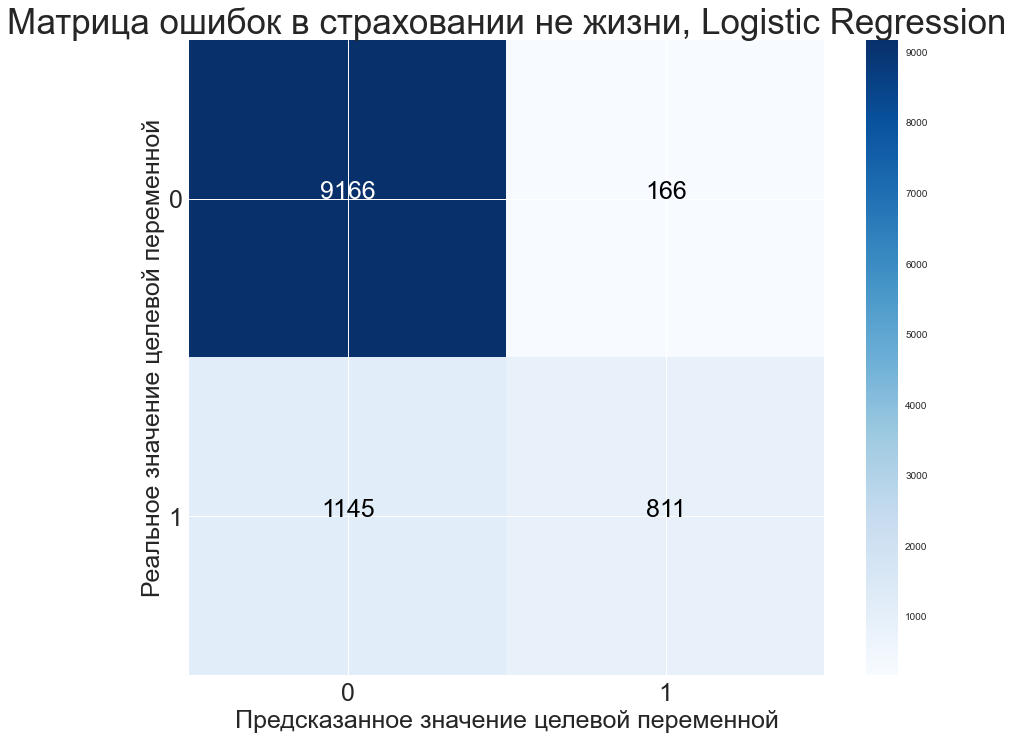

In [2294]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, logistic.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании не жизни, Logistic Regression')

In [2295]:
svm = SVC(kernel='rbf', gamma='scale', C=10, probability=True)
svm.fit(X_train_non_life, y_train_non_life)

svm.score(X_test_non_life, y_test_non_life)

0.9336463501063076

In [2296]:
print(classification_report(y_test_non_life, svm.predict(X_test_non_life)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9332
           1       0.93      0.67      0.78      1956

    accuracy                           0.93     11288
   macro avg       0.93      0.83      0.87     11288
weighted avg       0.93      0.93      0.93     11288



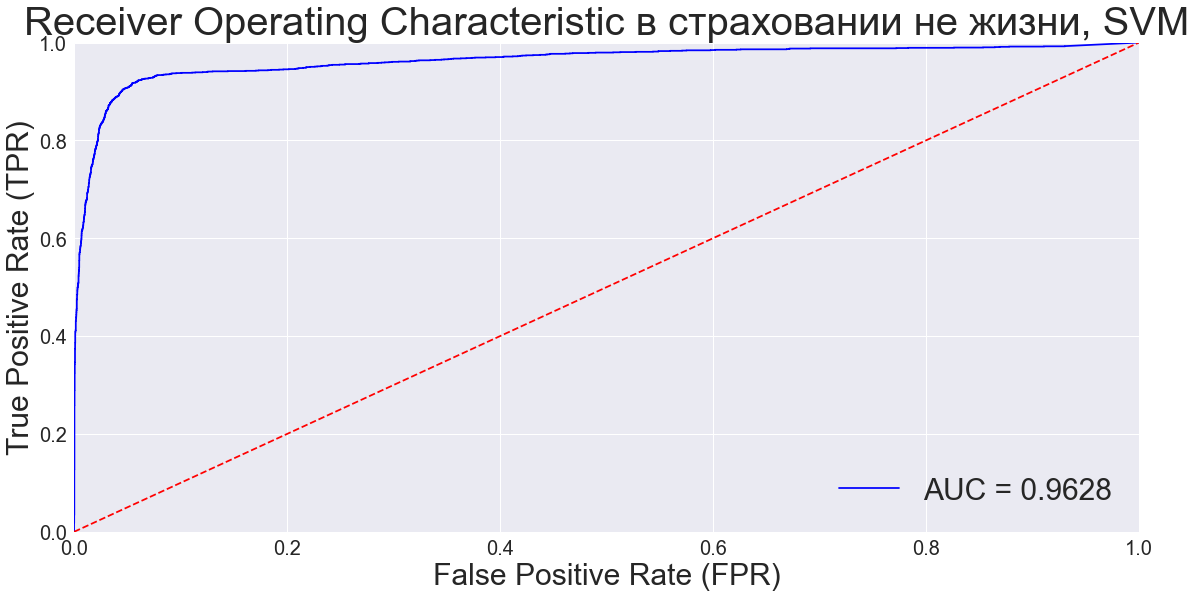

In [2297]:
fpr, tpr, threshold = roc_curve(y_test_non_life, svm.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, SVM', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

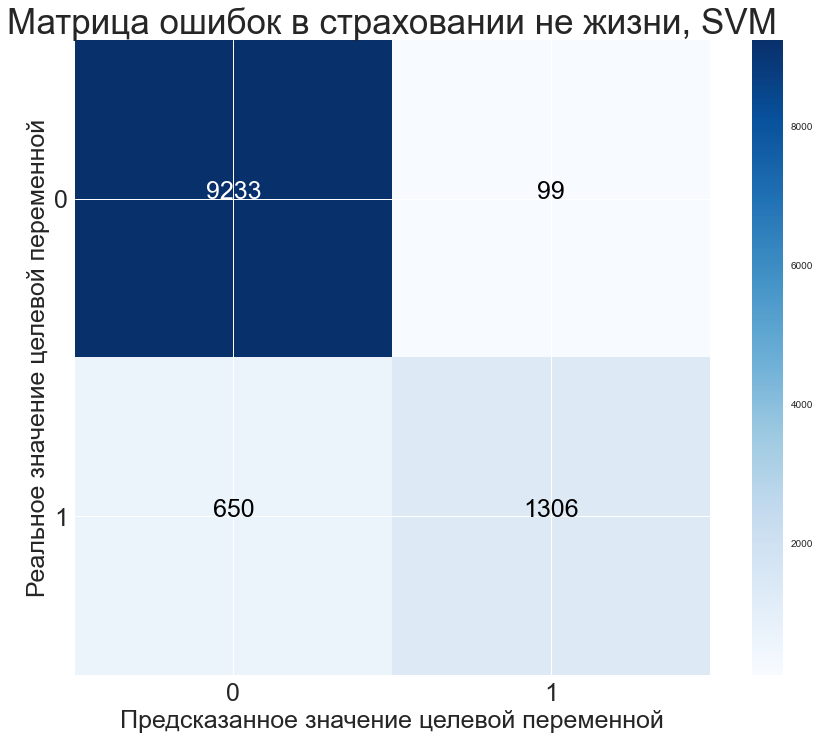

In [2298]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, svm.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании не жизни, SVM')

In [2299]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train_non_life, y_train_non_life)
lda.score(X_test_non_life, y_test_non_life)

0.8804039688164422

In [2376]:
fisher_funcs = lda.decision_function(X_test_non_life)
print(fisher_funcs)
print(len(fisher_funcs))

[-1.09055517 -3.47423807 -6.93897054 ... -5.97181107 -4.60223354
 -3.00099506]
11288


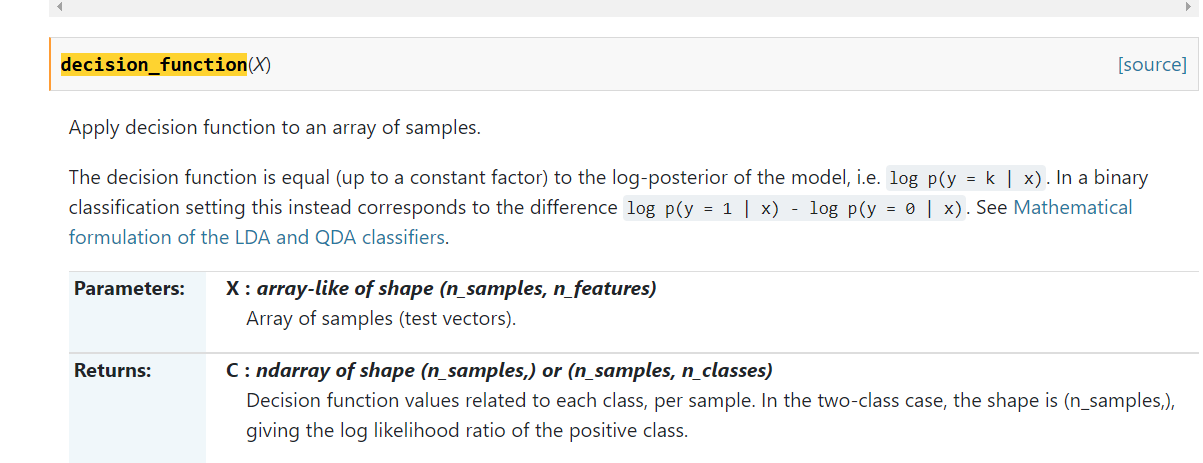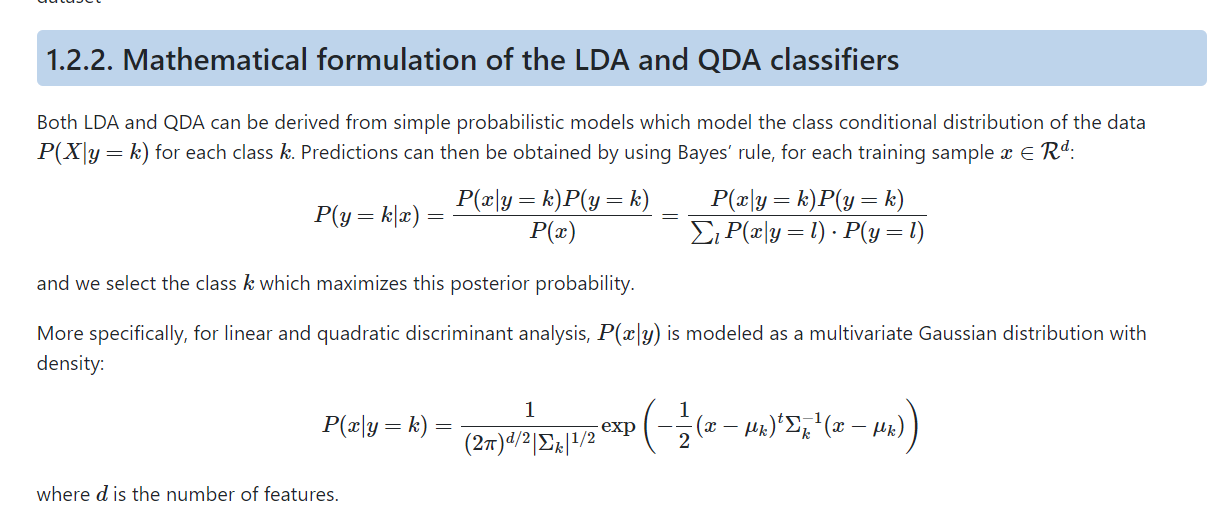

In [2301]:
lda.coef_

array([[ 0.13996427, -0.11145443, -0.05544141, -0.76113396, -0.29886054,
         0.54395941,  0.04368963,  0.01458299, -0.0231362 ,  1.25589007,
        -5.37754124,  0.51618355,  0.06132947, -0.06294491,  0.54244808,
        -0.14898584, -1.32781024,  0.08998807, -0.17467223, 10.61536713,
         0.66796534]])

In [2302]:
lda.means_

array([[-0.02594389,  0.09460219,  0.09333246,  0.0129822 ,  0.52119471,
         0.06320216, -0.01252407,  0.00539581, -0.0199454 ,  0.07296713,
        -0.1838223 ,  0.12394415,  0.23481321,  0.04436636, -0.05838422,
         0.08591474, -0.16535112, -0.23621988,  0.71754504,  0.0959977 ,
         0.06762856],
       [ 0.10905852,  0.71840079,  0.10762299,  0.67657292,  0.5020557 ,
         0.70553456,  0.23483007,  0.07358763, -0.06613602,  0.71500211,
        -0.18383412,  0.56897478, -0.27814133, -0.24911377,  0.05382837,
         0.0784766 , -0.24942806, -0.2882022 ,  0.41834958,  0.45931854,
         0.54456825]])

In [2303]:
print(classification_report(y_test_non_life, lda.predict(X_test_non_life)))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9332
           1       0.86      0.37      0.52      1956

    accuracy                           0.88     11288
   macro avg       0.87      0.68      0.73     11288
weighted avg       0.88      0.88      0.86     11288



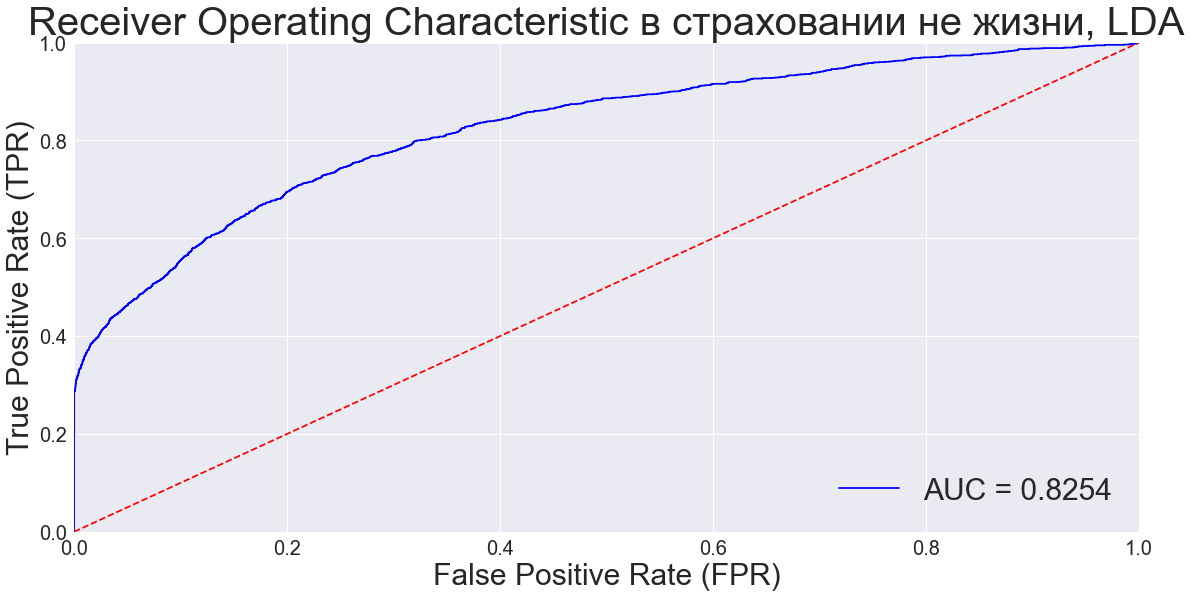

In [2304]:
fpr, tpr, threshold = roc_curve(y_test_non_life, lda.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, LDA', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

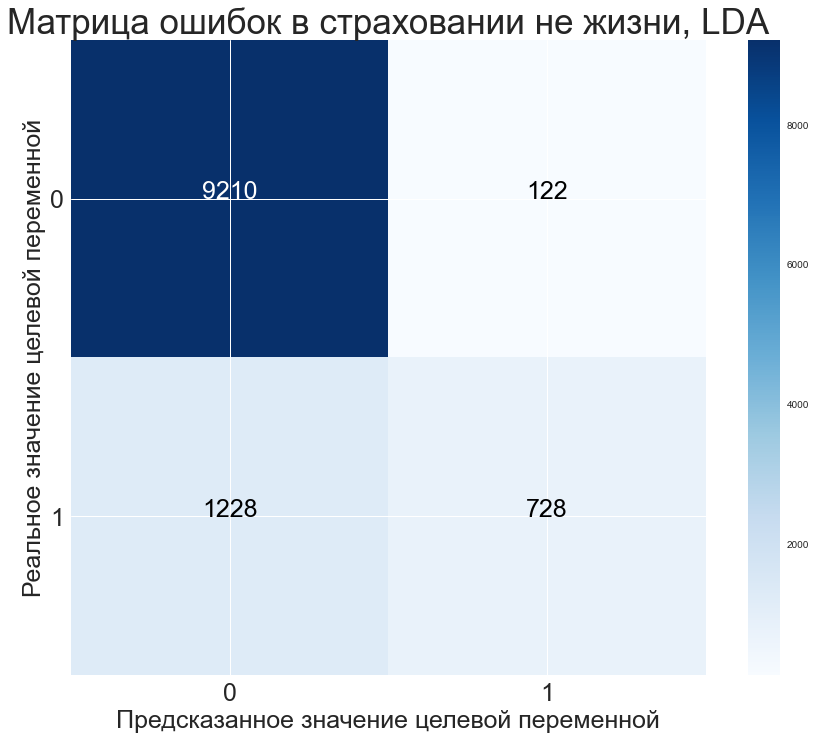

In [2305]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, lda.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании не жизни, LDA')

In [2445]:
params = {
    "n_estimators": 1000,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.7,
    'verbose': 1,
    'min_samples_leaf': 9,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'deviance'
}
GBC = GradientBoostingClassifier(**params)
GBC.fit(X_train_non_life, y_train_non_life)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8895           0.0188           35.97s
         2           0.8693           0.0180           35.94s
         3           0.8545           0.0171           35.90s
         4           0.8362           0.0164           36.32s
         5           0.8239           0.0156           36.12s
         6           0.8122           0.0147           36.03s
         7           0.7932           0.0145           35.96s
         8           0.7865           0.0136           36.02s
         9           0.7729           0.0130           35.95s
        10           0.7539           0.0128           35.49s
        20           0.6489           0.0093           34.68s
        30           0.5652           0.0074           34.04s
        40           0.5033           0.0059           33.97s
        50           0.4468           0.0050           33.98s
        60           0.3977           0.0043           33.84s
       

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=9,
                           n_estimators=1000, n_iter_no_change=100,
                           random_state=911, subsample=0.7, tol=1e-05,
                           verbose=1)

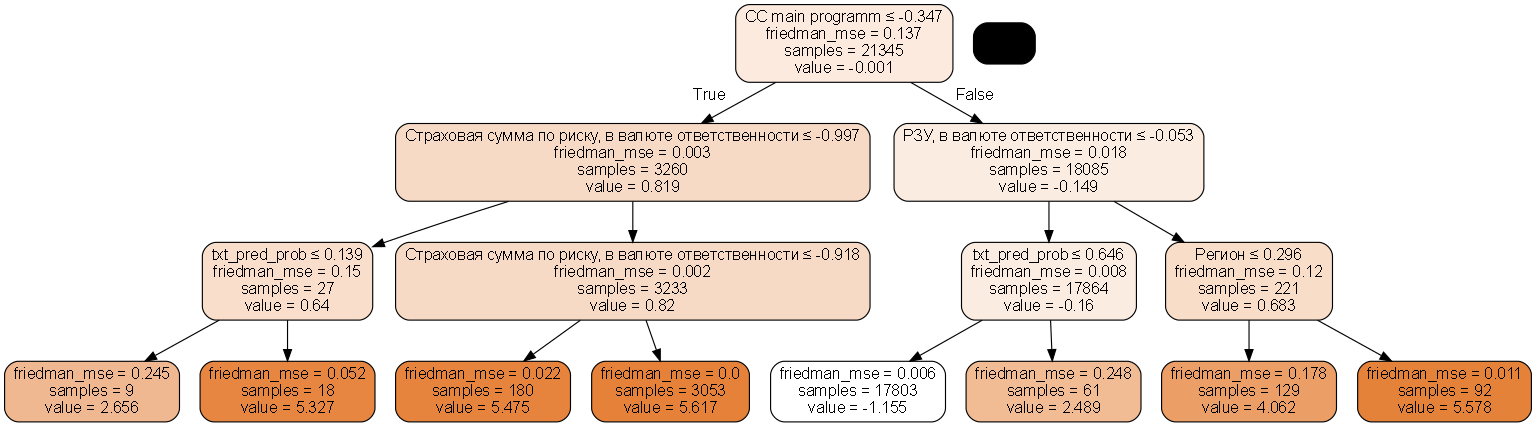

In [2446]:
estimator = GBC.estimators_[1][0]

# Строим график дерева
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train_non_life.columns, class_names=list(map(str, GBC.classes_)), filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"16,30!"')
#graph.set('node', fontname='Arial')
#graph.set('node', size='50')
Image(graph.create_png())

In [2307]:
print(classification_report(y_test_non_life, GBC.predict(X_test_non_life)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9332
           1       0.98      0.95      0.97      1956

    accuracy                           0.99     11288
   macro avg       0.99      0.97      0.98     11288
weighted avg       0.99      0.99      0.99     11288



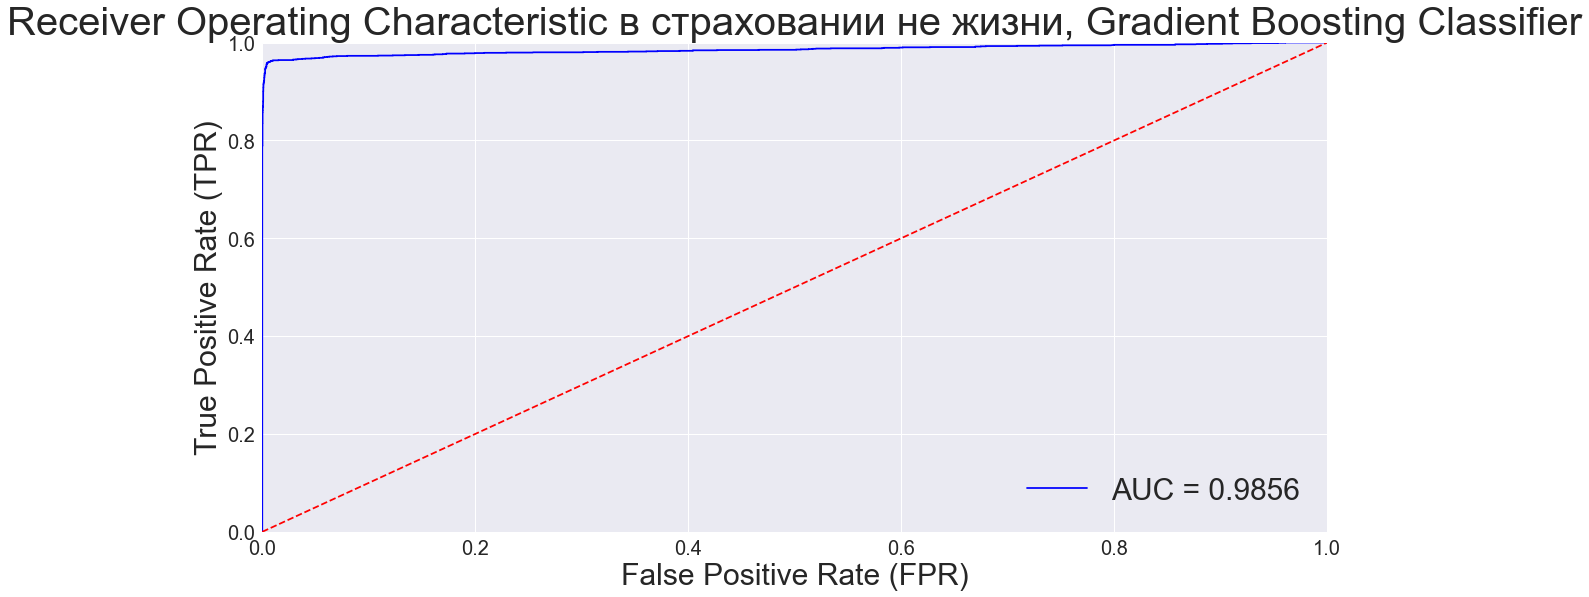

In [2308]:
fpr, tpr, threshold = roc_curve(y_test_non_life, GBC.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, Gradient Boosting Classifier', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

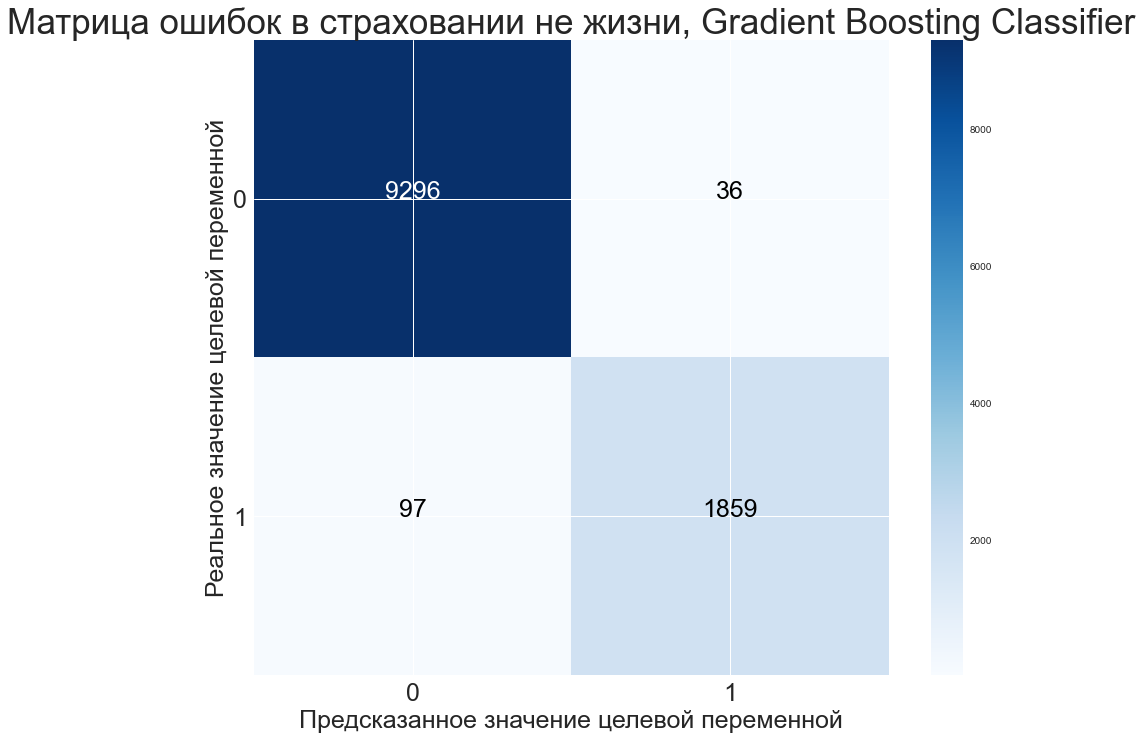

In [2309]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, GBC.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании не жизни, Gradient Boosting Classifier')

In [2310]:
accuracy_score(y_test_non_life, GBC.predict(X_test_non_life))

0.9882175761871014

In [2449]:
clf = RandomForestClassifier(max_depth=3, random_state=911, n_estimators=2000, oob_score=True, bootstrap=True, criterion='entropy', verbose=1, n_jobs=-1)
clf.fit(X_train_non_life, y_train_non_life)

accuracy_score(y_test_non_life, clf.predict(X_test_non_life))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    3.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.5s
[Parallel(n_job

0.9814847625797307

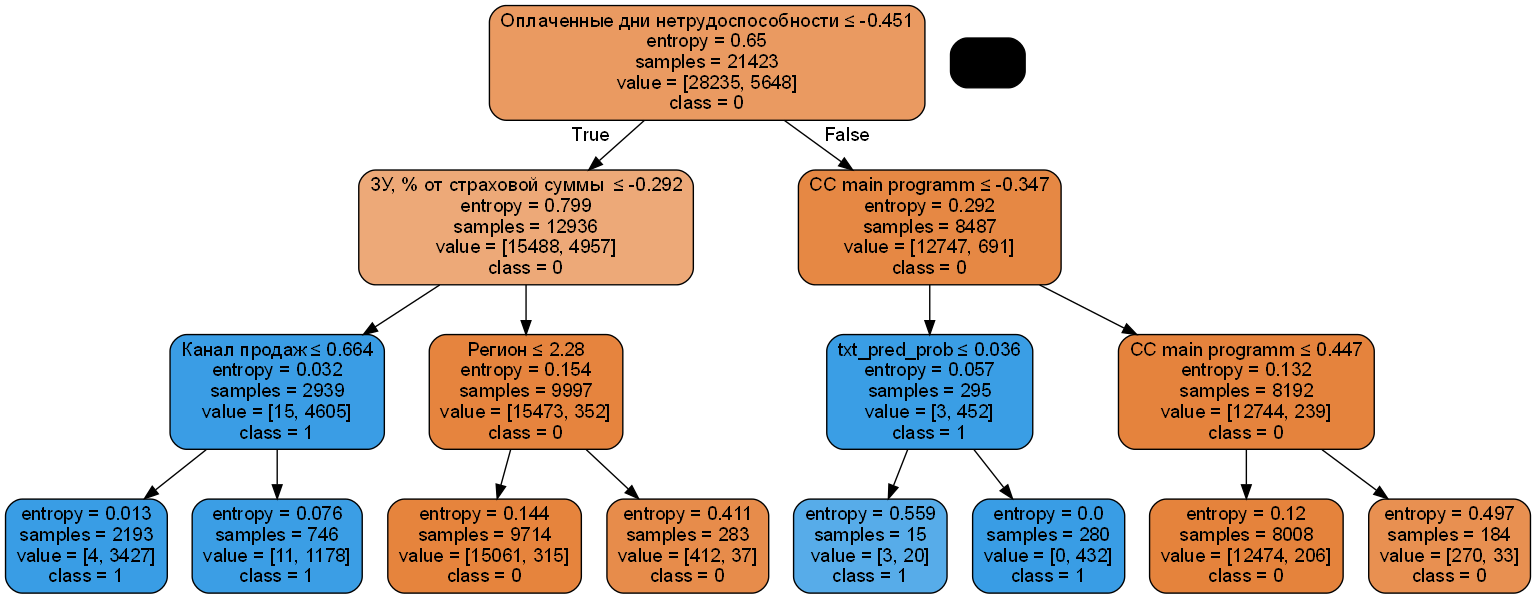

In [2450]:
estimator = clf.estimators_[0]

# Строим график дерева
dot_data = tree.export_graphviz(estimator, out_file=None, feature_names=X_train_non_life.columns, class_names=list(map(str, clf.classes_)), filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"16,30!"')
#graph.set('node', fontname='Arial')
#graph.set('node', size='50')
Image(graph.create_png())

In [2312]:
print(classification_report(y_test_non_life, clf.predict(X_test_non_life)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9332
           1       1.00      0.90      0.94      1956

    accuracy                           0.98     11288
   macro avg       0.99      0.95      0.97     11288
weighted avg       0.98      0.98      0.98     11288



[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.3s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.3s finished


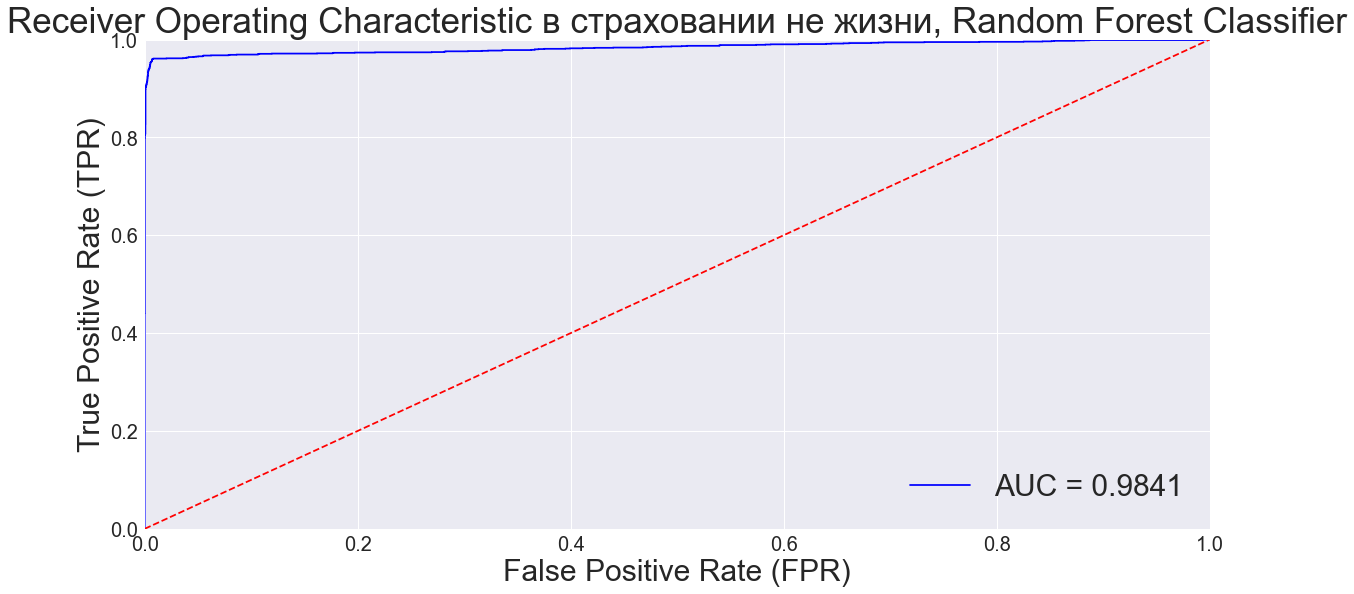

In [2313]:
fpr, tpr, threshold = roc_curve(y_test_non_life, clf.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании не жизни, Random Forest Classifier', fontsize = 35)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.3s finished


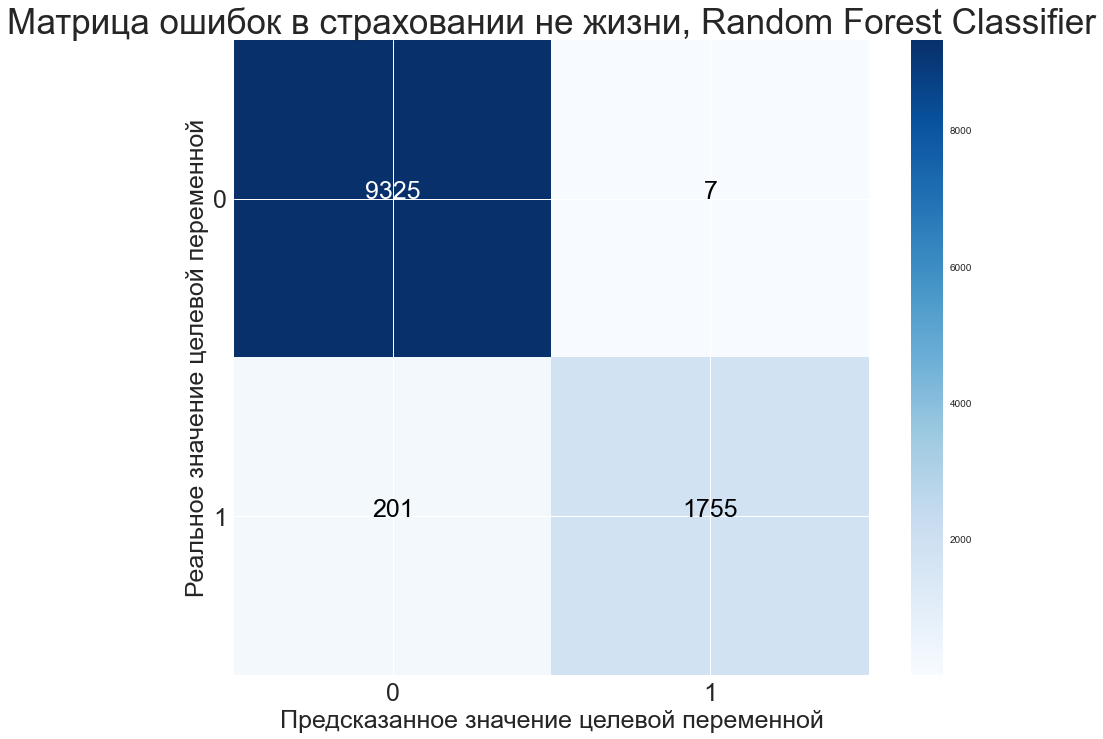

In [2314]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, clf.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании не жизни, Random Forest Classifier')

In [2315]:
sorted_idx

array([ 7, 12,  2,  6,  0,  8, 15, 11,  4,  1, 17, 10, 16,  3, 13,  5, 18,
        9, 14, 20, 19], dtype=int64)

In [ ]:
np.array([ 8,  7,  2, 18, 15, 17, 10,  1,  4,  6, 11,  0,  3, 12,  9, 20,  5,
       19, 14, 13, 16])

In [1459]:
np.array(X_test_non_life.columns)[np.array([18, 17, 7,  2, 15, 10, 6,  1,  4,  8, 16,  0,  3, 12,  9,  5,
        14, 13, 18, 20, 19])]

array(['Кластер',
       'Разница между датой вступления договора в силу и наступлением страхового случая',
       'Группа инвалидности', 'Валюта ответственности',
       'Доля выгодоприобретателя', 'Доп. доход', 'Регион',
       'Серия договора', 'Тип случая', 'CC main program',
       'СС main programm', 'Канал продаж', 'Тип заявителя',
       'Оплаченные дни нетрудоспособности', 'Risk code', 'Место случая',
       'РЗУ, в валюте ответственности', 'ЗУ, % от страховой суммы ',
       'Кластер', 'txt_pred_num', 'txt_pred_prob'], dtype=object)

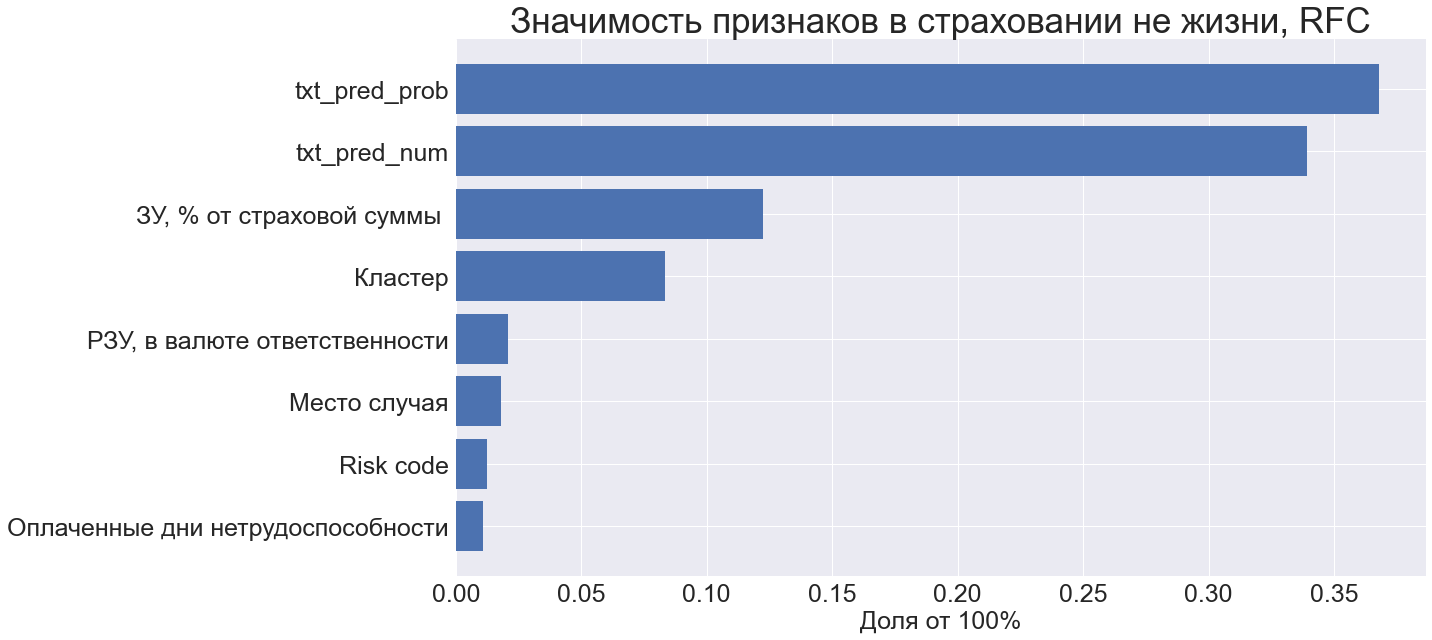

In [2319]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
a = feature_importance[sorted_idx]
b = np.array(X_test_non_life.rename({'Разница между датой вступления договора в силу и наступлением страхового случая': 'Кол-во дн. меж. заключ. дог. и страх. случ.', 
                   'Страховой риск, по которому произошло событие': 'Страх. риск, по кот. произ. соб.', 
                   'Размер страховой выплаты в валюте ответственности': 'Разм. страх. выплаты в вал. отв.', 
                   'Страховая сумма по риску, в валюте ответственности': 'Страх. сум. по риску, в вал. отв.'}, inplace=False, axis=1).columns)[sorted_idx]

b = np.array(X_test_non_life.columns)[np.array([18, 17, 7,  2, 15, 10, 6,  1,  4,  8, 16,  0,  3, 12,  9,  5, 14, 18, 13, 20, 19])]
lenth = len(np.vstack((a,b))[0][np.vstack((a,b))[0] >= 0.01])
pos = np.arange(lenth) + .5
fig = plt.figure(figsize=(20, 9))

plt.barh(pos, np.vstack((a,b))[0][np.vstack((a,b))[0] >= 0.01], align='center')
plt.yticks(pos, np.vstack((a,b))[1][np.vstack((a,b))[0] >= 0.01], fontsize = 25)
plt.title('Значимость признаков в страховании не жизни, RFC', fontsize = 35)
#result = permutation_importance(clf, X_train, target_train['Slopeprecioalc'], n_repeats=10,
                                #random_state=911, n_jobs=2)
#sorted_idx = result.importances_mean.argsort()
plt.xlabel('Доля от 100%', fontsize = 25)
plt.xticks(fontsize = 25)
fig.tight_layout()
plt.show()

In [2320]:
#new_cols = np.vstack((a,b))[1][np.vstack((a,b))[0] >= 0.01]
#new_cols[-3] = 'Доп. доход'
#new_cols[-4] = 'Доля выгодоприобретателя'
#new_cols[-6] = 'ЗУ, % от страховой суммы'
#new_cols[-7] = 'Страх. сум. по риску, в вал. отв.'

### без ответов нейронки

In [2356]:
X_train_non_life_dropped = X_train_non_life.drop(axis=1, columns=['txt_pred_prob', 'txt_pred_num'])
X_test_non_life_dropped = X_test_non_life.drop(axis=1, columns=['txt_pred_prob', 'txt_pred_num'])

params = {
    "n_estimators": 51,
    "max_depth": 2,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "deviance",
    'subsample': 0.5,
    'verbose': 1,
    'min_samples_leaf': 4,
    'tol': 1e-5, 
    'n_iter_no_change': 100,
    'random_state': 911,
    'loss': 'deviance'
}
GBC = GradientBoostingClassifier(**params)
GBC.fit(X_train_non_life, y_train_non_life)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8959           0.0185            0.85s
         2           0.8735           0.0177            0.83s
         3           0.8569           0.0168            0.82s
         4           0.8459           0.0159            0.79s
         5           0.8189           0.0156            0.77s
         6           0.8118           0.0147            0.75s
         7           0.7944           0.0143            0.73s
         8           0.7782           0.0138            0.71s
         9           0.7821           0.0128            0.69s
        10           0.7522           0.0128            0.67s
        20           0.6520           0.0093            0.50s
        30           0.5676           0.0073            0.33s
        40           0.5064           0.0059            0.18s
        50           0.4539           0.0049            0.02s


GradientBoostingClassifier(learning_rate=0.01, max_depth=2, min_samples_leaf=4,
                           n_estimators=51, n_iter_no_change=100,
                           random_state=911, subsample=0.5, tol=1e-05,
                           verbose=1)

In [2357]:
print(classification_report(y_test_non_life, GBC.predict(X_test_non_life)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9332
           1       1.00      0.80      0.89      1956

    accuracy                           0.96     11288
   macro avg       0.98      0.90      0.93     11288
weighted avg       0.97      0.96      0.96     11288



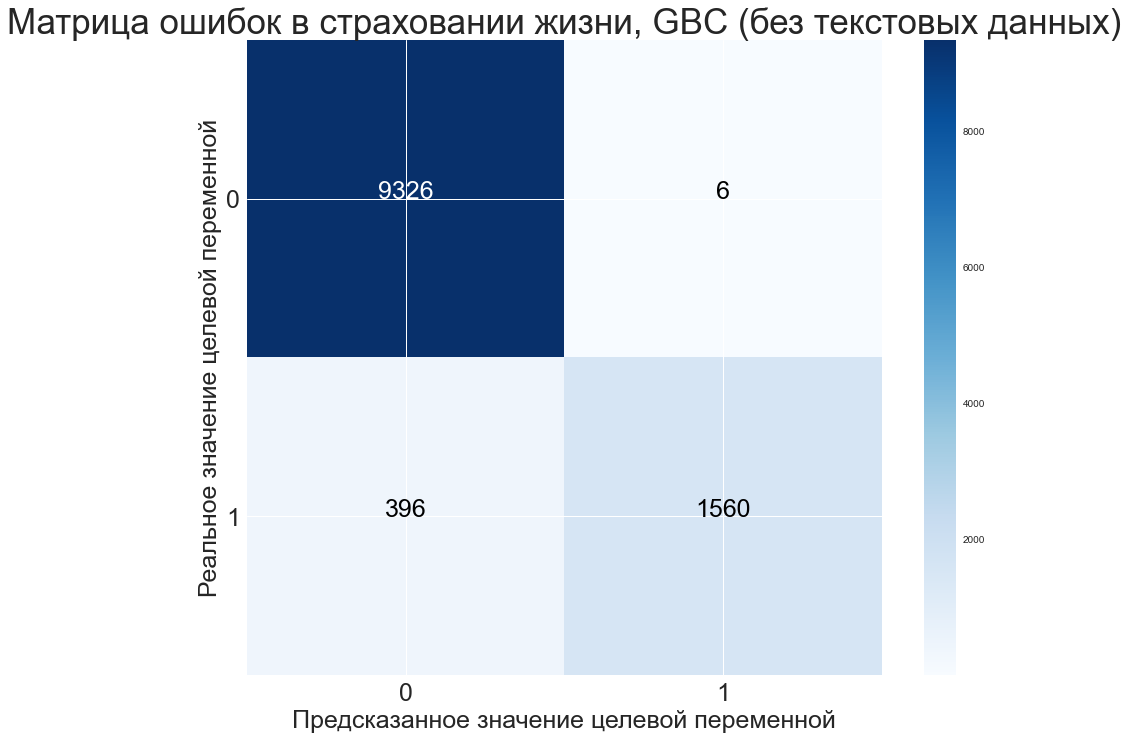

In [2358]:
plot_confusion_matrix(confusion_matrix(y_test_non_life, GBC.predict(X_test_non_life)), classes=set(y_test_non_life),
                      title='Матрица ошибок в страховании жизни, GBC (без текстовых данных)')

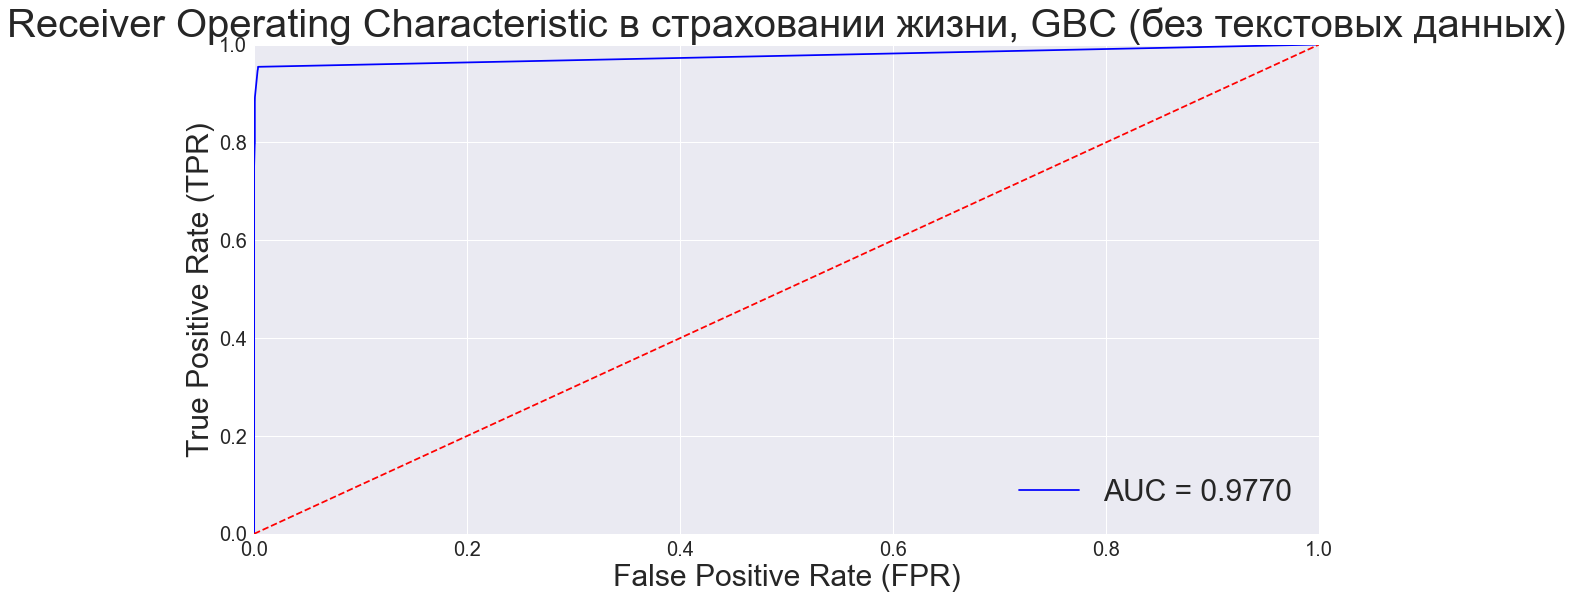

In [2359]:
fpr, tpr, threshold = roc_curve(y_test_non_life, GBC.predict_proba(X_test_non_life)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic в страховании жизни, GBC (без текстовых данных)', fontsize = 40)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 30)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('True Positive Rate (TPR)', fontsize = 30)
plt.xlabel('False Positive Rate (FPR)', fontsize = 30)
plt.show()

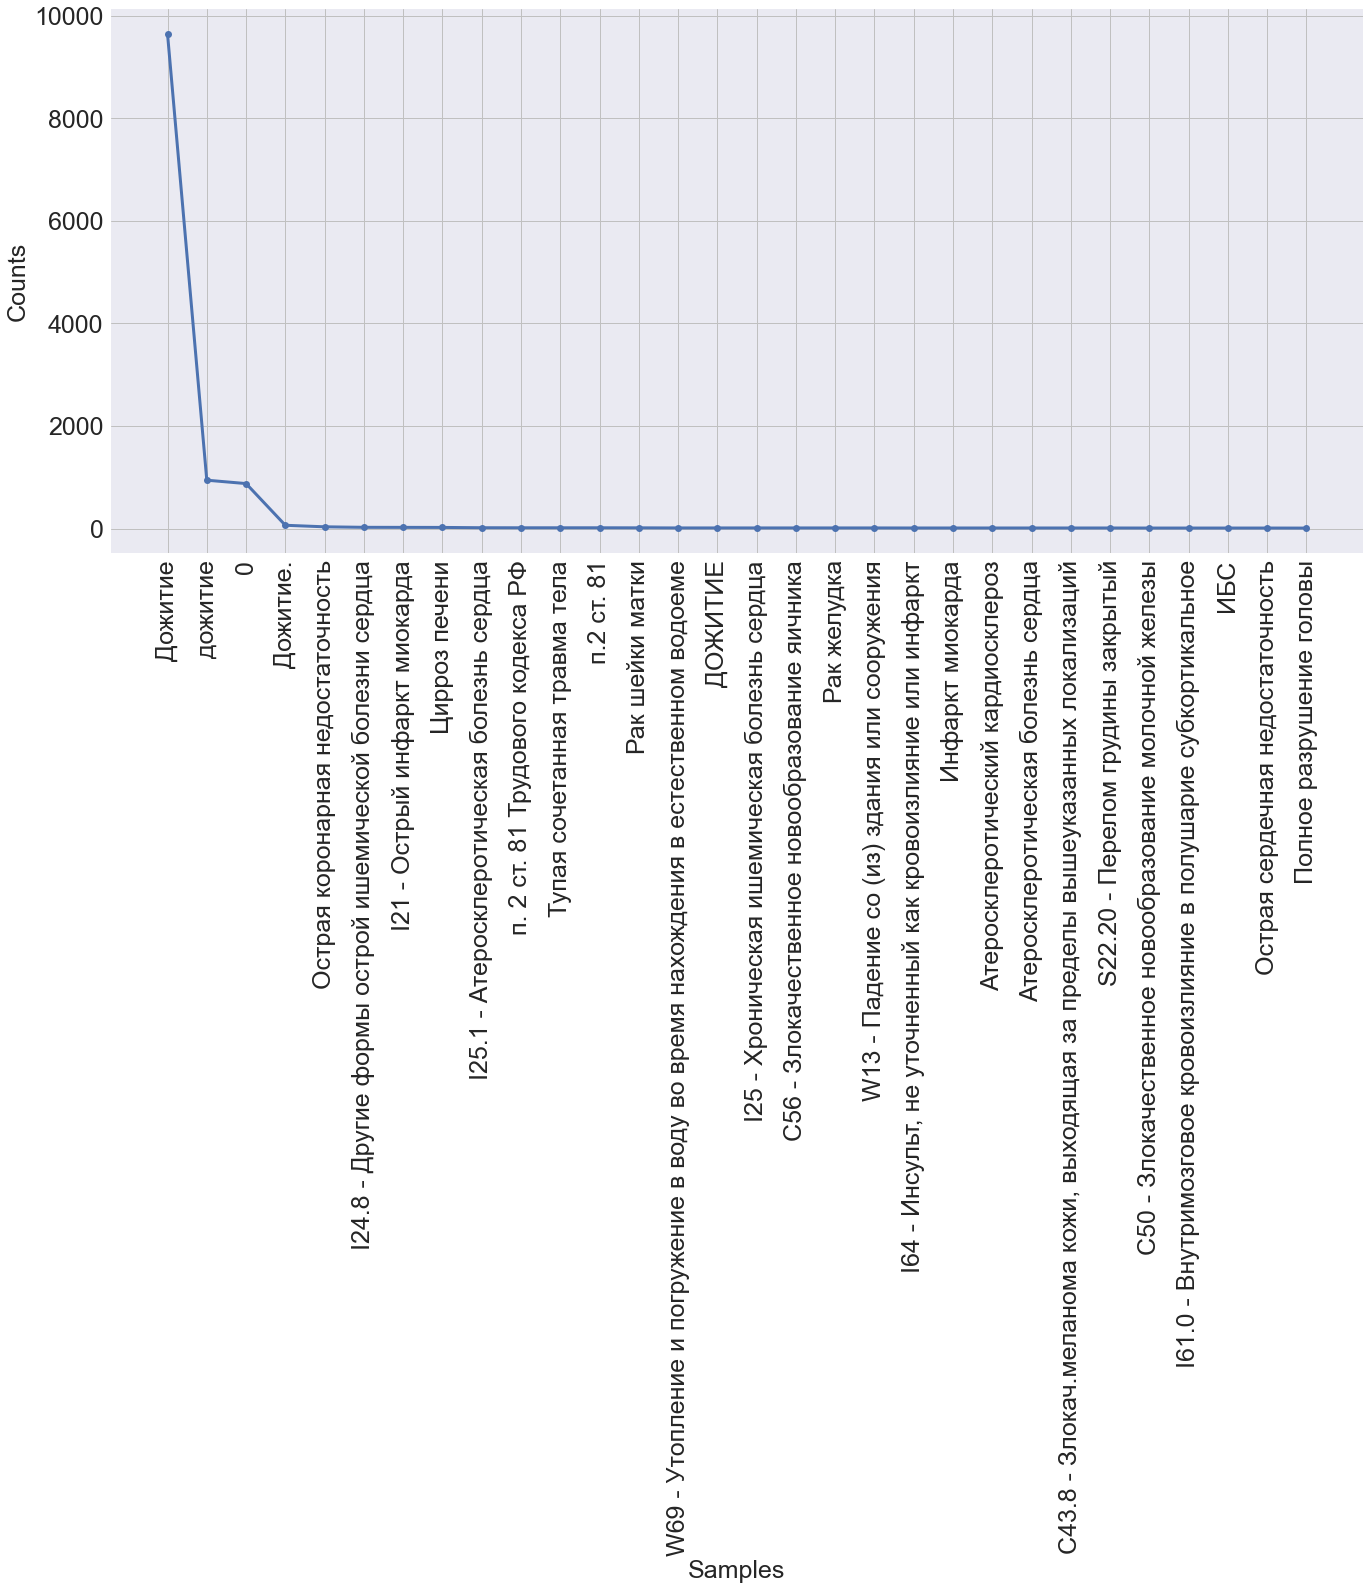

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [2360]:
from nltk.probability import FreqDist
fdist = FreqDist(life_data['Описание ЭСС'])
#fdist.pop(nan)

plt.figure(figsize=(20, 10))
plt.xlabel("Описания ЭСС", fontsize = 25)
plt.ylabel("Количество", fontsize = 25) 
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25) 
fdist.plot(30,cumulative=False, linewidth=3, marker="o")

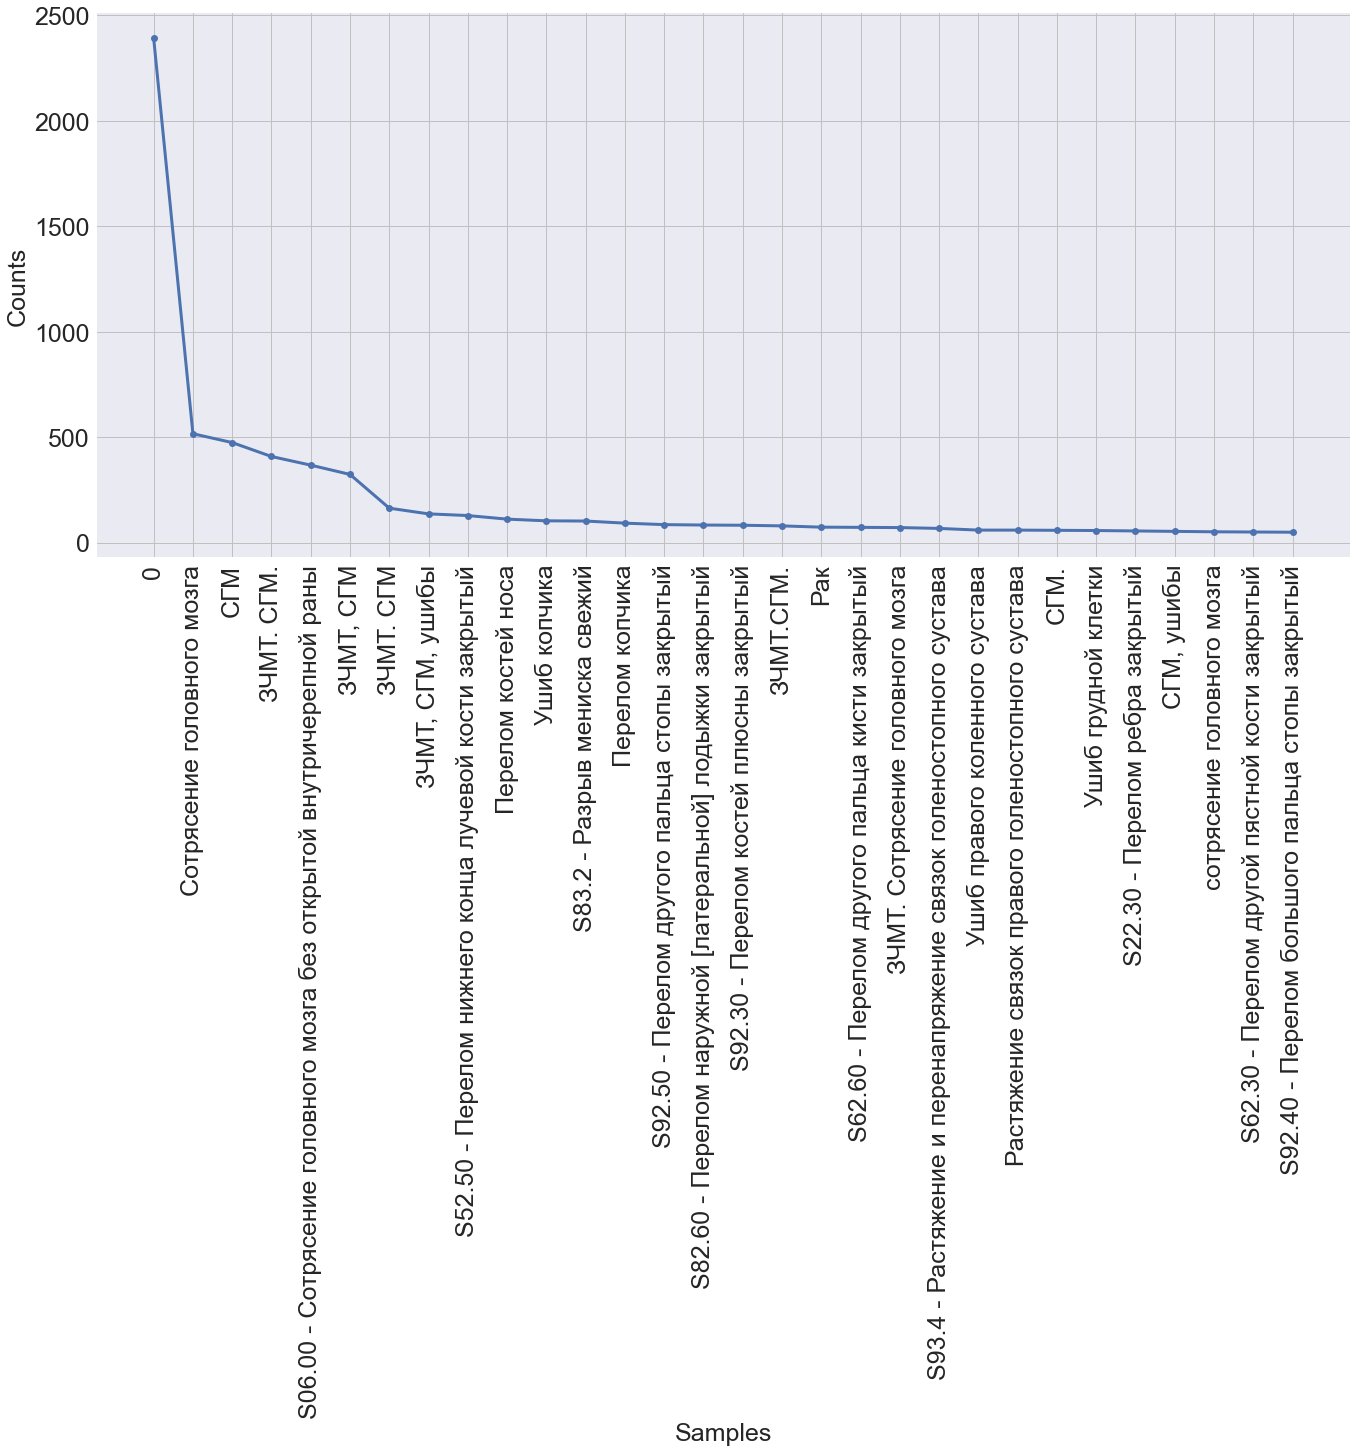

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [2361]:
fdist = FreqDist(non_life_data['Описание ЭСС'])
#fdist.pop(nan)

plt.figure(figsize=(20, 10))
plt.xlabel("Описания ЭСС", fontsize = 25)
plt.ylabel("Количество", fontsize = 25) 
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25) 
fdist.plot(30,cumulative=False, linewidth=3, marker="o")

### Корреляции до нейронки

In [2516]:
df_for_corr_train = df_total.loc[indexes_for_train]
deleted_lst = ['Номер договора ', 'Старый номер договора ', 'Задолженность на дату убытка, руб.', 'Агент по договору', 'ID Застрахованного', 'ИД ЭСС ', 'Кол-во дней нетрудоспособности', 'Размер страховой выплаты в валюте ответственности', 'Размер страховой выплаты, рубли', '№ акта', 'Сумма к выплате, рубли', 'НДФЛ', 'ИД выплаты', 'Разница между датой выплаты и датой подачи заявления', 'Разница между датой отказа в выплате и заявления о страховом случае']
df_num_for_corr_train = df_for_corr_train[[x for x in data.select_dtypes(include=numerics).columns if x not in deleted_lst]]
df_num_for_corr_train = df_num_for_corr_train.rename(columns={'Разница между датой вступления договора в силу и наступлением страхового случая': 'Кол-во дн. меж. заключ. дог. и страх. случ.', 
                   'Страховой риск, по которому произошло событие': 'Страх. риск, по кот. произ. соб.', 
                   'Размер страховой выплаты в валюте ответственности': 'Разм. страх. выплаты в вал. отв.', 
                   'Страховая сумма по риску, в валюте ответственности': 'Страх. сум. по риску, в вал. отв.'}, inplace=False)

deleted_lst_2 = ['Вид страхования', 'Ф.И.О. Страхователь ', 'ФИО заявившего', 'Дата составления', 'Дата подписания', 'Дата принятия', 'Дата и время случая', 'Ф.И.О. Застрахованного', 'Статус ЭСС ', 'Дата отклонения ЭСС', 'Тип выплаты', 'Состояние выплаты', 'Способ выплаты']
df_cat_for_corr_train = df_for_corr_train[[x for x in data.select_dtypes(include=object).columns if x not in deleted_lst_2]]
df_cat_for_corr_train = df_cat_for_corr_train.drop(['Причина случая', 'Описание ЭСС', 'Страховой риск, по которому произошло событие', 'Тип страх. случая'], axis=1)
df_cat_for_corr_train[['Кластер', 'Мошенничество']] = df_total.loc[indexes_for_train][['Кластер', 'Мошенничество']]

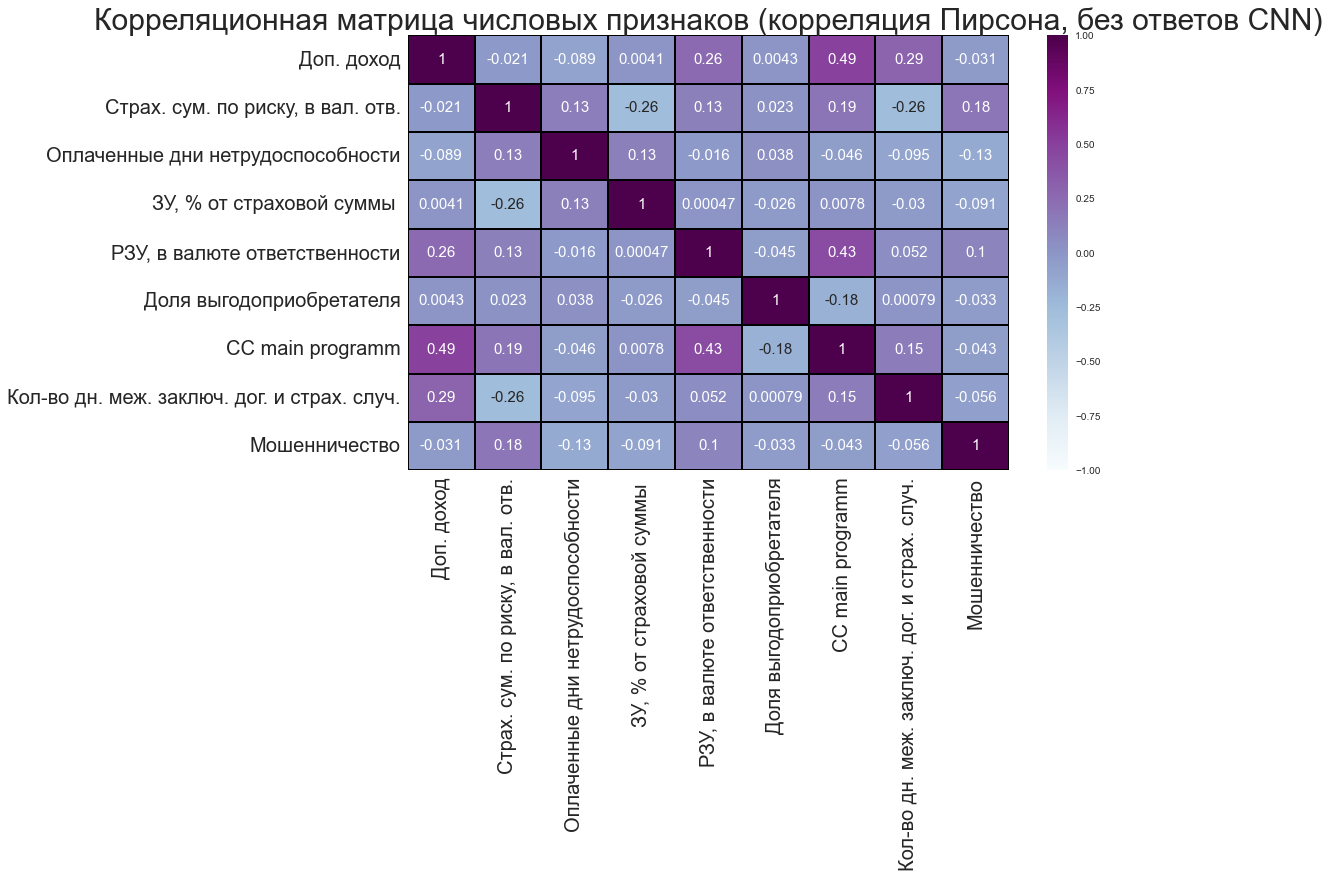

In [2517]:
plt.figure(figsize = (12,8))
plt.title('Корреляционная матрица числовых признаков (корреляция Пирсона, без ответов CNN)', fontsize = 30)
ax = sns.heatmap(df_num_for_corr_train.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1.5, linecolor='black', cmap='BuPu', annot_kws={"size": 15})
ax.tick_params(axis='x', labelsize=20, rotation=90)
ax.tick_params(axis='y', labelsize=20)
plt.show()

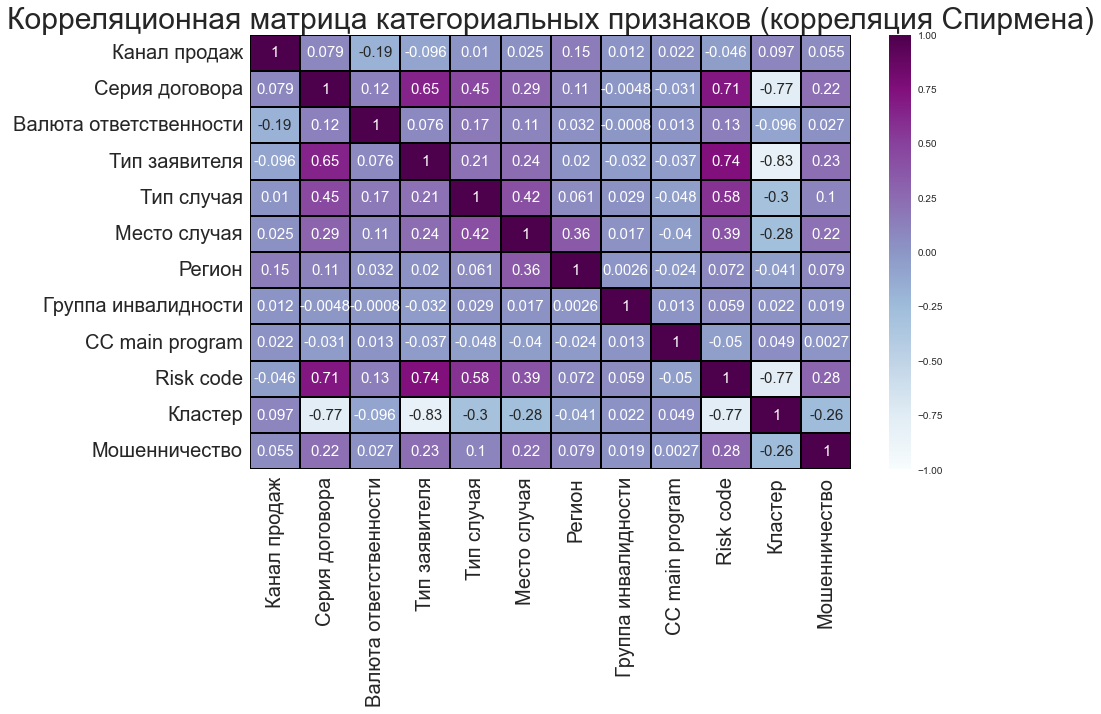

In [2518]:
plt.figure(figsize = (12,8))
plt.title('Корреляционная матрица категориальных признаков (корреляция Спирмена)', fontsize = 30)
ax = sns.heatmap(df_cat_for_corr_train.corr(method='spearman').dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1.5, linecolor='black', cmap='BuPu', annot_kws={"size": 15})
ax.tick_params(axis='x', labelsize=20, rotation=90)
ax.tick_params(axis='y', labelsize=20)
plt.show()

### Корреляции после нейронки

In [2532]:
df_for_corr_after_nn = pd.concat([df_numeric_non_life.loc[non_life_indexes_train], df_numeric_life.loc[life_indexes_train]],axis=0)
deleted_lst = ['Номер договора ', 'Старый номер договора ', 'Задолженность на дату убытка, руб.', 'Агент по договору', 'ID Застрахованного', 'ИД ЭСС ', 'Кол-во дней нетрудоспособности', 'Размер страховой выплаты в валюте ответственности', 'Размер страховой выплаты, рубли', '№ акта', 'Сумма к выплате, рубли', 'НДФЛ', 'ИД выплаты', 'Разница между датой выплаты и датой подачи заявления', 'Разница между датой отказа в выплате и заявления о страховом случае']
df_num_for_corr_train = df_for_corr_after_nn[[x for x in data.select_dtypes(include=numerics).columns if x not in deleted_lst]]
df_num_for_corr_train = df_num_for_corr_train.rename(columns={'Разница между датой вступления договора в силу и наступлением страхового случая': 'Кол-во дн. меж. заключ. дог. и страх. случ.', 
                   'Страховой риск, по которому произошло событие': 'Страх. риск, по кот. произ. соб.', 
                   'Размер страховой выплаты в валюте ответственности': 'Разм. страх. выплаты в вал. отв.', 
                   'Страховая сумма по риску, в валюте ответственности': 'Страх. сум. по риску, в вал. отв.'}, inplace=False)
df_num_for_corr_train[['txt_pred_prob', 'txt_pred_num']] = df_for_corr_after_nn.loc[indexes_for_train][['txt_pred_prob', 'txt_pred_num']]

deleted_lst_2 = ['Вид страхования', 'Ф.И.О. Страхователь ', 'ФИО заявившего', 'Дата составления', 'Дата подписания', 'Дата принятия', 'Дата и время случая', 'Ф.И.О. Застрахованного', 'Статус ЭСС ', 'Дата отклонения ЭСС', 'Тип выплаты', 'Состояние выплаты', 'Способ выплаты', 'Причина случая', 'Тип страх. случая', 'Страховой риск, по которому произошло событие', 'Описание ЭСС']
df_cat_for_corr_train = df_for_corr_after_nn[[x for x in data.select_dtypes(include=object).columns if x not in deleted_lst_2]]
df_cat_for_corr_train[['Кластер', 'Мошенничество']] = df_for_corr_after_nn.loc[indexes_for_train][['Кластер', 'Мошенничество']]

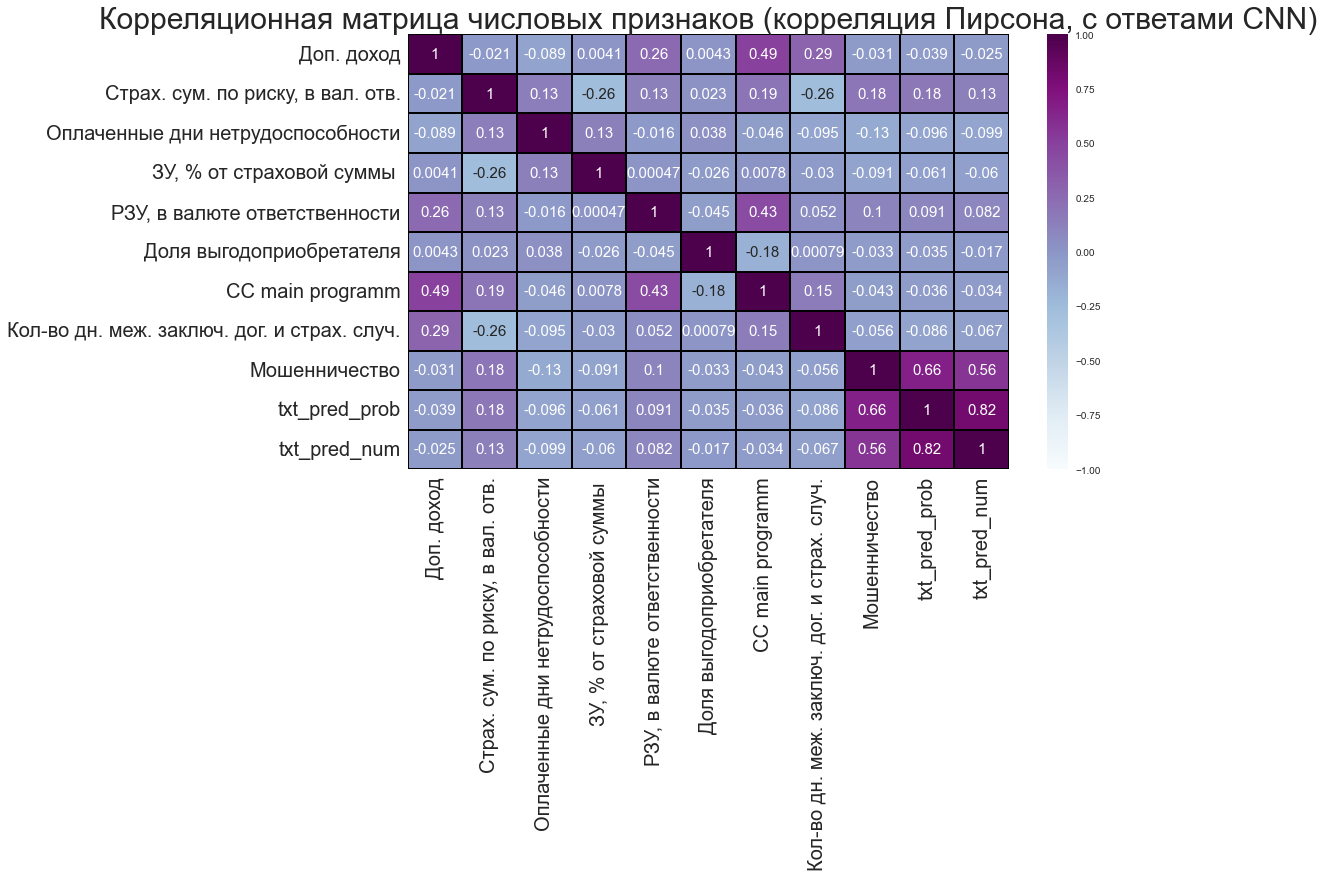

In [2536]:
plt.figure(figsize = (12,8))
plt.title('Корреляционная матрица числовых признаков (корреляция Пирсона, с ответами CNN)', fontsize = 30)
ax = sns.heatmap(df_num_for_corr_train.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1.5, linecolor='black', cmap='BuPu', annot_kws={"size": 15})
ax.tick_params(axis='x', labelsize=20, rotation=90)
ax.tick_params(axis='y', labelsize=20)
plt.show()

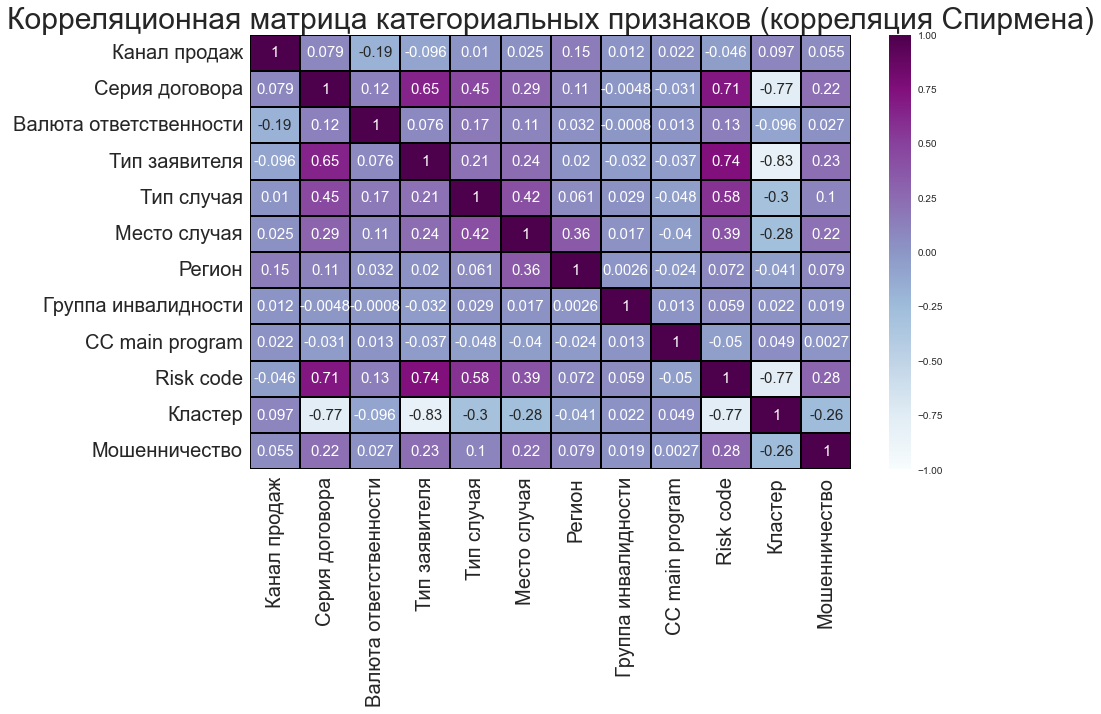

In [2534]:
plt.figure(figsize = (12,8))
plt.title('Корреляционная матрица категориальных признаков (корреляция Спирмена)', fontsize = 30)
ax = sns.heatmap(df_cat_for_corr_train.corr(method='spearman').dropna(axis=0, how='all').dropna(axis=1, how='all'), annot = True, fmt='.2g', vmin=-1, vmax=1, center=0, linewidths=1.5, linecolor='black', cmap='BuPu', annot_kws={"size": 15})
ax.tick_params(axis='x', labelsize=20, rotation=90)
ax.tick_params(axis='y', labelsize=20)
plt.show()

### CNN

In [22]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(256, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
              loss='categorical_crossentropy', 
              metrics=['AUC'])

model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_auc',
                                      save_best_only=True,
                                      verbose=1)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 32)           32000     
                                                                 
 conv1d (Conv1D)             (None, 154, 256)          41216     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                        

In [23]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=20,
                            batch_size=32,
                            validation_split=0.3,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/20
463/467 [============================>.] - ETA: 0s - loss: 0.4609 - auc: 0.8665
Epoch 1: val_auc improved from inf to 0.88461, saving model to best_model_cnn.h5
467/467 [==============================] - 5s 9ms/step - loss: 0.4607 - auc: 0.8664 - val_loss: 0.4033 - val_auc: 0.8846
Epoch 2/20
463/467 [============================>.] - ETA: 0s - loss: 0.3841 - auc: 0.9015
Epoch 2: val_auc did not improve from 0.88461
467/467 [==============================] - 4s 8ms/step - loss: 0.3851 - auc: 0.9011 - val_loss: 0.3902 - val_auc: 0.9089
Epoch 3/20
463/467 [============================>.] - ETA: 0s - loss: 0.3737 - auc: 0.9113
Epoch 3: val_auc did not improve from 0.88461
467/467 [==============================] - 4s 8ms/step - loss: 0.3731 - auc: 0.9116 - val_loss: 0.3798 - val_auc: 0.9113
Epoch 4/20
463/467 [============================>.] - ETA: 0s - loss: 0.3630 - auc: 0.9179
Epoch 4: val_auc did not improve from 0.88461
467/467 [==============================] - 4s 8ms/step

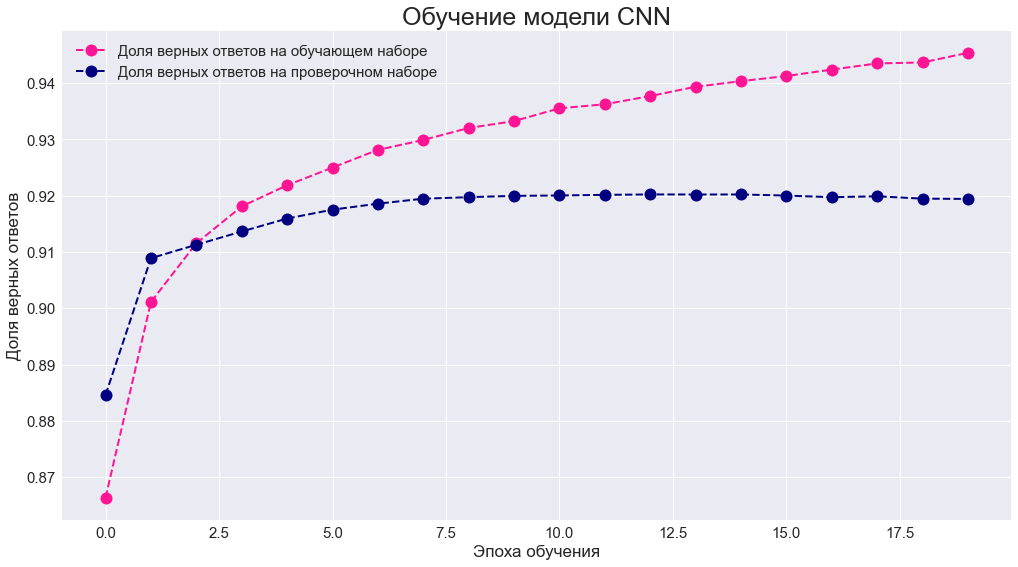

In [24]:
plt.figure(figsize=(17, 9))
plt.plot(history_cnn.history['auc'], color='deeppink', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_auc'], color='navy', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на проверочном наборе')
plt.title('Обучение модели CNN', fontsize = 25)
plt.xlabel('Эпоха обучения', fontsize = 17)
plt.ylabel('Доля верных ответов', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

### LSTM

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16, recurrent_dropout=0.3))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(2, activation='softmax'))

model_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
              loss='categorical_crossentropy', 
              metrics=['AUC'])

model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_auc',
                                      save_best_only=True,
                                      verbose=1)

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 32)           32000     
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 35,170
Trainable params: 35,170
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=20,
                              batch_size=32,
                              validation_split=0.3,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/20
467/467 [==============================] - ETA: 0s - loss: 0.5540 - auc: 0.8640
Epoch 1: val_auc improved from inf to 0.88293, saving model to best_model_lstm.h5
467/467 [==============================] - 21s 40ms/step - loss: 0.5540 - auc: 0.8640 - val_loss: 0.4089 - val_auc: 0.8829
Epoch 2/20
467/467 [==============================] - ETA: 0s - loss: 0.4101 - auc: 0.8681
Epoch 2: val_auc did not improve from 0.88293
467/467 [==============================] - 19s 40ms/step - loss: 0.4101 - auc: 0.8681 - val_loss: 0.4059 - val_auc: 0.8931
Epoch 3/20
467/467 [==============================] - ETA: 0s - loss: 0.4025 - auc: 0.8771
Epoch 3: val_auc did not improve from 0.88293
467/467 [==============================] - 18s 39ms/step - loss: 0.4025 - auc: 0.8771 - val_loss: 0.4000 - val_auc: 0.9005
Epoch 4/20
467/467 [==============================] - ETA: 0s - loss: 0.3976 - auc: 0.8839
Epoch 4: val_auc did not improve from 0.88293
467/467 [==============================] - 18s 

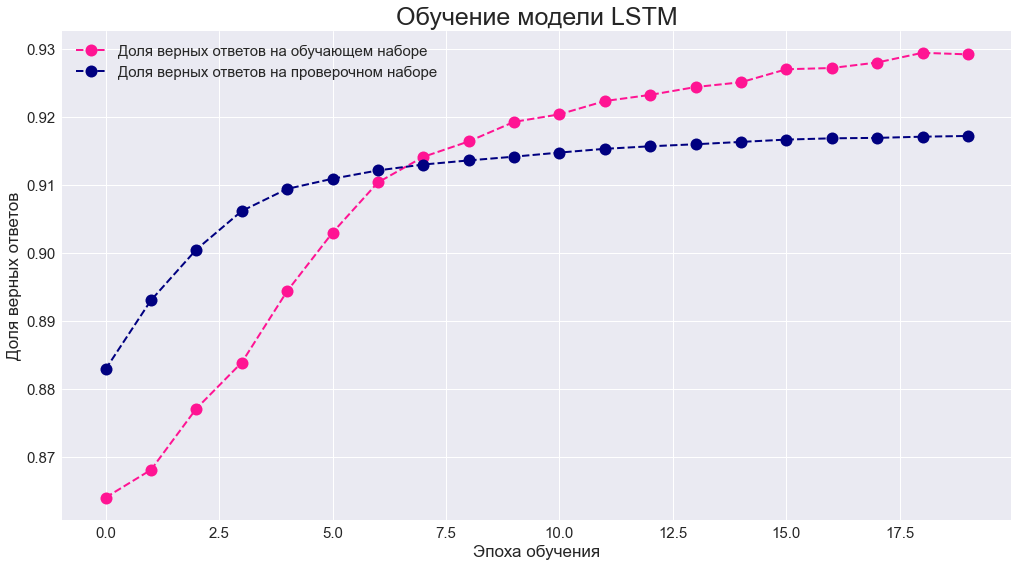

In [27]:
plt.figure(figsize=(17, 9))
plt.plot(history_lstm.history['auc'], color='deeppink', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_auc'], color='navy', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на проверочном наборе')
plt.title('Обучение модели LSTM', fontsize = 25)
plt.xlabel('Эпоха обучения', fontsize = 17)
plt.ylabel('Доля верных ответов', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [28]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

### GRU

In [29]:
from tensorflow.keras import backend as K

In [30]:
from keras.layers import Lambda
def func(x):

    greater = K.greater_equal(x, 0.5) #will return boolean values
    greater = K.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1    
    return greater 

In [31]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16, recurrent_dropout=0.3))
#model_gru.add(Dropout(0.3))
#model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))
#model_gru.add(Dense(2, activation='softmax'))
#model_gru.add(Lambda(func, output_shape=2))
#model_gru.add(Dense(2))

model_gru.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
              loss='categorical_crossentropy', 
              metrics=['AUC'])

model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_auc',
                                      save_best_only=True,
                                      verbose=1)

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 32)           32000     
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,417
Trainable params: 34,417
Non-trainable params: 0
_________________________________________________________________


In [32]:
sum(y_train[:,0])

2992.0

In [33]:
history_gru = model_gru.fit(x_train, 
                              y_train[:,0], 
                              epochs=5,
                              batch_size=32,
                              validation_split=0.3,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
467/467 [==============================] - ETA: 0s - loss: 0.0000e+00 - auc: 0.5143
Epoch 1: val_auc improved from inf to 0.60045, saving model to best_model_gru.h5
467/467 [==============================] - 18s 34ms/step - loss: 0.0000e+00 - auc: 0.5143 - val_loss: 0.0000e+00 - val_auc: 0.6004
Epoch 2/5
467/467 [==============================] - ETA: 0s - loss: 0.0000e+00 - auc: 0.5092
Epoch 2: val_auc improved from 0.60045 to 0.53715, saving model to best_model_gru.h5
467/467 [==============================] - 16s 34ms/step - loss: 0.0000e+00 - auc: 0.5092 - val_loss: 0.0000e+00 - val_auc: 0.5371
Epoch 3/5
467/467 [==============================] - ETA: 0s - loss: 0.0000e+00 - auc: 0.5095
Epoch 3: val_auc improved from 0.53715 to 0.50000, saving model to best_model_gru.h5
467/467 [==============================] - 16s 33ms/step - loss: 0.0000e+00 - auc: 0.5095 - val_loss: 0.0000e+00 - val_auc: 0.5000
Epoch 4/5
467/467 [==============================] - ETA: 0s - loss: 0.000

In [149]:
history_gru.history

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0],
 'auc': [0.5137314200401306,
  0.5075037479400635,
  0.5327385067939758,
  0.5021141767501831,
  0.5],
 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_auc': [0.6042978763580322, 0.5041647553443909, 0.5, 0.5, 0.5]}

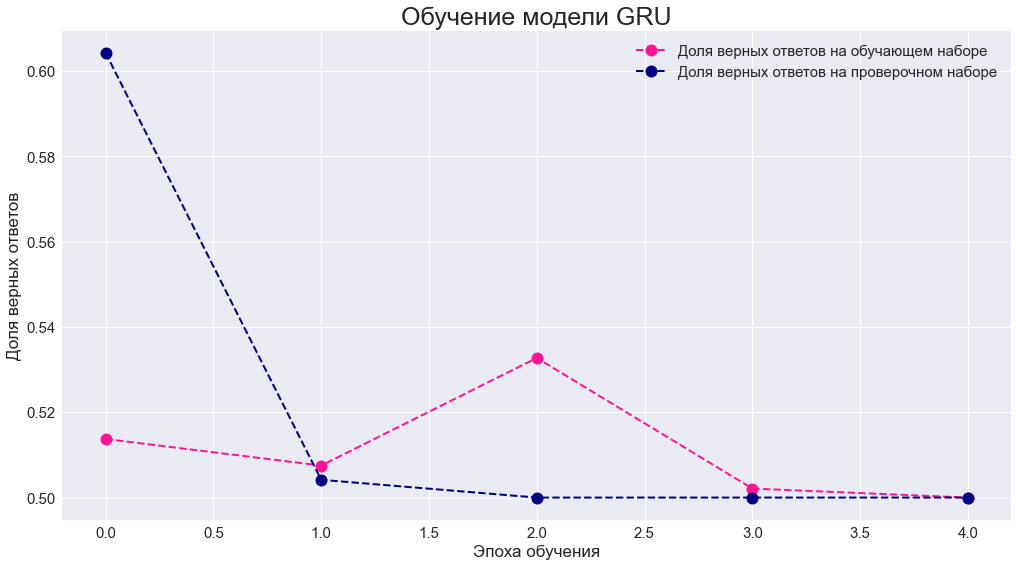

In [150]:
plt.figure(figsize=(17, 9))
plt.plot(history_gru.history['auc'], color='deeppink', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_auc'], color='navy', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Доля верных ответов на проверочном наборе')
plt.title('Обучение модели GRU', fontsize = 25)
plt.xlabel('Эпоха обучения', fontsize = 17)
plt.ylabel('Доля верных ответов', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [151]:
y_pred_train = model_gru.predict(x_train)
y_pred_train

667/667 [==============================] - 5s 7ms/step


array([[0.00105385],
       [0.00105242],
       [0.00100844],
       ...,
       [0.00100844],
       [0.00103719],
       [0.00104473]], dtype=float32)

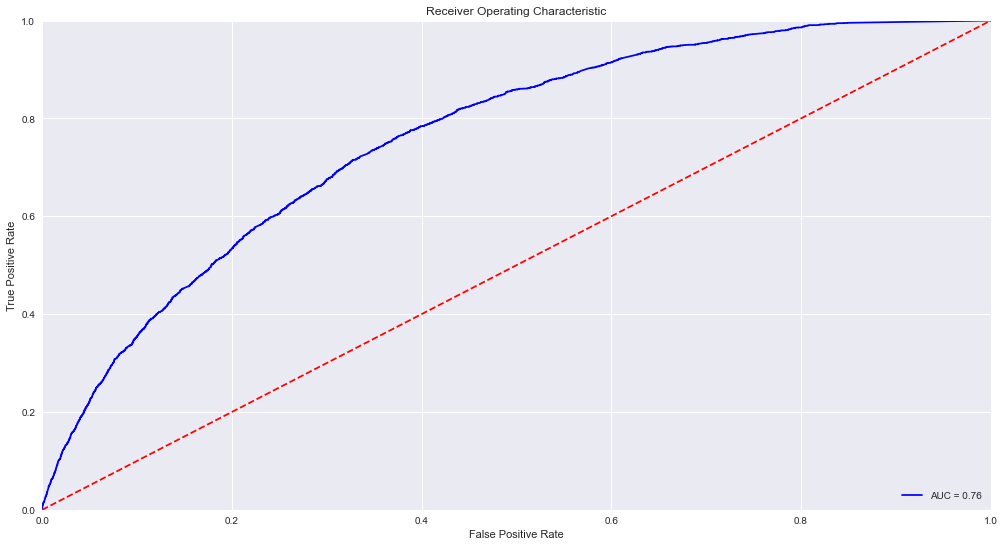

In [50]:
fpr, tpr, threshold = roc_curve(y_train[:, 0], y_pred_train[:, 0])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [51]:
y_pred_test = model_gru.predict(x_test)
y_pred_test

286/286 [==============================] - 2s 8ms/step


array([[0.09165123, 0.90834874],
       [0.05902492, 0.940975  ],
       [0.1842979 , 0.81570214],
       ...,
       [0.18965133, 0.8103487 ],
       [0.305137  , 0.69486296],
       [0.15311472, 0.84688526]], dtype=float32)

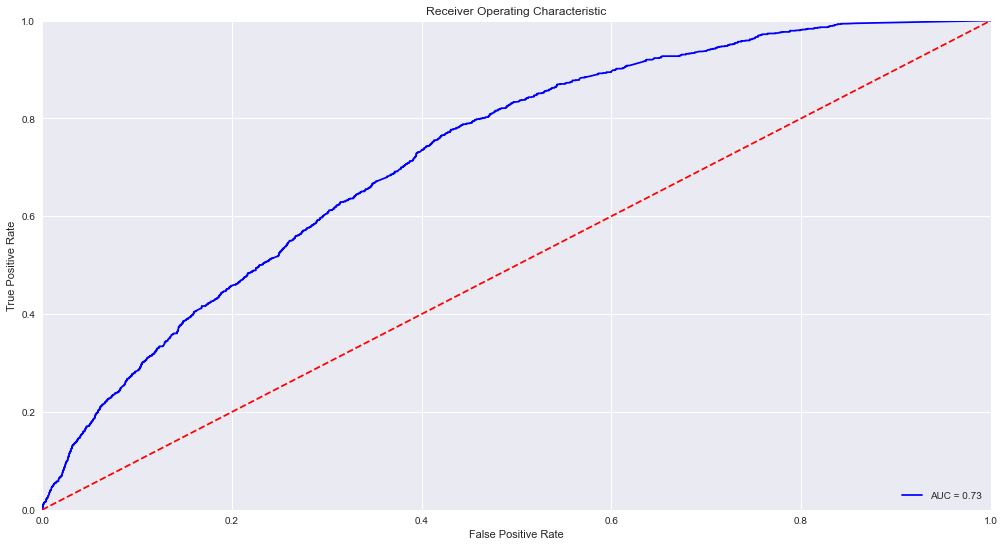

In [52]:
fpr, tpr, threshold = roc_curve(y_test[:, 0], y_pred_test[:, 0])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(17, 9))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [65]:
y_test_new = pd.DataFrame(y_test[:, 0], columns=['Мошенничество'])['Мошенничество']

y_pred_test_new = pd.DataFrame(y_pred_test)
y_pred_test_new['Мошенничество'] = 0
y_pred_test_new

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9139    0.0
9140    0.0
9141    0.0
9142    0.0
9143    0.0
Name: Мошенничество, Length: 9144, dtype: float32

In [82]:
y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0]

0.940975

In [83]:
((y_pred_test[:,1]>=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] - 0.0001)) & 
                 (y_pred_test[:,1]<=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] + 0.0001)))

array([False,  True, False, ..., False, False, False])

In [93]:
y_pred_test_new[((y_pred_test[:,1]>=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] - 0.001)) & 
                 (y_pred_test[:,1]<=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] + 0.001)))]['Мошенничество'] = 1

In [94]:
y_pred_test_new

0         1  Мошенничество
0     0.091651  0.908349              0
1     0.059025  0.940975              0
2     0.184298  0.815702              0
3     0.141348  0.858652              0
4     0.211190  0.788810              0
...        ...       ...            ...
9139  0.057290  0.942710              0
9140  0.366745  0.633255              0
9141  0.189651  0.810349              0
9142  0.305137  0.694863              0
9143  0.153115  0.846885              0

[9144 rows x 3 columns]

In [86]:
y_pred_test_new[((y_pred_test[:,1]>=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] - 0.001)) & 
                 (y_pred_test[:,1]<=(y_pred_test[y_test_new[y_test_new==1].astype(int)][:,1][0] + 0.001)))]['Мошенничество'] = 1
y_pred_test_new

0         1  Мошенничество
0     0.091651  0.908349              0
1     0.059025  0.940975              0
2     0.184298  0.815702              0
3     0.141348  0.858652              0
4     0.211190  0.788810              0
...        ...       ...            ...
9139  0.057290  0.942710              0
9140  0.366745  0.633255              0
9141  0.189651  0.810349              0
9142  0.305137  0.694863              0
9143  0.153115  0.846885              0

[9144 rows x 3 columns]

In [ ]:
frames = [df1, df2, df3]

result = pd.concat(frames)

In [81]:
y_pred

array([[0.0753438 , 0.9246562 ],
       [0.01477833, 0.9852217 ],
       [0.09082234, 0.9091777 ],
       ...,
       [0.22473277, 0.77526724],
       [0.14788947, 0.8521105 ],
       [0.1628307 , 0.8371693 ]], dtype=float32)

In [163]:
#pd.DataFrame(tokenizer.sequences_to_texts(x_train))

In [147]:
sum(pd.DataFrame((y_pred > thresholds[best_idx]).astype("int32"))[0])
np.vstack([pd.DataFrame((a > thresholds[best_idx]).astype("int32"))[0], txt_data['Мошенничество']])

0

In [116]:
roc_auc_score(y_val, y_pred[:, 0])

0.7459865192670954

In [146]:
fpr, tpr, threshold = roc_curve(y_val, y_pred[:, 0])
a = tpr - (1-fpr)
a_min = min(abs(a))
b = pd.DataFrame(a)
b[b[0]==a_min]

0
4659  0.000077

In [117]:
accuracy_score(txt_data['Мошенничество'], y_pred_new['Мошенничество'])

0.8607802605243299

In [148]:
sum(pd.DataFrame((y_pred >= pd.Series(threshold)[b[b[0]==a_min].index[0]]).astype("int32"))[0])

12123

In [67]:
sum(txt_data['Мошенничество'])

4243

In [68]:
_result=pd.concat([pd.Series(threshold),pd.Series(a)],axis=1)
_result.columns=['threshold','score']
_result

threshold     score
0      1.828276 -1.000000
1      0.828276 -0.999764
2      0.783094 -0.999529
3      0.779654 -0.999057
4      0.741494 -0.998350
...         ...       ...
8163   0.015042  0.842220
8164   0.008984  0.842372
8165   0.007863  0.842563
8166   0.005329  0.843256
8167   0.004731  1.000000

[8168 rows x 2 columns]

In [171]:
np.vstack([pd.DataFrame((y_pred > 0.5).astype("int32"))[0], txt_data['Мошенничество']])

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

In [73]:
_, n_classes = y_pred.shape

for i in range(n_classes):

    # Computing best threshold for i-th class
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred[:, i], pos_label=i)

    # compute f-1
    f1 = 2 * precision * recall / (precision + recall)

    # pick up the best threshold's index
    best_idx = np.argmax(f1)
    print(f'For class {i} the best possible threshold is {thresholds[best_idx]:.3f} wich leads to f1={f1[best_idx]:.3f}')

For class 0 the best possible threshold is 0.741 wich leads to f1=nan
For class 1 the best possible threshold is 0.172 wich leads to f1=0.244


In [34]:
data[['Тип заявителя', 'Причина случая', 'Тип страх. случая', 'Описание ЭСС', 'Мошенничество']].dropna()

Тип заявителя              Причина случая Тип страх. случая  \
0           Застрахованный              Бытовая травма            Травмы   
1           Застрахованный                     Дожитие           Дожитие   
3           Застрахованный  Автомобильная авария (ДТП)            Травмы   
4           Застрахованный              Бытовая травма            Травмы   
5           Застрахованный              Бытовая травма            Травмы   
...                    ...                         ...               ...   
31289  Выгодоприобретатель                      смерть            Смерть   
31290       Застрахованный                 Заболевание      Инвалидность   
31291       Застрахованный                 Заболевание      Инвалидность   
31292  Выгодоприобретатель                      смерть            Смерть   
31293  Выгодоприобретатель                      смерть            Смерть   

                                            Описание ЭСС  Мошенничество  
0                            Перелом левой лучевой кости              0  
1                                                Дожитие              0  
3      S12.20 - Перелом других уточненных шейных позв...              0  
4      Сотрясение головного мозга. Ушиб шейного отдел...              0  
5      Консолидированный закрытый перелом большого бу...              0  
...                                                  ...            ...  
31289                    Субарахноидальное кровоизлияние              0  
31290                         рак средней трети пищевода              1  
31291                                   последствия ОНМК              1  
31292  Y29 - Контакт с тупым предметом с неопределенн...              0  
31293                  Острая коронарная недостаточность              0  

[30477 rows x 5 columns]

In [43]:
txt_data['text']

0        застрахова бытов травм травм перел лев лучев кост
1                             застрахова дожит дожит дожит
2        застрахова автомобильн авар дтп травм s12 20 -...
3        застрахова бытов травм травм сотрясен головн м...
4        застрахова бытов травм травм консолидирова зак...
                               ...                        
30472    выгодоприобретател смерт смерт субарахноидальн...
30473    застрахова заболеван инвалидн рак средн трет п...
30474         застрахова заболеван инвалидн последств онмк
30475    выгодоприобретател смерт смерт y29 - контакт т...
30476    выгодоприобретател смерт смерт остр коронарн н...
Name: text, Length: 30477, dtype: object

In [66]:
utils.to_categorical(txt_data['Мошенничество'] - 1, nb_classes)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [53]:
txt_data['Мошенничество']

0        0
1        0
2        0
3        0
4        0
        ..
30472    0
30473    1
30474    1
30475    0
30476    0
Name: Мошенничество, Length: 30477, dtype: int64

In [15]:


class Animal:
    
    age = 18
    
    
    def speak():
        
        return print('Hello')
    
class 


class WaterAnimal(Animal, Cat):

    def __init__(self, name):
        
        self.name = name
        
    def speak(self):
        
        self.age = 20
        
        return print(f'I am {self.name}')
        
        
animal1 = WaterAnimal('Dima')
animal2 = WaterAnimal('Max')
animal1.speak()
Animal.speak()
animal1.age, animal2.age, WaterAnimal.age

animal3 = WaterAnimal('Dima')

animal3.age

I am Dima
Hello


18